In [34]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

TensorFlow version: 1.13.1
Keras version: 2.1.3


In [35]:
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
import cairocffi as cairo
import editdistance
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import cv2

In [36]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True, allow_soft_placement=True))
K.set_session(sess)

**Unpacking model**

In [37]:
model = load_model(
    "keras_ocr/model24.h5", 
    custom_objects={'<lambda>': keras.losses.mse}
)

**Cutting layers**

In [38]:
cutted_model = Model(model.layers[0].input, model.get_layer("softmax").output)

**Test func & decode**

In [42]:
alphabet = u'abcdefghijklmnopqrstuvwxyz '
# Reverse translation of numerical classes back to characters
def labels_to_text(labels):
    ret = []
    for c in labels:
        if c == len(alphabet):  # CTC Blank
            ret.append("")
        else:
            ret.append(alphabet[c])
    return "".join(ret)

# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.
alph = 'abcdefghijklmnopqrstuvwxyz '
def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = labels_to_text(out_best)
        ret.append(outstr)
    return ret

**Generating images**

In [43]:
def speckle(img):
    severity = np.random.uniform(0, 0.6)
    blur = ndimage.gaussian_filter(np.random.randn(*img.shape) * severity, 1)
    img_speck = (img + blur)
    img_speck[img_speck > 1] = 1
    img_speck[img_speck <= 0] = 0
    return img_speck


# paints the string in a random location the bounding box
# also uses a random font, a slight random rotation,
# and a random amount of speckle noise

def paint_text(text, w, h, rotate=False, ud=False, multi_fonts=False):
    surface = cairo.ImageSurface(cairo.FORMAT_RGB24, w, h)
    with cairo.Context(surface) as context:
        context.set_source_rgb(1, 1, 1)  # White
        context.paint()
        # this font list works in CentOS 7
        if multi_fonts:
            fonts = [
                'Century Schoolbook', 'Courier', 'STIX',
                'URW Chancery L', 'FreeMono']
            context.select_font_face(
                np.random.choice(fonts),
                cairo.FONT_SLANT_NORMAL,
                np.random.choice([cairo.FONT_WEIGHT_BOLD, cairo.FONT_WEIGHT_NORMAL]))
        else:
            context.select_font_face('Courier',
                                     cairo.FONT_SLANT_NORMAL,
                                     cairo.FONT_WEIGHT_BOLD)
        context.set_font_size(25)
        box = context.text_extents(text)
        border_w_h = (4, 4)
        if box[2] > (w - 2 * border_w_h[1]) or box[3] > (h - 2 * border_w_h[0]):
            raise IOError(('Could not fit string into image.'
                           'Max char count is too large for given image width.'))

        # teach the RNN translational invariance by
        # fitting text box randomly on canvas, with some room to rotate
        max_shift_x = w - box[2] - border_w_h[0]
        max_shift_y = h - box[3] - border_w_h[1]
        top_left_x = np.random.randint(0, int(max_shift_x))
        if ud:
            top_left_y = np.random.randint(0, int(max_shift_y))
        else:
            top_left_y = h // 2
        context.move_to(top_left_x - int(box[0]), top_left_y - int(box[1]))
        context.set_source_rgb(0, 0, 0)
        context.show_text(text)

    buf = surface.get_data()
    a = np.frombuffer(buf, np.uint8)
    a.shape = (h, w, 4)
    a = a[:, :, 0]  # grab single channel
    a = a.astype(np.float32) / 255
    a = np.expand_dims(a, 0)
    if rotate:
        a = image.random_rotation(a, 3 * (w - top_left_x) / w + 1)
    a = speckle(a)

    return a

In [44]:
te_amo = paint_text("te amo", 512, 64)[0, :, :]

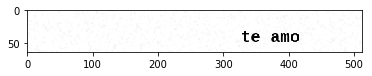

In [45]:
plt.imshow(te_amo, cmap='gray')

**Converting to CoreML**

In [46]:
import coremltools

coreml_model = coremltools.converters.keras.convert(cutted_model)

coreml_model.author = "klabertants"
coreml_model.license = "Public Domain."
coreml_model.short_description = "OCR with keras (only English)."

coreml_model.save("keras_ocr.mlmodel")

0 : the_input, <keras.engine.topology.InputLayer object at 0x7fabf462f7b8>
1 : reshape_16, <keras.layers.core.Reshape object at 0x7fabf462f198>
2 : conv1, <keras.layers.convolutional.Conv2D object at 0x7fabf462fc88>
3 : conv1__activation__, <keras.layers.core.Activation object at 0x7faae542dac8>
4 : max1, <keras.layers.pooling.MaxPooling2D object at 0x7fabf462f3c8>
5 : conv2, <keras.layers.convolutional.Conv2D object at 0x7fabf462fa58>
6 : conv2__activation__, <keras.layers.core.Activation object at 0x7faae542dd30>
7 : max2, <keras.layers.pooling.MaxPooling2D object at 0x7fabf462fdd8>
8 : reshape, <keras.layers.core.Reshape object at 0x7fabf461fdd8>
9 : dense1, <keras.layers.core.Dense object at 0x7fabf461f748>
10 : dense1__activation__, <keras.layers.core.Activation object at 0x7faae542d9e8>
11 : gru1, <keras.layers.recurrent.GRU object at 0x7fabf461fb70>
12 : gru1_b, <keras.layers.recurrent.GRU object at 0x7fabf461f6a0>
13 : add_15, <keras.layers.merge.Add object at 0x7fabf461f5f8>
1

**Experiments**

In [47]:
swift_img = np.array(
    [[1.0, 1.0, 1.0, 1.0, 0.972549, 0.9607843, 0.99607843, 1.0, 0.9843137, 0.93333334, 0.9490196, 0.972549, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9254902, 0.9372549, 0.9529412, 0.9529412, 0.92941177, 0.8901961, 0.90588236, 1.0, 1.0, 0.9607843, 0.9529412, 0.972549, 0.92941177, 0.9529412, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.87058824, 0.85882354, 0.9098039, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.9647059, 1.0, 1.0, 0.92156863, 0.95686275, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.90588236, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92941177, 0.87058824, 0.8509804, 0.9019608, 0.9764706, 1.0, 1.0, 0.90588236, 0.80784315, 0.88235295, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.8627451, 0.8784314, 0.9764706, 1.0, 1.0, 0.972549, 0.98039216, 1.0, 1.0, 1.0, 0.9529412, 1.0, 1.0, 1.0, 0.90588236, 0.8627451, 0.84313726, 0.8980392, 1.0, 1.0, 0.99215686, 0.89411765, 0.93333334, 1.0, 1.0, 0.96862745, 0.9098039, 0.972549, 1.0, 1.0, 0.98039216, 0.92941177, 0.9529412, 0.9647059, 0.9529412, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.91764706, 0.92941177, 0.99215686, 1.0, 0.99607843, 1.0, 1.0, 0.99607843, 0.93333334, 0.9098039, 0.89411765, 0.88235295, 0.9019608, 0.9529412, 0.99215686, 0.95686275, 0.8980392, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9882353, 0.99215686, 0.98039216, 0.9764706, 0.9882353, 0.9764706, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9137255, 1.0, 1.0, 1.0, 0.91764706, 0.89411765, 0.9843137, 1.0, 0.96862745, 0.9098039, 0.9137255, 0.9764706, 1.0, 1.0, 1.0, 0.96862745, 0.972549, 1.0, 1.0, 1.0, 0.98039216, 0.95686275, 0.9529412, 0.9254902, 0.8862745, 0.9019608, 0.99607843, 1.0, 1.0, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9372549, 0.9254902, 0.9372549, 0.9137255, 0.8901961, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.8392157, 0.87058824, 0.9254902, 0.8901961, 0.8392157, 0.8509804, 0.9019608, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9372549, 0.89411765, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8392157, 0.7882353, 0.87058824, 0.9529412, 1.0, 1.0, 0.972549, 0.94509804, 0.9411765, 0.90588236, 0.827451, 0.77254903, 0.7882353, 0.7921569, 0.8156863, 0.8352941, 0.7921569, 0.7607843, 0.8235294, 0.9019608, 0.9843137, 1.0, 0.92941177, 0.9137255, 0.9490196, 0.99215686, 0.9647059, 0.8901961, 0.88235295, 0.93333334, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.8784314, 0.8352941, 0.9372549, 1.0, 1.0, 1.0, 0.9647059, 0.8745098, 0.85882354, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9019608, 0.9098039, 0.91764706, 0.89411765, 0.91764706, 1.0, 1.0, 0.98039216, 0.92156863, 0.9372549, 0.972549, 0.99607843, 0.98039216, 0.95686275, 0.972549, 1.0, 1.0, 1.0, 0.9490196, 0.94509804, 1.0, 1.0, 1.0, 0.95686275, 0.90588236, 0.92941177, 0.9882353, 0.99607843, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9254902, 0.9529412, 0.98039216, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.81960785, 0.827451, 0.84313726, 0.8392157, 0.8784314, 0.92156863, 0.91764706, 0.8745098, 0.8784314, 0.9764706, 1.0, 0.96862745, 0.8980392, 0.87058824, 0.89411765, 0.9490196, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9764706, 0.99607843, 1.0, 1.0, 0.9882353, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9372549, 0.95686275, 1.0, 1.0, 0.972549, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.8509804, 0.81960785, 0.92156863, 0.99215686, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.8745098, 0.8745098, 0.9882353, 1.0, 1.0, 0.98039216, 0.90588236, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9254902, 0.9529412, 0.92941177, 0.90588236, 0.90588236, 0.9137255, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 0.9411765, 0.9254902, 0.9647059, 0.972549, 0.9764706, 1.0], [1.0, 1.0, 1.0, 1.0, 0.972549, 0.9882353, 1.0, 1.0, 0.94509804, 0.9372549, 0.9764706, 0.9843137, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.88235295, 0.8862745, 0.8980392, 0.9254902, 0.9411765, 0.9490196, 0.9607843, 0.9843137, 0.9843137, 0.91764706, 0.8901961, 0.91764706, 0.9019608, 0.9098039, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9764706, 1.0, 1.0, 1.0, 0.98039216, 0.9137255, 0.93333334, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 1.0, 1.0, 1.0, 0.9372549, 0.96862745, 1.0, 1.0, 0.9843137, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.92156863, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9372549, 0.90588236, 0.8784314, 0.89411765, 0.9529412, 1.0, 1.0, 0.93333334, 0.8980392, 0.9411765, 0.9764706, 0.95686275, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.92156863, 0.9254902, 0.9411765, 0.9764706, 0.9843137, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.95686275, 1.0, 1.0, 1.0, 0.95686275, 0.8862745, 0.87058824, 0.9372549, 1.0, 1.0, 0.99607843, 0.8980392, 0.92156863, 1.0, 1.0, 0.95686275, 0.9254902, 0.9882353, 1.0, 1.0, 0.96862745, 0.93333334, 0.98039216, 1.0, 0.9490196, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9372549, 0.9490196, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9647059, 0.9490196, 0.9490196, 0.99215686, 1.0, 0.98039216, 0.9137255, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.99215686, 1.0, 1.0, 0.99215686, 0.8980392, 0.90588236, 1.0, 1.0, 1.0, 0.9764706, 0.92941177, 0.9490196, 0.99607843, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 0.99215686, 0.95686275, 0.9490196, 0.9529412, 0.95686275, 0.95686275, 1.0, 1.0, 1.0, 0.9529412, 0.9607843, 0.9882353, 0.96862745, 0.9529412, 0.95686275, 0.9647059, 1.0, 1.0, 0.9647059, 0.8745098, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.90588236, 0.9137255, 0.92941177, 0.8901961, 0.8627451, 0.8862745, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9529412, 0.9411765, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.8745098, 0.92156863, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.9607843, 0.9843137, 0.9647059, 0.9098039, 0.8352941, 0.8039216, 0.8156863, 0.8666667, 0.9137255, 0.9137255, 0.92156863, 0.9490196, 0.9764706, 1.0, 1.0, 0.96862745, 0.9137255, 0.9019608, 0.9137255, 0.92156863, 0.92156863, 0.9529412, 1.0, 0.99215686, 0.9882353, 1.0, 1.0, 1.0, 0.9882353, 0.94509804, 0.90588236, 0.8901961, 0.8862745, 0.9254902, 0.98039216, 1.0, 1.0, 1.0, 0.9490196, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9372549, 0.9607843, 1.0, 0.972549, 0.9490196, 0.99215686, 1.0, 1.0, 0.95686275, 0.93333334, 0.91764706, 0.92156863, 0.94509804, 0.9882353, 1.0, 0.9882353, 0.9764706, 0.98039216, 0.9529412, 0.8980392, 0.8745098, 0.88235295, 0.9254902, 1.0, 1.0, 1.0, 0.9411765, 0.93333334, 0.9764706, 0.99607843, 1.0, 0.96862745, 0.93333334, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9098039, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9254902, 0.9490196, 0.9882353, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.94509804, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.8784314, 0.9098039, 0.9490196, 1.0, 1.0, 1.0, 0.9372549, 0.9137255, 0.99607843, 1.0, 1.0, 0.93333334, 0.8666667, 0.8509804, 0.89411765, 0.92941177, 0.972549, 1.0, 1.0, 1.0, 0.9843137, 0.9490196, 0.9411765, 0.95686275, 0.972549, 0.9490196, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.91764706, 0.93333334, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.88235295, 0.83137256, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.972549, 1.0, 1.0, 1.0, 0.9647059, 0.93333334, 0.93333334, 1.0, 1.0, 1.0, 0.9764706, 0.92156863, 0.9254902, 0.9411765, 0.9372549, 0.9490196, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.91764706, 0.92941177, 0.9019608, 0.8980392, 0.89411765, 0.8862745, 0.92156863, 0.9490196, 0.92941177, 0.9411765, 0.96862745, 0.96862745, 0.9372549, 0.9647059, 1.0, 0.9882353, 0.91764706, 0.8901961, 0.9411765, 1.0, 1.0, 1.0, 1.0], [0.9098039, 0.96862745, 0.98039216, 0.96862745, 1.0, 1.0, 1.0, 0.9843137, 0.9019608, 0.90588236, 0.9411765, 0.94509804, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.85882354, 0.8627451, 0.8666667, 0.8901961, 0.9098039, 0.9529412, 0.9607843, 0.9529412, 0.9529412, 0.8901961, 0.8392157, 0.89411765, 0.9411765, 0.9647059, 0.9607843, 0.94509804, 0.96862745, 0.9882353, 0.99607843, 1.0, 1.0, 0.99215686, 0.9647059, 0.9411765, 0.9607843, 1.0, 1.0, 0.9647059, 0.9490196, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92156863, 0.9019608, 0.9411765, 0.9882353, 0.9843137, 0.9647059, 0.9764706, 0.972549, 0.9882353, 1.0, 1.0, 0.99607843, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9647059, 0.9490196, 0.9254902, 0.93333334, 0.9490196, 0.9647059, 0.9529412, 0.9490196, 0.9843137, 1.0, 0.9764706, 0.92941177, 0.9647059, 1.0, 0.9843137, 1.0, 1.0, 1.0, 0.9882353, 0.9647059, 0.9529412, 0.90588236, 0.9098039, 0.93333334, 0.9490196, 1.0, 1.0, 1.0, 0.9764706, 0.9098039, 0.9254902, 0.99607843, 1.0, 0.972549, 0.92941177, 0.93333334, 0.98039216, 1.0, 1.0, 1.0, 0.92941177, 0.93333334, 1.0, 1.0, 0.99607843, 0.94509804, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9882353, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9372549, 1.0, 1.0, 1.0, 0.9764706, 1.0, 0.98039216, 0.9607843, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.96862745, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9372549, 0.9490196, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9372549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9137255, 0.92156863, 0.9098039, 0.9098039, 0.9254902, 0.9411765, 0.99607843, 1.0, 0.99607843, 0.92156863, 0.9137255, 0.9607843, 0.9843137, 0.972549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9882353, 0.9843137, 0.9529412, 0.94509804, 0.9607843, 1.0, 1.0, 0.99607843, 0.9843137, 1.0, 1.0, 0.972549, 0.94509804, 0.92941177, 0.9137255, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9411765, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9411765, 0.9882353, 1.0, 0.99607843, 0.96862745, 0.90588236, 0.84313726, 0.8352941, 0.8862745, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 0.9254902, 0.9098039, 0.92156863, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.8784314, 0.8392157, 0.8745098, 0.9098039, 0.93333334, 0.94509804, 0.94509804, 0.9882353, 1.0, 0.972549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.96862745, 0.99607843, 0.9490196, 0.85882354, 0.8784314, 0.94509804, 0.91764706, 0.8862745, 0.9490196, 1.0, 1.0, 1.0, 0.9843137, 0.95686275, 0.9647059, 0.9764706, 0.98039216, 0.972549, 0.9647059, 0.9843137, 0.9882353, 0.93333334, 0.8352941, 0.8, 0.8509804, 0.92156863, 0.9764706, 1.0, 1.0, 0.99215686, 0.972549, 0.96862745, 1.0, 1.0, 1.0, 0.96862745, 0.9411765, 0.9647059, 1.0, 1.0, 1.0, 0.972549, 0.9019608, 0.9098039, 0.98039216, 1.0, 1.0, 1.0, 0.99215686, 0.94509804, 0.87058824, 0.9019608, 0.9843137, 1.0, 0.99215686, 0.972549, 0.99607843, 1.0, 0.9490196, 0.9137255, 0.9372549, 0.9372549, 0.92941177, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 1.0, 0.972549, 0.89411765, 0.8627451, 0.8980392, 0.9372549, 0.94509804, 0.9843137, 1.0, 1.0, 1.0, 0.93333334, 0.85490197, 0.8627451, 0.90588236, 0.92156863, 0.92941177, 0.9843137, 1.0, 0.95686275, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.90588236, 0.8784314, 0.92941177, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9019608, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.93333334, 0.91764706, 0.9372549, 1.0, 1.0, 1.0, 0.9764706, 0.92941177, 0.9137255, 0.972549, 1.0, 1.0, 0.9882353, 0.99215686, 0.9882353, 1.0, 1.0, 1.0, 0.9882353, 0.95686275, 0.9372549, 0.90588236, 0.9019608, 0.94509804, 0.9647059, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.972549, 1.0, 1.0, 0.9607843, 0.89411765, 0.8509804, 0.84313726, 0.88235295, 0.8745098, 0.84705883, 0.8627451, 0.88235295, 0.91764706, 0.9490196, 0.96862745, 0.9607843, 0.9098039, 0.85882354, 0.8627451, 0.9372549, 1.0, 1.0, 1.0, 1.0], [0.85882354, 0.92156863, 0.93333334, 0.95686275, 1.0, 1.0, 1.0, 0.99607843, 0.91764706, 0.9254902, 0.9607843, 0.98039216, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.8901961, 0.85882354, 0.8352941, 0.84313726, 0.85490197, 0.8980392, 0.8862745, 0.8784314, 0.92941177, 0.92156863, 0.8862745, 0.95686275, 1.0, 1.0, 0.9764706, 0.8745098, 0.8627451, 0.9137255, 0.9490196, 0.9490196, 0.9411765, 0.92941177, 0.94509804, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 0.99607843, 0.85490197, 0.84313726, 0.89411765, 0.96862745, 1.0, 0.972549, 0.9529412, 0.9411765, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.972549, 0.98039216, 0.972549, 0.9372549, 0.9098039, 0.95686275, 1.0, 1.0, 0.95686275, 0.89411765, 0.92156863, 0.9607843, 0.9529412, 0.99607843, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.8980392, 0.88235295, 0.8901961, 0.90588236, 0.9529412, 0.99607843, 0.9882353, 0.94509804, 0.8862745, 0.85490197, 0.88235295, 0.93333334, 0.95686275, 0.96862745, 0.99215686, 1.0, 1.0, 0.99215686, 0.9843137, 0.95686275, 0.96862745, 1.0, 1.0, 1.0, 0.9764706, 0.9411765, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.99607843, 1.0, 0.99215686, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9882353, 0.9647059, 0.9254902, 0.9490196, 0.99215686, 1.0, 0.9647059, 0.9254902, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 0.96862745, 0.95686275, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.972549, 0.9843137, 0.9843137, 0.9882353, 0.99607843, 0.9764706, 0.9490196, 0.9411765, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.8901961, 0.88235295, 0.9019608, 0.9254902, 0.92941177, 0.9490196, 0.9607843, 0.9607843, 0.94509804, 0.9254902, 0.92941177, 0.96862745, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9764706, 1.0, 1.0, 1.0, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 0.98039216, 0.9372549, 0.9098039, 0.9098039, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.99215686, 0.9882353, 0.9647059, 0.9607843, 0.9764706, 1.0, 1.0, 0.972549, 0.96862745, 0.9607843, 0.92156863, 0.8901961, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.92156863, 0.9372549, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.8509804, 0.827451, 0.8862745, 0.94509804, 0.99215686, 0.9843137, 0.92941177, 0.9607843, 1.0, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 1.0, 0.93333334, 0.88235295, 0.9137255, 0.9607843, 0.92156863, 0.8156863, 0.81960785, 0.89411765, 0.8901961, 0.85882354, 0.9137255, 0.99215686, 0.99215686, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.95686275, 0.92156863, 0.94509804, 0.9882353, 0.9607843, 0.87058824, 0.827451, 0.8862745, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.93333334, 0.9372549, 0.99215686, 1.0, 1.0, 1.0, 0.9529412, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.8235294, 0.8784314, 1.0, 1.0, 0.972549, 0.9529412, 0.9843137, 0.98039216, 0.8980392, 0.8509804, 0.9019608, 0.95686275, 0.972549, 0.9764706, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.91764706, 0.91764706, 0.9764706, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.85882354, 0.8352941, 0.8745098, 0.8862745, 0.9019608, 0.9372549, 0.94509804, 0.9254902, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.94509804, 0.93333334, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.8980392, 0.8784314, 0.9019608, 0.94509804, 1.0, 1.0, 0.99607843, 1.0, 0.98039216, 0.91764706, 0.92941177, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9764706, 0.99607843, 0.99607843, 1.0, 1.0, 1.0, 0.9647059, 0.93333334, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.8627451, 0.87058824, 0.9137255, 0.90588236, 0.89411765, 0.92941177, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.92156863, 0.90588236, 0.94509804, 0.98039216, 0.9882353, 1.0, 1.0], [0.9098039, 0.9529412, 0.9411765, 0.9411765, 1.0, 1.0, 1.0, 0.99607843, 0.96862745, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.89411765, 0.8627451, 0.83137256, 0.85490197, 0.8901961, 0.90588236, 0.87058824, 0.8745098, 0.9490196, 0.95686275, 0.9529412, 1.0, 1.0, 1.0, 0.9019608, 0.8039216, 0.85490197, 0.92156863, 0.93333334, 0.93333334, 0.9372549, 0.9490196, 0.99607843, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 0.98039216, 0.972549, 0.98039216, 0.9607843, 0.96862745, 1.0, 1.0, 1.0, 0.8666667, 0.8352941, 0.8862745, 0.99215686, 1.0, 1.0, 0.95686275, 0.95686275, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.98039216, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.9098039, 0.8392157, 0.8745098, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 0.96862745, 0.9098039, 0.8980392, 0.92941177, 0.9411765, 0.92941177, 0.9098039, 0.91764706, 0.9137255, 0.88235295, 0.8862745, 0.92156863, 0.93333334, 0.95686275, 1.0, 1.0, 0.9843137, 0.9843137, 0.99215686, 0.96862745, 0.96862745, 0.9843137, 0.9843137, 0.9843137, 0.9647059, 0.9647059, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.89411765, 0.8980392, 0.93333334, 0.9529412, 0.9411765, 0.90588236, 0.9098039, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9372549, 0.9764706, 0.9882353, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 0.9843137, 0.9607843, 0.99215686, 1.0, 1.0, 0.9882353, 0.9098039, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.91764706, 0.92941177, 0.9607843, 0.972549, 0.9490196, 0.9098039, 0.90588236, 0.95686275, 0.95686275, 0.93333334, 0.9843137, 1.0, 0.99215686, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.92156863, 0.93333334, 0.9764706, 1.0, 0.99215686, 0.9490196, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.93333334, 0.92941177, 0.9529412, 0.98039216, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9372549, 0.9019608, 0.9098039, 0.9882353, 1.0, 1.0, 0.99607843, 0.95686275, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.94509804, 0.96862745, 1.0, 1.0, 1.0, 0.99607843, 0.99215686, 0.98039216, 0.9372549, 0.8627451, 0.83137256, 0.90588236, 0.98039216, 1.0, 0.99607843, 0.9254902, 0.9529412, 1.0, 0.9882353, 1.0, 1.0, 1.0, 0.9882353, 0.9529412, 0.98039216, 0.99607843, 1.0, 1.0, 1.0, 0.87058824, 0.84705883, 0.9372549, 1.0, 0.94509804, 0.80784315, 0.78039217, 0.8666667, 0.91764706, 0.9137255, 0.9411765, 0.96862745, 0.9372549, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.8901961, 0.90588236, 0.9843137, 1.0, 0.9607843, 0.92941177, 0.9411765, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9647059, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.87058824, 0.87058824, 0.9529412, 0.99215686, 0.9647059, 0.95686275, 1.0, 1.0, 0.972549, 0.9254902, 0.9490196, 0.9882353, 0.98039216, 0.92941177, 0.93333334, 1.0, 1.0, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9882353, 1.0, 1.0, 0.9529412, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.8862745, 0.89411765, 0.8745098, 0.90588236, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.92941177, 0.99607843, 1.0, 1.0, 0.9647059, 0.9137255, 0.91764706, 0.9607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9843137, 1.0, 1.0, 1.0, 0.99607843, 0.9411765, 0.9254902, 0.93333334, 0.93333334, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9529412, 0.9764706, 1.0, 0.99607843, 0.972549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.91764706, 0.9098039], [0.89411765, 0.9647059, 0.9843137, 0.95686275, 1.0, 1.0, 1.0, 0.9607843, 0.9607843, 0.93333334, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9098039, 0.8901961, 0.89411765, 0.8784314, 0.89411765, 0.90588236, 0.9019608, 0.9137255, 0.9764706, 1.0, 0.9764706, 0.9411765, 0.9882353, 1.0, 1.0, 0.8352941, 0.79607844, 0.9137255, 0.9764706, 0.9647059, 0.972549, 0.99607843, 1.0, 1.0, 1.0, 0.9647059, 0.9882353, 1.0, 1.0, 1.0, 0.99607843, 0.9647059, 0.92156863, 0.9137255, 0.9411765, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.89411765, 0.85490197, 0.8862745, 0.99607843, 1.0, 1.0, 0.972549, 0.9764706, 0.9843137, 0.98039216, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.8666667, 0.92941177, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.90588236, 0.96862745, 1.0, 1.0, 0.9372549, 0.9098039, 0.95686275, 0.9411765, 0.9019608, 0.85882354, 0.88235295, 0.9254902, 0.9254902, 0.9411765, 0.9607843, 0.9529412, 0.9490196, 0.9882353, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.95686275, 0.9254902, 0.8901961, 0.89411765, 0.93333334, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.92156863, 0.972549, 1.0, 1.0, 0.9843137, 0.83137256, 0.76862746, 0.85882354, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.8901961, 0.89411765, 0.9137255, 0.9411765, 0.9529412, 0.9411765, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9254902, 0.92941177, 0.98039216, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9411765, 0.96862745, 1.0, 0.98039216, 0.9254902, 0.91764706, 1.0, 1.0, 0.96862745, 0.99215686, 1.0, 0.9607843, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.8901961, 0.9098039, 0.91764706, 0.9137255, 0.91764706, 0.92156863, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9607843, 0.9764706, 0.99607843, 0.98039216, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9137255, 0.89411765, 0.9764706, 1.0, 1.0, 0.9843137, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9490196, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.8784314, 0.84313726, 0.9098039, 0.9647059, 0.9843137, 0.9843137, 0.9490196, 0.9764706, 1.0, 0.96862745, 0.9137255, 0.9137255, 0.9882353, 0.98039216, 0.93333334, 0.98039216, 1.0, 1.0, 1.0, 0.9490196, 0.8784314, 0.9098039, 0.99607843, 1.0, 0.96862745, 0.8392157, 0.80784315, 0.9098039, 1.0, 1.0, 1.0, 0.9764706, 0.9372549, 0.9607843, 1.0, 0.99215686, 0.9607843, 0.9764706, 1.0, 0.99215686, 0.9019608, 0.8901961, 0.9764706, 1.0, 1.0, 1.0, 0.9647059, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.89411765, 0.9098039, 0.972549, 0.98039216, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9490196, 0.9019608, 0.93333334, 1.0, 1.0, 0.9607843, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92156863, 0.8627451, 0.8980392, 0.98039216, 1.0, 0.9764706, 0.9529412, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9372549, 0.9254902, 0.8901961, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.96862745, 0.9843137, 0.9764706, 0.9490196, 0.8862745, 0.8627451, 0.9411765, 1.0, 0.99215686, 0.9647059, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 0.99607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.90588236, 0.8862745, 0.8862745, 0.9254902, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.972549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9490196, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.8392157, 0.78039217], [0.827451, 0.90588236, 0.96862745, 0.96862745, 0.9764706, 1.0, 0.9843137, 0.92941177, 0.9137255, 0.9098039, 0.9411765, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.93333334, 0.94509804, 0.9647059, 0.9647059, 0.9607843, 0.93333334, 0.90588236, 0.9529412, 1.0, 1.0, 0.9882353, 0.91764706, 0.91764706, 0.98039216, 0.9764706, 0.8666667, 0.85490197, 0.9490196, 0.9882353, 0.95686275, 0.9490196, 0.9843137, 1.0, 1.0, 1.0, 0.972549, 0.96862745, 1.0, 1.0, 0.96862745, 0.9411765, 0.9098039, 0.8980392, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9098039, 0.8666667, 0.8784314, 0.98039216, 1.0, 1.0, 0.9764706, 1.0, 1.0, 0.99215686, 0.99215686, 1.0, 1.0, 1.0, 0.99215686, 0.9490196, 0.9137255, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9019608, 0.89411765, 0.9490196, 1.0, 1.0, 0.92941177, 0.9019608, 0.9411765, 0.9372549, 0.91764706, 0.89411765, 0.9098039, 0.9254902, 0.92941177, 0.96862745, 1.0, 0.9882353, 0.9764706, 0.99215686, 0.99215686, 0.99215686, 1.0, 1.0, 1.0, 0.96862745, 0.91764706, 0.88235295, 0.8784314, 0.9137255, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.90588236, 0.88235295, 0.9411765, 0.99607843, 1.0, 1.0, 0.8392157, 0.7647059, 0.8352941, 0.94509804, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9411765, 0.92941177, 0.9882353, 1.0, 1.0, 0.9764706, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.92156863, 0.90588236, 0.9490196, 0.9882353, 0.972549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.92156863, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.972549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9098039, 0.90588236, 0.92156863, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.94509804, 0.95686275, 1.0, 1.0, 0.98039216, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9490196, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9137255, 0.88235295, 0.9254902, 0.91764706, 0.85882354, 0.85882354, 0.90588236, 0.95686275, 0.9843137, 0.9882353, 0.9882353, 0.972549, 0.9529412, 0.9411765, 0.9490196, 0.9764706, 0.96862745, 0.99215686, 1.0, 1.0, 0.98039216, 0.9843137, 0.9764706, 0.9490196, 0.99215686, 1.0, 0.9529412, 0.9098039, 0.972549, 1.0, 1.0, 0.9882353, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.93333334, 0.9098039, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.8980392, 0.90588236, 0.94509804, 0.9254902, 0.9372549, 0.9843137, 0.98039216, 0.9882353, 1.0, 0.9647059, 0.8862745, 0.89411765, 0.99215686, 0.9764706, 0.9137255, 0.9529412, 1.0, 1.0, 0.93333334, 0.9019608, 0.9490196, 1.0, 1.0, 1.0, 0.95686275, 0.87058824, 0.87058824, 0.98039216, 1.0, 1.0, 0.99607843, 0.972549, 0.96862745, 0.99607843, 0.99215686, 0.93333334, 0.8862745, 0.92156863, 1.0, 1.0, 0.9529412, 0.9254902, 0.9882353, 1.0, 1.0, 1.0, 0.9529412, 0.92941177, 0.95686275, 0.9411765, 0.96862745, 1.0, 1.0, 1.0, 0.93333334, 0.8862745, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9607843, 0.99607843, 0.9882353, 0.9529412, 0.9490196, 0.93333334, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9372549, 0.9019608, 0.9490196, 1.0, 1.0, 0.972549, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.91764706, 0.89411765, 0.88235295, 0.9411765, 1.0, 1.0, 0.9882353, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.92156863, 0.9098039, 0.8901961, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.87058824, 0.8980392, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.94509804, 0.9490196, 0.9764706, 0.98039216, 0.9411765, 0.8784314, 0.8901961, 0.98039216, 1.0, 0.9843137, 0.98039216, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.92941177, 0.9490196, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.8980392, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.96862745, 0.9647059, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.93333334, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.84705883, 0.7490196], [0.80784315, 0.83137256, 0.90588236, 0.96862745, 0.9764706, 0.98039216, 0.96862745, 0.92941177, 0.8901961, 0.91764706, 0.9882353, 1.0, 1.0, 0.9882353, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 0.99607843, 0.9254902, 0.9098039, 0.9411765, 0.94509804, 0.9019608, 0.90588236, 0.9607843, 0.9843137, 0.9411765, 0.9137255, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9607843, 0.91764706, 0.8666667, 0.85882354, 0.8784314, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9490196, 0.9098039, 0.9098039, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 0.8862745, 0.8117647, 0.8862745, 0.99607843, 1.0, 1.0, 0.9882353, 0.9607843, 0.9882353, 1.0, 1.0, 0.9843137, 0.9764706, 0.9882353, 1.0, 0.9882353, 0.9529412, 0.9411765, 0.9490196, 1.0, 1.0, 1.0, 0.9882353, 0.95686275, 0.9490196, 0.98039216, 1.0, 1.0, 0.99607843, 0.972549, 0.972549, 0.96862745, 0.972549, 1.0, 1.0, 0.96862745, 0.91764706, 0.9490196, 0.9843137, 0.98039216, 0.95686275, 0.9529412, 0.93333334, 0.9372549, 0.9882353, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.92156863, 0.88235295, 0.9019608, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.92156863, 0.9490196, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.99607843, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92941177, 0.98039216, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.91764706, 0.9411765, 0.99607843, 1.0, 1.0, 0.9411765, 0.90588236, 0.9490196, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9411765, 0.9137255, 0.8627451, 0.8235294, 0.8156863, 0.8627451, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9411765, 0.9019608, 0.9254902, 0.99215686, 0.99607843, 0.9254902, 0.87058824, 0.8862745, 0.94509804, 0.972549, 0.972549, 0.972549, 0.9607843, 0.91764706, 0.8784314, 0.9098039, 0.9764706, 0.98039216, 0.972549, 0.9843137, 0.98039216, 0.98039216, 0.9529412, 0.9137255, 0.92941177, 1.0, 1.0, 0.9882353, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 0.9764706, 0.9254902, 0.90588236, 0.92156863, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9529412, 0.98039216, 0.9843137, 0.91764706, 0.92941177, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.93333334, 0.972549, 1.0, 1.0, 0.90588236, 0.8901961, 0.93333334, 0.9411765, 0.8862745, 0.9137255, 1.0, 1.0, 1.0, 0.9764706, 0.9098039, 0.87058824, 0.92156863, 1.0, 1.0, 1.0, 0.9843137, 0.9764706, 0.98039216, 0.99607843, 0.9882353, 0.95686275, 0.92941177, 0.92941177, 0.972549, 1.0, 0.99607843, 0.9647059, 0.972549, 0.9843137, 0.9843137, 0.99215686, 0.972549, 0.9490196, 0.91764706, 0.8980392, 0.9647059, 1.0, 1.0, 1.0, 0.9254902, 0.9137255, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.89411765, 0.9019608, 0.9490196, 0.9490196, 0.92156863, 0.94509804, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 0.96862745, 0.95686275, 0.91764706, 0.8784314, 0.9098039, 0.9843137, 0.9882353, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.98039216, 1.0, 1.0, 0.9254902, 0.92156863, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9411765, 0.9647059, 0.96862745, 0.9411765, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.90588236, 0.83137256, 0.8862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.92941177, 0.9490196, 0.98039216, 1.0, 0.99215686, 0.94509804, 0.9254902, 0.9529412, 0.972549, 0.972549, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.89411765, 0.93333334, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.972549, 1.0, 1.0, 1.0, 0.9607843, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.8392157], [0.8627451, 0.85882354, 0.9137255, 0.972549, 1.0, 1.0, 0.9843137, 0.9529412, 0.9098039, 0.93333334, 0.9843137, 1.0, 1.0, 0.9882353, 0.98039216, 1.0, 1.0, 1.0, 0.9843137, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.95686275, 0.9607843, 0.9529412, 0.92156863, 0.94509804, 1.0, 1.0, 0.9607843, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.90588236, 0.8980392, 0.91764706, 0.9490196, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.8901961, 0.7921569, 0.84313726, 0.9411765, 0.9647059, 0.96862745, 0.9647059, 0.96862745, 1.0, 1.0, 0.9764706, 0.90588236, 0.8862745, 0.89411765, 0.91764706, 0.92156863, 0.9411765, 0.9411765, 0.9372549, 0.9764706, 1.0, 0.99607843, 0.9843137, 0.9764706, 0.9647059, 0.9529412, 0.94509804, 0.94509804, 0.9490196, 0.98039216, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 0.9607843, 0.99215686, 1.0, 1.0, 0.9882353, 0.9490196, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9098039, 0.90588236, 0.9529412, 1.0, 1.0, 1.0, 0.9764706, 0.9098039, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9372549, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.98039216, 1.0, 1.0, 1.0, 0.99607843, 0.9411765, 1.0, 1.0, 0.9607843, 0.9490196, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.92156863, 0.9254902, 1.0, 1.0, 1.0, 0.9372549, 0.89411765, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.87058824, 0.8980392, 0.99215686, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.91764706, 0.8980392, 0.8901961, 0.9019608, 0.90588236, 0.8862745, 0.8784314, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9372549, 0.972549, 1.0, 1.0, 0.96862745, 0.9607843, 0.94509804, 0.9411765, 0.99215686, 1.0, 1.0, 1.0, 0.9254902, 0.90588236, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.88235295, 0.9372549, 1.0, 1.0, 0.9607843, 0.94509804, 0.98039216, 1.0, 0.9647059, 0.91764706, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.9098039, 0.9254902, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.92941177, 0.9254902, 0.9254902, 0.91764706, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9647059, 0.95686275, 1.0, 1.0, 1.0, 0.9882353, 0.9882353, 0.9843137, 0.9764706, 0.9607843, 0.9372549, 0.98039216, 1.0, 1.0, 1.0, 0.99215686, 0.9764706, 0.98039216, 1.0, 1.0, 1.0, 0.91764706, 0.87058824, 0.8901961, 0.90588236, 0.8980392, 0.95686275, 1.0, 1.0, 1.0, 0.94509804, 0.8862745, 0.89411765, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.96862745, 0.9490196, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 0.93333334, 0.8862745, 0.88235295, 0.9411765, 1.0, 1.0, 0.9607843, 0.91764706, 0.9647059, 1.0, 1.0, 0.9843137, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9098039, 0.93333334, 0.972549, 0.9647059, 0.9529412, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9019608, 0.92941177, 0.9411765, 0.8980392, 0.8784314, 0.92156863, 0.9529412, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9098039, 0.972549, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9843137, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9137255, 0.85882354, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.95686275, 0.99215686, 1.0, 1.0, 0.98039216, 0.9137255, 0.85882354, 0.8666667, 0.9254902, 0.98039216, 1.0, 0.95686275, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.95686275, 0.99215686, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9647059, 0.96862745, 0.9647059, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9647059], [0.9607843, 0.9490196, 0.96862745, 0.9764706, 0.99215686, 1.0, 1.0, 0.9490196, 0.9137255, 0.9372549, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9372549, 0.98039216, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9490196, 0.9843137, 0.9764706, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.85882354, 0.8509804, 0.9019608, 0.9254902, 0.9254902, 0.9411765, 0.9882353, 1.0, 1.0, 1.0, 0.91764706, 0.8392157, 0.7921569, 0.7882353, 0.83137256, 0.9137255, 0.95686275, 0.9607843, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 0.9607843, 0.9529412, 0.98039216, 1.0, 1.0, 0.95686275, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.9490196, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9882353, 1.0, 1.0, 0.9882353, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 0.92941177, 0.8862745, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.94509804, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9372549, 0.99607843, 1.0, 1.0, 0.95686275, 0.91764706, 0.99215686, 1.0, 0.95686275, 0.9254902, 0.93333334, 0.9764706, 1.0, 1.0, 0.9882353, 0.94509804, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.90588236, 0.9254902, 0.9843137, 0.96862745, 0.9529412, 0.9882353, 1.0, 0.9647059, 0.8745098, 0.85882354, 0.9098039, 0.9490196, 0.9843137, 0.9882353, 0.972549, 0.95686275, 0.92941177, 0.8980392, 0.89411765, 0.9647059, 1.0, 1.0, 0.9372549, 0.9137255, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.96862745, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9254902, 0.93333334, 0.94509804, 0.93333334, 0.90588236, 0.92941177, 0.9490196, 0.96862745, 1.0, 1.0, 1.0, 0.9843137, 0.95686275, 0.95686275, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9372549, 0.9647059, 1.0, 1.0, 0.99607843, 0.9607843, 0.99607843, 1.0, 0.9764706, 0.9411765, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9137255, 0.90588236, 0.92156863, 0.9882353, 1.0, 1.0, 1.0, 0.972549, 0.95686275, 0.9843137, 0.9843137, 0.9372549, 0.92941177, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.89411765, 0.8980392, 0.99215686, 1.0, 1.0, 0.99215686, 1.0, 1.0, 0.9764706, 0.9490196, 0.9607843, 1.0, 1.0, 1.0, 0.99607843, 0.91764706, 0.92156863, 0.99607843, 1.0, 1.0, 1.0, 0.9529412, 0.92156863, 0.93333334, 0.9490196, 0.95686275, 1.0, 1.0, 1.0, 0.9882353, 0.9254902, 0.8901961, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9764706, 0.90588236, 0.8980392, 1.0, 1.0, 1.0, 0.99607843, 0.9490196, 0.93333334, 0.9490196, 0.94509804, 0.8901961, 0.83137256, 0.88235295, 0.99607843, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.93333334, 0.92941177, 1.0, 1.0, 1.0, 0.9882353, 0.9843137, 0.9843137, 0.96862745, 0.94509804, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.91764706, 0.92156863, 0.9843137, 1.0, 0.9529412, 0.8745098, 0.89411765, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.8980392, 0.9607843, 0.96862745, 0.9137255, 0.91764706, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 0.972549, 0.9843137, 1.0, 1.0, 1.0, 0.98039216, 0.89411765, 0.9372549, 0.9882353, 0.9529412, 0.972549, 1.0, 1.0, 0.9607843, 0.90588236, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.94509804, 0.92156863, 0.88235295, 0.8901961, 0.91764706, 0.9098039, 0.9098039, 0.90588236, 0.92941177, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.90588236, 0.8745098, 0.88235295, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.9843137, 0.972549, 0.9411765, 0.93333334, 1.0, 1.0, 0.91764706, 0.8784314, 0.9137255, 0.9490196, 0.9764706, 0.9764706, 0.9843137, 1.0, 1.0, 1.0, 0.9411765, 0.94509804, 0.98039216, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9647059, 1.0, 1.0, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.94509804, 0.98039216, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.96862745, 0.95686275, 0.9490196, 0.92941177, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.90588236, 0.90588236, 0.94509804, 0.9411765, 0.91764706, 0.9647059, 1.0, 1.0, 1.0, 0.9843137, 0.8745098, 0.8117647, 0.78431374, 0.8039216, 0.8666667, 0.9254902, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.972549, 0.99607843, 0.9882353, 0.9490196, 0.9372549, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.9843137, 1.0, 1.0, 0.99607843, 0.9882353, 0.9529412, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.96862745, 0.99607843, 1.0, 0.96862745, 0.9019608, 0.8745098, 0.90588236, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 0.9647059, 0.9019608, 0.91764706, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 1.0, 1.0, 0.9529412, 0.93333334, 0.9490196, 0.95686275, 0.95686275, 0.9372549, 0.8980392, 0.93333334, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.8862745, 0.9647059, 0.9607843, 0.89411765, 0.91764706, 0.99607843, 1.0, 0.972549, 0.9490196, 0.9372549, 0.9411765, 0.9843137, 1.0, 1.0, 1.0, 0.99215686, 0.9411765, 0.9137255, 0.9607843, 1.0, 1.0, 0.9411765, 0.85882354, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9764706, 1.0, 0.99607843, 0.9843137, 0.99215686, 0.9647059, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9372549, 0.92941177, 0.9254902, 0.92156863, 0.9254902, 0.9098039, 0.9098039, 0.91764706, 0.92156863, 0.9764706, 1.0, 1.0, 0.9607843, 0.972549, 0.9843137, 0.972549, 0.96862745, 0.9764706, 0.9764706, 0.9843137, 0.94509804, 0.9098039, 0.92156863, 0.98039216, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.9764706, 0.95686275, 0.9529412, 0.9411765, 0.9254902, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.95686275, 0.94509804, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.91764706, 0.9254902, 0.99215686, 1.0, 0.99607843, 0.99215686, 1.0, 0.99607843, 0.9647059, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.92941177, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9607843, 0.9372549, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.9411765, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9607843, 0.9882353, 1.0, 0.9372549, 0.83137256, 0.84313726, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9411765, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9254902, 0.9372549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9372549, 0.93333334, 0.9843137, 1.0, 1.0, 0.99215686, 0.9098039, 0.9098039, 0.9647059, 0.9882353, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9098039, 0.9254902, 0.9882353, 0.9647059, 0.9137255, 0.91764706, 0.972549, 1.0, 1.0, 0.9843137, 1.0, 1.0, 0.96862745, 0.95686275, 1.0, 1.0, 1.0, 0.95686275, 0.8901961, 0.972549, 1.0, 0.9607843, 0.9411765, 0.98039216, 1.0, 0.9843137, 0.9411765, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9882353, 0.9882353, 0.9529412, 0.93333334, 0.9647059, 0.96862745, 0.95686275, 0.9411765, 0.9254902, 0.9254902, 0.9490196, 0.9764706, 0.9529412, 0.92941177, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 0.9764706, 0.92941177, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92156863, 0.9411765, 0.99607843, 0.99607843, 1.0, 1.0, 0.9607843, 0.9254902, 0.93333334, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.93333334, 0.90588236, 0.88235295, 0.9764706, 1.0, 1.0, 1.0, 0.94509804, 0.90588236, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.96862745, 0.92941177, 0.89411765, 0.8862745, 0.99215686, 1.0, 0.92941177, 0.87058824, 0.90588236, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 1.0, 1.0, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9764706, 1.0, 1.0, 1.0, 0.9607843, 0.92941177, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 0.972549, 0.972549, 0.9843137, 1.0, 1.0, 1.0, 0.94509804, 0.92156863, 0.9529412, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9372549, 0.9647059, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.96862745, 0.9137255, 0.8784314, 0.92156863, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.9490196, 0.972549, 0.9647059, 0.92156863, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.9098039, 0.8901961, 0.84705883, 0.84313726, 0.8745098, 0.93333334, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9411765, 0.972549, 0.9607843, 0.93333334, 0.9490196, 0.9764706, 0.99607843, 1.0, 1.0, 1.0, 0.99215686, 0.9607843, 0.972549, 0.94509804, 0.9372549, 0.9529412, 0.95686275, 0.99215686, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.94509804, 0.99215686, 1.0, 1.0, 0.972549, 0.87058824, 0.84705883, 0.9098039, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.95686275, 1.0, 1.0, 1.0, 0.9411765, 0.9098039, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.92941177, 0.92941177, 0.90588236, 0.8745098, 0.8980392, 0.9411765, 0.9647059, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9098039, 0.9647059, 0.9490196, 0.85882354, 0.88235295, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92156863, 0.91764706, 1.0, 1.0, 0.92156863, 0.83137256, 0.90588236, 0.99215686, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 0.9607843, 0.93333334, 0.9529412, 0.96862745, 0.9647059, 1.0, 1.0, 1.0, 0.99607843, 0.9529412, 0.9411765, 0.91764706, 0.91764706, 0.93333334, 0.92941177, 0.93333334, 0.92941177, 0.9137255, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9490196, 0.9098039, 0.91764706, 0.9372549, 0.93333334, 0.8980392, 0.87058824, 0.9019608, 1.0, 1.0, 1.0, 0.99215686, 0.96862745, 0.9764706, 0.9843137, 0.972549, 0.9490196, 0.88235295, 0.85490197, 0.8980392, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9529412, 0.92941177, 0.92941177, 0.9372549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 1.0, 1.0, 0.99215686, 0.9843137, 0.99215686, 1.0, 0.99607843, 0.9372549, 0.9137255, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.99215686, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9529412, 0.95686275, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9529412, 1.0, 1.0, 0.9843137, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.8784314, 0.8745098, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9764706, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9372549, 0.9137255, 0.93333334, 0.98039216, 0.99607843, 1.0, 0.98039216, 0.92941177, 0.90588236, 0.91764706, 0.9254902, 0.9098039, 0.99607843, 1.0, 1.0, 1.0, 0.9843137, 1.0, 0.98039216, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9372549, 0.94509804, 0.96862745, 0.9411765, 0.9372549, 0.9647059, 0.9843137, 0.99215686, 0.9843137, 0.99215686, 1.0, 1.0, 0.99607843, 0.98039216, 0.96862745, 0.9882353, 1.0, 0.972549, 0.9490196, 1.0, 1.0, 0.9882353, 0.95686275, 0.94509804, 0.9490196, 0.9647059, 0.9647059, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9647059, 0.9254902, 0.9372549, 0.9843137, 1.0, 1.0, 0.9843137, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.92156863, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9490196, 0.98039216, 1.0, 1.0, 0.972549, 0.92941177, 0.9529412, 0.99607843, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 0.99215686, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.96862745, 0.9254902, 0.89411765, 0.92156863, 0.95686275, 0.9764706, 1.0, 1.0, 1.0, 0.99215686, 0.9372549, 0.9882353, 1.0, 1.0, 0.972549, 0.8980392, 0.8901961, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686], [0.96862745, 0.9647059, 0.92941177, 0.90588236, 0.9137255, 0.96862745, 0.99607843, 0.9490196, 0.90588236, 0.91764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9607843, 1.0, 1.0, 1.0, 0.9882353, 0.9372549, 0.9529412, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.92941177, 0.9137255, 0.91764706, 0.91764706, 0.9529412, 1.0, 1.0, 0.9764706, 0.9372549, 0.94509804, 0.94509804, 0.9607843, 1.0, 1.0, 0.99215686, 0.9882353, 1.0, 1.0, 0.99607843, 0.99215686, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9254902, 0.92941177, 0.9882353, 1.0, 1.0, 1.0, 0.9647059, 0.92156863, 0.98039216, 1.0, 1.0, 0.99215686, 0.99215686, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9019608, 0.92941177, 0.93333334, 0.8745098, 0.8392157, 0.8627451, 0.94509804, 0.99607843, 1.0, 0.9882353, 0.99215686, 1.0, 1.0, 1.0, 0.99215686, 0.9490196, 0.9254902, 0.9490196, 0.9411765, 0.93333334, 0.9529412, 0.9529412, 0.9411765, 0.95686275, 0.9647059, 0.9607843, 0.94509804, 0.9372549, 0.9490196, 0.93333334, 0.91764706, 0.9372549, 0.99215686, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 1.0, 1.0, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.90588236, 0.9490196, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 0.93333334, 0.94509804, 1.0, 1.0, 1.0, 0.9843137, 0.99215686, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.85490197, 0.9019608, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.95686275, 0.9411765, 0.90588236, 0.9098039, 0.92156863, 0.90588236, 0.8901961, 0.91764706, 0.9607843, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.95686275, 0.94509804, 0.89411765, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9529412, 0.93333334, 0.98039216, 1.0, 0.95686275, 0.88235295, 0.92941177, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9372549, 0.9529412, 1.0, 1.0, 1.0, 0.9490196, 0.91764706, 0.93333334, 0.9411765, 0.91764706, 0.9490196, 1.0, 1.0, 1.0, 0.98039216, 0.95686275, 0.90588236, 0.8745098, 0.89411765, 0.93333334, 0.9764706, 0.99607843, 0.972549, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.90588236, 0.93333334, 0.9882353, 0.9843137, 0.95686275, 0.94509804, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.96862745, 1.0, 1.0, 0.9372549, 0.8666667, 0.8745098, 0.9372549, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.95686275, 0.92156863, 0.9372549, 0.9647059, 1.0, 1.0, 0.9764706, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 0.93333334, 0.92156863, 0.98039216, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9490196, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9098039, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9411765, 0.8980392, 0.89411765, 0.9647059, 0.99607843, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9764706, 0.9411765, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9490196, 0.9882353, 0.98039216, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9647059, 0.94509804, 0.9607843, 1.0, 1.0, 0.99215686, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.95686275, 0.9647059, 0.9843137, 0.9647059, 0.972549, 0.9843137, 0.9529412, 0.92156863, 0.91764706, 0.9254902, 0.9372549, 1.0, 1.0, 1.0, 0.99215686, 0.9372549, 0.92941177, 0.9098039, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9254902, 0.9372549, 0.98039216, 1.0, 1.0, 1.0, 0.9843137, 0.972549, 0.96862745, 0.972549, 0.9843137, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9490196, 0.92156863, 0.9098039, 0.91764706, 0.94509804, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9843137, 0.9372549, 0.9764706, 1.0, 1.0, 0.9843137, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9607843, 0.9647059, 0.96862745, 0.99215686, 0.9764706, 0.9372549, 0.9137255, 0.9647059, 1.0, 1.0, 1.0, 0.9882353, 0.9254902, 0.9529412, 0.99215686, 1.0, 1.0, 0.96862745, 0.9372549, 0.9647059, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9843137, 0.9607843, 0.9137255, 0.8901961, 0.8901961, 0.93333334, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.96862745, 1.0, 1.0, 0.9764706, 0.9372549, 0.9411765, 0.94509804, 0.99215686, 1.0, 1.0, 0.9764706, 0.9843137, 0.9647059, 0.93333334], [0.92156863, 0.94509804, 0.9529412, 0.9490196, 0.95686275, 0.95686275, 0.9607843, 0.9843137, 0.972549, 0.9490196, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9372549, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.94509804, 0.9098039, 0.8980392, 0.89411765, 0.91764706, 0.99607843, 1.0, 1.0, 0.9607843, 0.9607843, 0.9372549, 0.96862745, 1.0, 1.0, 0.9607843, 0.94509804, 0.93333334, 0.9254902, 0.92941177, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.91764706, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.91764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9137255, 0.84313726, 0.8862745, 0.89411765, 0.85882354, 0.8392157, 0.8862745, 0.9843137, 1.0, 1.0, 0.9882353, 0.96862745, 0.972549, 0.972549, 0.94509804, 0.9529412, 0.972549, 0.9764706, 0.9647059, 0.94509804, 0.9490196, 0.9607843, 0.9372549, 0.9254902, 0.9607843, 0.9843137, 0.9647059, 0.93333334, 0.90588236, 0.9411765, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.92941177, 0.9490196, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.92156863, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.92156863, 0.88235295, 0.8627451, 0.88235295, 0.9372549, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 0.9607843, 0.9882353, 0.9843137, 0.9372549, 0.9607843, 1.0, 0.9607843, 0.88235295, 0.8666667, 0.9098039, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9490196, 0.9607843, 0.92941177, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.99215686, 1.0, 1.0, 0.99607843, 0.95686275, 0.9411765, 0.9411765, 0.9490196, 0.9529412, 0.9764706, 1.0, 0.9882353, 0.9647059, 0.9647059, 0.972549, 0.9137255, 0.84705883, 0.85882354, 0.9254902, 1.0, 1.0, 1.0, 0.99607843, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.94509804, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.98039216, 0.9843137, 1.0, 0.9764706, 0.9254902, 0.9098039, 0.9490196, 0.99607843, 0.972549, 0.94509804, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92941177, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 0.99215686, 0.99607843, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 0.9372549, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.94509804, 0.98039216, 1.0, 1.0, 1.0, 0.99607843, 0.9529412, 0.9529412, 0.9529412, 0.972549, 0.9843137, 0.9490196, 0.8980392, 0.92156863, 0.98039216, 1.0, 1.0, 1.0, 0.9764706, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.9411765, 0.9254902, 0.9019608, 0.93333334, 0.972549, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.91764706, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.91764706, 0.92941177, 0.98039216, 1.0, 1.0, 0.9607843, 0.9372549, 1.0, 1.0, 1.0, 0.9843137, 0.99607843, 0.9843137, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9607843, 0.9411765, 0.9490196, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92156863, 0.8980392, 0.9411765, 1.0, 1.0, 1.0, 0.9647059, 0.92156863, 0.9254902, 0.9529412, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.94509804, 0.91764706, 0.91764706, 0.93333334, 0.90588236, 0.9098039, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.95686275, 0.9764706, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.8980392, 0.9254902, 0.9529412, 0.9372549, 0.9411765, 0.9490196, 0.9529412, 0.9607843, 0.9764706, 0.96862745, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9529412, 0.9254902, 0.9098039, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 1.0, 1.0, 0.9882353, 0.972549, 0.98039216, 0.9607843, 0.99215686, 1.0, 0.93333334, 0.8862745, 0.9137255, 0.92941177, 0.95686275], [0.88235295, 0.90588236, 0.9372549, 0.9529412, 0.9607843, 0.94509804, 0.9529412, 1.0, 1.0, 0.9607843, 0.94509804, 0.93333334, 0.9647059, 1.0, 0.99607843, 0.9647059, 0.9607843, 0.96862745, 0.9254902, 0.8980392, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9411765, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9254902, 0.9098039, 0.8901961, 0.90588236, 0.99215686, 1.0, 1.0, 0.9607843, 0.92156863, 0.98039216, 1.0, 1.0, 1.0, 0.9647059, 0.8980392, 0.88235295, 0.8980392, 0.9529412, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.8745098, 0.9019608, 0.9843137, 1.0, 1.0, 1.0, 0.98039216, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.87058824, 0.8352941, 0.8980392, 0.8901961, 0.85882354, 0.8627451, 0.9019608, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9764706, 0.9647059, 0.96862745, 1.0, 1.0, 1.0, 0.9647059, 0.9647059, 0.9607843, 0.92156863, 0.9098039, 0.9372549, 0.9882353, 0.9607843, 0.85882354, 0.8117647, 0.9098039, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 0.98039216, 0.94509804, 0.95686275, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.8901961, 0.8862745, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9254902, 0.92156863, 0.94509804, 0.96862745, 0.9607843, 0.92156863, 0.91764706, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.95686275, 0.9764706, 1.0, 1.0, 0.98039216, 0.99607843, 1.0, 0.972549, 0.8980392, 0.8980392, 0.9254902, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.96862745, 0.99215686, 0.9529412, 0.9411765, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.96862745, 0.9882353, 0.99215686, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9607843, 0.9764706, 1.0, 1.0, 1.0, 0.9607843, 0.8980392, 0.8784314, 0.8980392, 0.93333334, 0.93333334, 0.90588236, 0.8862745, 0.9098039, 0.9647059, 1.0, 1.0, 0.99607843, 0.9764706, 0.9882353, 1.0, 1.0, 0.9764706, 0.96862745, 1.0, 1.0, 1.0, 0.9490196, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9490196, 0.98039216, 0.99215686, 0.98039216, 0.9529412, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9764706, 0.9882353, 0.9882353, 1.0, 0.9764706, 0.8901961, 0.85882354, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 0.99607843, 0.9254902, 0.8627451, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9411765, 0.9411765, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.93333334, 0.91764706, 0.92941177, 0.9529412, 0.9372549, 0.89411765, 0.9254902, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.96862745, 0.98039216, 0.94509804, 0.94509804, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9647059, 0.9647059, 0.94509804, 0.90588236, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9254902, 0.92156863, 0.9764706, 1.0, 1.0, 0.99607843, 0.9411765, 0.9411765, 0.9882353, 1.0, 1.0, 0.98039216, 0.9764706, 0.9254902, 0.87058824, 0.9137255, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.9411765, 0.9372549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.91764706, 0.9647059, 1.0, 1.0, 1.0, 0.98039216, 0.92156863, 0.9254902, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 0.99215686, 0.98039216, 0.9843137, 0.9529412, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9137255, 0.8901961, 0.87058824, 0.8901961, 0.9529412, 1.0, 0.99607843, 0.972549, 0.9764706, 0.9490196, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9411765, 0.91764706, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.8745098, 0.90588236, 0.9529412, 1.0], [0.93333334, 0.91764706, 0.9254902, 0.9529412, 0.98039216, 0.9647059, 0.9647059, 1.0, 1.0, 0.9882353, 0.93333334, 0.8901961, 0.94509804, 1.0, 1.0, 0.9529412, 0.9254902, 0.9411765, 0.92941177, 0.90588236, 0.9490196, 0.99215686, 1.0, 1.0, 0.9882353, 0.9490196, 0.9098039, 0.92156863, 0.95686275, 0.95686275, 0.972549, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.93333334, 0.89411765, 0.9647059, 1.0, 1.0, 0.9882353, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.94509804, 0.9647059, 1.0, 1.0, 0.99215686, 0.92156863, 0.92941177, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.8745098, 0.88235295, 0.9098039, 0.9137255, 0.94509804, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8862745, 0.87058824, 0.9372549, 0.9529412, 0.9372549, 0.9372549, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.98039216, 0.9254902, 0.9098039, 0.9019608, 0.93333334, 0.90588236, 0.8156863, 0.78431374, 0.8901961, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9843137, 0.9843137, 1.0, 1.0, 1.0, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.92156863, 0.89411765, 0.9137255, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.972549, 0.99607843, 1.0, 1.0, 0.9647059, 0.91764706, 0.88235295, 0.8666667, 0.92941177, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9490196, 0.99215686, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.99215686, 1.0, 1.0, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9019608, 0.9411765, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 0.9372549, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.94509804, 0.99215686, 1.0, 1.0, 0.99215686, 0.89411765, 0.85490197, 0.8352941, 0.81960785, 0.8392157, 0.9137255, 0.95686275, 0.92941177, 0.8862745, 0.8745098, 0.92156863, 0.9764706, 0.9843137, 0.9647059, 0.9529412, 0.9529412, 0.9529412, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.92156863, 0.972549, 1.0, 1.0, 0.9372549, 0.8862745, 0.8980392, 0.9490196, 0.9764706, 0.95686275, 0.92941177, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.8627451, 0.85882354, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.972549, 0.99215686, 0.99215686, 0.9529412, 0.8901961, 0.8980392, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.88235295, 0.8980392, 1.0, 1.0, 1.0, 0.9647059, 0.9490196, 0.90588236, 0.9098039, 0.94509804, 0.9411765, 0.90588236, 0.9411765, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.99215686, 1.0, 0.9843137, 0.9647059, 0.98039216, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.92156863, 0.91764706, 0.94509804, 0.9490196, 0.92941177, 0.9490196, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.96862745, 0.9372549, 0.93333334, 0.96862745, 1.0, 1.0, 1.0, 0.9490196, 0.972549, 1.0, 1.0, 0.9843137, 0.95686275, 0.9607843, 0.93333334, 0.9019608, 0.92941177, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9764706, 0.9843137, 1.0, 1.0, 0.9607843, 0.9529412, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9607843, 0.9490196, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9607843, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9882353, 0.99215686, 0.95686275, 0.95686275, 0.94509804, 0.9019608, 0.85490197, 0.9019608, 0.99607843, 1.0, 1.0, 0.9607843, 0.9411765, 0.91764706, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.90588236, 0.89411765, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0], [1.0, 0.96862745, 0.9647059, 0.99215686, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 0.96862745, 0.9372549, 0.9882353, 1.0, 1.0, 0.9843137, 0.9490196, 0.9764706, 0.98039216, 0.9411765, 0.9411765, 0.96862745, 1.0, 1.0, 0.99607843, 0.95686275, 0.93333334, 0.93333334, 0.9372549, 0.91764706, 0.94509804, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.972549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9137255, 0.9019608, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9137255, 0.85882354, 0.84705883, 0.8627451, 0.90588236, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.93333334, 0.9529412, 0.99607843, 1.0, 1.0, 0.99215686, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9490196, 0.92156863, 0.89411765, 0.8666667, 0.84313726, 0.8392157, 0.9137255, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.99215686, 0.98039216, 0.9529412, 0.972549, 1.0, 1.0, 0.96862745, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9764706, 0.9647059, 0.9490196, 0.93333334, 0.9372549, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9372549, 0.99215686, 0.99215686, 1.0, 1.0, 0.96862745, 0.9529412, 0.94509804, 0.90588236, 0.94509804, 1.0, 1.0, 0.972549, 0.96862745, 0.9607843, 0.98039216, 1.0, 1.0, 1.0, 0.99607843, 0.9843137, 0.9647059, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.89411765, 0.92941177, 0.99215686, 1.0, 0.972549, 0.9254902, 0.9098039, 0.93333334, 0.99607843, 0.9882353, 0.98039216, 0.99607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 0.9882353, 0.8980392, 0.8901961, 0.88235295, 0.84705883, 0.84705883, 0.9254902, 0.98039216, 0.9764706, 0.94509804, 0.8901961, 0.89411765, 0.95686275, 0.99215686, 0.9843137, 0.9607843, 0.9607843, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 0.9490196, 0.8862745, 0.8901961, 0.9411765, 0.98039216, 0.95686275, 0.9254902, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.95686275, 0.9764706, 1.0, 1.0, 1.0, 0.96862745, 0.95686275, 0.9647059, 0.92156863, 0.8745098, 0.9019608, 0.95686275, 1.0, 1.0, 0.9529412, 0.9019608, 0.9098039, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.8627451, 0.84705883, 0.9529412, 1.0, 1.0, 0.9647059, 0.9490196, 0.91764706, 0.9137255, 0.93333334, 0.92941177, 0.9411765, 0.972549, 0.9882353, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.9843137, 0.9607843, 0.9490196, 0.95686275, 0.9764706, 0.9647059, 0.9490196, 0.9607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.99607843, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.8980392, 0.8901961, 0.92156863, 0.93333334, 0.93333334, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.95686275, 0.9411765, 0.9137255, 0.9137255, 0.9764706, 1.0, 1.0, 0.9607843, 0.98039216, 1.0, 0.98039216, 0.9372549, 0.92156863, 0.93333334, 0.9529412, 0.9764706, 1.0, 1.0, 0.9843137, 0.972549, 0.9764706, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9411765, 0.9411765, 0.972549, 1.0, 1.0, 0.99607843, 0.9843137, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9490196, 0.95686275, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9254902, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9529412, 0.9529412, 0.9372549, 0.9137255, 0.96862745, 1.0, 1.0, 1.0, 0.95686275, 0.9529412, 0.9490196, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 0.9607843, 0.9098039, 0.9098039, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.9882353, 0.9529412, 0.9764706, 1.0, 1.0, 0.9843137, 0.9490196, 0.92941177, 0.92941177, 0.9372549, 0.9254902, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.90588236, 0.8862745, 0.9098039, 0.94509804, 0.9372549, 0.9137255, 0.9372549, 0.95686275, 0.9882353, 1.0, 1.0, 1.0, 0.93333334, 0.9254902, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.8980392, 0.89411765, 0.91764706, 0.9490196, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.94509804, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9843137, 0.9529412, 0.9254902, 0.9019608, 0.87058824, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9764706, 1.0, 1.0, 0.9607843, 0.9098039, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9764706, 0.99607843, 1.0, 0.9882353, 0.95686275, 0.9411765, 0.95686275, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.99215686, 0.99215686, 1.0, 1.0, 0.9647059, 0.9529412, 0.9843137, 0.99215686, 1.0, 1.0, 0.99215686, 0.98039216, 0.9764706, 0.972549, 0.99215686, 1.0, 1.0, 0.9607843, 0.90588236, 0.9098039, 0.93333334, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.95686275, 0.99607843, 1.0, 1.0, 0.972549, 0.92941177, 0.90588236, 0.9098039, 0.9490196, 0.9529412, 0.93333334, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9764706, 0.9490196, 0.92156863, 0.9254902, 0.95686275, 0.98039216, 1.0, 1.0, 0.9372549, 0.9019608, 0.9607843, 1.0, 1.0, 0.9764706, 0.9607843, 0.9647059, 1.0, 0.9882353, 0.9647059, 0.93333334, 0.90588236, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.91764706, 0.9254902, 0.9843137, 1.0, 1.0, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9372549, 0.9019608, 0.84313726, 0.80784315, 0.85490197, 0.9254902, 0.9843137, 0.9843137, 0.9372549, 0.91764706, 0.93333334, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9490196, 0.92941177, 0.98039216, 1.0, 1.0, 0.9137255, 0.8901961, 0.9137255, 0.9490196, 0.96862745, 0.9843137, 1.0, 0.9882353, 0.9490196, 0.94509804, 0.9411765, 0.9411765, 0.9764706, 0.99607843, 0.9882353, 0.9607843, 0.95686275, 0.9529412, 0.9490196, 0.96862745, 0.98039216, 0.9529412, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9647059, 1.0, 0.98039216, 0.93333334, 0.9254902, 0.9490196, 0.94509804, 0.9372549, 0.9490196, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9882353, 1.0, 0.9882353, 0.95686275, 0.92941177, 0.9098039, 0.92941177, 0.99607843, 1.0, 1.0, 0.9882353, 0.9843137, 0.98039216, 0.94509804, 0.92156863, 0.9098039, 0.92941177, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9411765, 0.9529412, 0.972549, 0.9882353, 0.9764706, 0.9529412, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.95686275, 0.9764706, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.96862745, 1.0, 1.0, 1.0, 0.94509804, 0.9411765, 0.99607843, 1.0, 0.99215686, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9254902, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9411765, 0.9254902, 0.92156863, 0.8980392, 0.92156863, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.8627451, 0.8509804, 0.89411765, 0.92941177, 0.8901961, 0.83137256, 0.8509804, 0.9098039, 0.9607843, 1.0, 1.0, 1.0, 0.96862745, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9647059, 0.96862745, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.99215686, 1.0, 0.9843137, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9098039, 0.90588236, 0.94509804, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9764706, 1.0, 1.0, 0.9764706, 0.92156863, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 0.9607843, 0.92156863, 0.92941177, 0.9490196, 0.9372549, 0.9607843, 1.0, 1.0, 1.0, 0.9411765, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.96862745, 1.0, 1.0, 1.0, 0.972549, 0.9529412, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9764706, 0.9529412, 0.9607843, 0.96862745, 0.93333334, 0.9098039, 0.9372549, 0.95686275, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9529412, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9764706, 0.9529412, 0.93333334, 0.9647059, 1.0, 1.0, 1.0, 0.99607843, 0.9607843, 0.8980392, 0.8784314, 0.9490196, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.92156863, 0.96862745, 1.0, 0.99607843, 1.0, 1.0, 0.95686275, 0.89411765, 0.9372549, 0.98039216, 0.99215686, 0.99607843, 0.96862745, 0.9529412, 0.9843137, 0.9607843, 0.90588236, 0.8627451, 0.8627451, 0.92941177, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.93333334, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.99215686, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.92941177, 0.8745098, 0.85882354, 0.8901961, 0.94509804, 0.9764706, 0.9372549, 0.9137255, 0.9411765, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.93333334, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.8862745, 0.8745098, 0.9490196, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9019608, 0.8980392, 0.9098039, 0.92156863, 0.93333334, 0.92941177, 0.94509804, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.98039216, 1.0, 1.0, 0.972549, 0.9647059, 0.9843137, 0.9843137, 0.95686275, 0.9372549, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.9529412, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9254902, 0.92941177, 0.9372549, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.8980392, 0.91764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.95686275, 0.9529412, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.94509804, 0.9647059, 1.0, 1.0, 1.0, 0.9372549, 0.9411765, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.9411765, 1.0, 1.0, 1.0, 0.92156863, 0.9372549, 1.0, 1.0, 1.0, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9372549], [1.0, 1.0, 1.0, 0.9882353, 0.972549, 0.93333334, 0.8901961, 0.9019608, 0.95686275, 0.96862745, 1.0, 1.0, 1.0, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.92941177, 0.8509804, 0.85490197, 0.90588236, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9098039, 0.89411765, 0.8980392, 0.9137255, 0.8980392, 0.85490197, 0.85882354, 0.9098039, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 0.9647059, 0.9647059, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 0.972549, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9019608, 0.9137255, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9529412, 0.9019608, 0.827451, 0.8392157, 0.90588236, 0.9882353, 1.0, 1.0, 0.9882353, 0.9529412, 0.9647059, 0.99215686, 1.0, 1.0, 0.972549, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.95686275, 0.9764706, 1.0, 1.0, 1.0, 0.972549, 0.92156863, 0.91764706, 0.9372549, 0.90588236, 0.89411765, 0.9411765, 0.972549, 0.95686275, 0.92941177, 0.972549, 1.0, 1.0, 1.0, 0.9882353, 0.972549, 0.9843137, 0.9529412, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.92941177, 0.92156863, 0.9254902, 0.94509804, 0.95686275, 0.9529412, 0.95686275, 0.96862745, 0.9372549, 0.9098039, 0.9372549, 0.96862745, 1.0, 1.0, 1.0, 0.9882353, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.93333334, 0.90588236, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.8980392, 0.89411765, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9098039, 0.9019608, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.90588236, 0.9372549, 0.98039216, 1.0, 1.0, 0.972549, 1.0, 1.0, 0.9764706, 0.92941177, 0.92941177, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.91764706, 0.9490196, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.92156863, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.95686275, 0.96862745, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9098039, 0.9137255, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.93333334, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.92156863, 0.95686275, 0.9764706, 0.9764706, 0.972549, 0.94509804, 0.9137255, 0.92156863, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.91764706, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9529412, 1.0, 1.0, 1.0, 0.98039216, 0.94509804, 0.95686275, 0.9843137, 0.9882353, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.99215686, 0.9490196, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9490196, 0.90588236, 0.92156863, 0.95686275, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 1.0, 0.94509804, 0.88235295, 0.9098039, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9490196, 0.95686275, 0.98039216, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9019608, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.95686275, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.92941177, 0.9490196, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.96862745, 0.972549, 1.0, 1.0, 1.0, 0.96862745, 0.91764706, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9607843, 1.0, 1.0, 0.99215686, 0.94509804, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9137255, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.95686275, 0.92156863], [1.0, 1.0, 0.9843137, 0.9490196, 0.94509804, 0.92156863, 0.8666667, 0.8509804, 0.91764706, 0.96862745, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.8666667, 0.84705883, 0.8784314, 0.92156863, 0.9647059, 0.9764706, 0.9607843, 0.9490196, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.96862745, 0.9372549, 0.9411765, 0.9607843, 0.9647059, 0.972549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9254902, 0.90588236, 0.9137255, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9882353, 1.0, 0.99607843, 1.0, 1.0, 0.9647059, 0.9647059, 0.9882353, 0.9607843, 0.94509804, 1.0, 1.0, 1.0, 0.94509804, 0.92156863, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.88235295, 0.8980392, 0.9372549, 0.99607843, 1.0, 1.0, 1.0, 0.9647059, 0.92941177, 0.972549, 0.92941177, 0.79607844, 0.78039217, 0.8627451, 0.94509804, 1.0, 1.0, 0.972549, 0.95686275, 0.98039216, 1.0, 1.0, 1.0, 0.99215686, 0.9411765, 0.93333334, 0.9882353, 1.0, 1.0, 1.0, 0.99215686, 0.96862745, 0.96862745, 0.9607843, 0.972549, 1.0, 1.0, 0.972549, 0.92941177, 0.9137255, 0.9490196, 0.9764706, 0.94509804, 0.9019608, 0.9019608, 0.93333334, 0.94509804, 0.90588236, 0.92156863, 0.98039216, 0.99215686, 0.9647059, 0.9490196, 0.96862745, 0.9843137, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.99607843, 0.9882353, 0.9843137, 1.0, 0.99215686, 0.9372549, 0.90588236, 0.92941177, 0.972549, 0.99607843, 1.0, 0.9882353, 0.98039216, 0.95686275, 0.9137255, 0.9098039, 0.9411765, 0.95686275, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9411765, 0.8980392, 0.8745098, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.94509804, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9607843, 1.0, 1.0, 0.96862745, 0.96862745, 0.9764706, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 0.93333334, 0.90588236, 0.9490196, 1.0, 1.0, 0.94509804, 0.8901961, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9019608, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.92156863, 0.8980392, 0.9372549, 0.9607843, 0.9490196, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9019608, 0.9411765, 0.99215686, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.99215686, 1.0, 1.0, 0.972549, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.94509804, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9490196, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9411765, 0.9098039, 0.92941177, 0.98039216, 1.0, 1.0, 1.0, 0.95686275, 0.8980392, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9843137, 1.0, 1.0, 0.9843137, 0.92156863, 0.91764706, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9607843, 1.0, 1.0, 1.0, 0.9764706, 0.92941177, 0.98039216, 1.0, 0.9882353, 0.95686275, 0.9529412, 0.9647059, 0.9411765, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.91764706, 0.9647059, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 0.9764706, 0.9490196, 0.9764706, 0.98039216, 0.972549, 0.99607843, 1.0, 1.0, 0.9490196, 0.90588236, 0.972549, 1.0, 1.0, 1.0, 0.92941177, 0.95686275, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.8901961, 0.9019608, 0.9764706, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 0.99607843, 0.9843137, 0.94509804, 0.9411765, 1.0, 0.99607843, 0.9372549, 0.92941177, 0.95686275, 0.96862745, 0.95686275, 0.972549, 0.99215686, 0.9764706, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9843137, 1.0, 1.0, 0.9529412, 0.9372549, 0.96862745, 0.972549, 0.95686275, 0.9254902, 0.9490196, 0.9764706, 0.98039216, 0.972549, 0.9529412, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.95686275, 0.9647059, 1.0, 1.0, 0.9372549, 0.8901961, 0.9490196, 1.0, 1.0, 1.0, 0.9647059, 0.9490196, 0.9843137, 0.99607843], [1.0, 1.0, 1.0, 0.9882353, 0.9647059, 0.92941177, 0.88235295, 0.8784314, 0.9411765, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 0.9607843, 0.95686275, 0.9647059, 0.95686275, 0.9411765, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.93333334, 0.9098039, 0.8980392, 0.90588236, 0.92156863, 0.96862745, 1.0, 0.96862745, 0.90588236, 0.8901961, 0.93333334, 0.972549, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9254902, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.91764706, 0.9254902, 0.99607843, 1.0, 1.0, 0.9882353, 0.99215686, 0.99215686, 0.9647059, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.92156863, 0.9137255, 0.92156863, 0.88235295, 0.8901961, 1.0, 1.0, 1.0, 0.9411765, 0.88235295, 0.9411765, 1.0, 1.0, 0.98039216, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92941177, 0.9254902, 0.9490196, 0.96862745, 0.98039216, 0.9882353, 0.9764706, 0.9411765, 0.90588236, 0.89411765, 0.94509804, 0.9411765, 0.84705883, 0.827451, 0.88235295, 0.90588236, 0.90588236, 0.9254902, 0.95686275, 0.9843137, 1.0, 1.0, 1.0, 0.9647059, 0.9529412, 0.91764706, 0.89411765, 0.9137255, 0.9764706, 1.0, 1.0, 0.972549, 0.9882353, 0.99607843, 0.99215686, 1.0, 1.0, 1.0, 0.9490196, 0.89411765, 0.92941177, 1.0, 1.0, 0.99607843, 0.92941177, 0.8980392, 0.92156863, 0.9490196, 0.89411765, 0.87058824, 0.89411765, 0.90588236, 0.89411765, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.94509804, 0.9411765, 0.9490196, 0.972549, 1.0, 1.0, 0.9607843, 0.9490196, 0.9764706, 1.0, 1.0, 0.99215686, 0.98039216, 0.9607843, 0.94509804, 0.9372549, 0.972549, 1.0, 0.972549, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9647059, 1.0, 1.0, 1.0, 0.93333334, 0.8980392, 0.85882354, 0.84313726, 0.8980392, 0.9882353, 1.0, 0.9882353, 0.99215686, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.92941177, 0.99607843, 0.9764706, 0.88235295, 0.9019608, 0.94509804, 0.972549, 1.0, 0.9882353, 0.98039216, 1.0, 0.98039216, 0.9411765, 0.8901961, 0.9137255, 0.99215686, 0.99607843, 0.9647059, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.93333334, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9372549, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.8980392, 0.9098039, 0.9529412, 0.9411765, 0.92941177, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9764706, 0.98039216, 1.0, 1.0, 0.9490196, 0.92941177, 0.9529412, 0.92941177, 0.9098039, 0.94509804, 0.99215686, 0.9882353, 0.93333334, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 0.96862745, 0.99607843, 1.0, 0.99215686, 0.9607843, 0.95686275, 0.972549, 0.9882353, 1.0, 1.0, 1.0, 0.9490196, 0.9411765, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.99607843, 1.0, 1.0, 1.0, 0.9607843, 0.9372549, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9254902, 0.9254902, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 0.9647059, 0.92941177, 0.8980392, 0.9098039, 0.95686275, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9098039, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.99607843, 1.0, 1.0, 0.95686275, 0.92941177, 0.9372549, 0.9607843, 0.9529412, 0.9607843, 0.98039216, 0.9529412, 0.9372549, 0.972549, 0.98039216, 0.9882353, 1.0, 0.99607843, 0.99607843, 0.9607843, 0.94509804, 1.0, 1.0, 1.0, 0.9607843, 0.91764706, 0.9372549, 0.92941177, 0.94509804, 1.0, 1.0, 0.96862745, 0.9764706, 0.9882353, 0.91764706, 0.84313726, 0.89411765, 0.99215686, 1.0, 1.0, 0.972549, 0.94509804, 0.9607843, 1.0, 1.0, 1.0, 0.99215686, 0.9098039, 0.9019608, 0.99215686, 0.9843137, 0.91764706, 0.9019608, 0.9254902, 0.9529412, 0.9607843, 0.99215686, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9607843, 0.91764706, 0.90588236, 0.9490196, 0.9607843, 0.92156863, 0.8862745, 0.92941177, 0.9647059, 0.96862745, 0.9647059, 0.9529412, 0.96862745, 0.972549, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9137255, 0.9019608, 0.91764706, 0.972549, 1.0, 0.95686275, 0.91764706, 0.9490196, 0.9843137, 0.9882353, 0.972549, 0.9529412, 0.9764706, 1.0, 0.99215686], [1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 0.9882353, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.9607843, 0.9647059, 0.9529412, 0.9372549, 0.9372549, 0.96862745, 0.9882353, 0.95686275, 0.9098039, 0.89411765, 0.94509804, 0.99215686, 0.9607843, 0.92156863, 0.9137255, 0.93333334, 0.9764706, 0.99607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9137255, 0.8627451, 0.8862745, 0.95686275, 1.0, 1.0, 0.9764706, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.92941177, 0.9411765, 0.94509804, 0.9647059, 0.99607843, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.94509804, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.92156863, 0.8862745, 0.88235295, 0.8627451, 0.87058824, 0.9529412, 1.0, 1.0, 0.94509804, 0.92156863, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.93333334, 0.9490196, 0.95686275, 0.96862745, 0.9764706, 0.96862745, 0.9843137, 0.9882353, 0.93333334, 0.89411765, 0.8745098, 0.8980392, 0.9137255, 0.8745098, 0.85490197, 0.8980392, 0.9019608, 0.8627451, 0.8901961, 0.95686275, 1.0, 1.0, 1.0, 0.96862745, 0.8980392, 0.8980392, 0.9137255, 0.9098039, 0.9137255, 0.94509804, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.9019608, 0.96862745, 1.0, 1.0, 1.0, 0.9647059, 0.93333334, 0.94509804, 0.9764706, 0.9490196, 0.9137255, 0.8862745, 0.88235295, 0.88235295, 0.9254902, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 0.95686275, 0.9254902, 0.94509804, 0.9882353, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 0.9882353, 0.96862745, 0.95686275, 0.9607843, 0.972549, 0.96862745, 0.99607843, 1.0, 0.9254902, 0.89411765, 0.9607843, 1.0, 1.0, 1.0, 0.9647059, 0.9529412, 0.972549, 0.98039216, 0.9529412, 0.9254902, 0.91764706, 0.88235295, 0.8666667, 0.91764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.96862745, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 1.0, 0.9490196, 0.84705883, 0.8745098, 0.9411765, 0.972549, 0.99607843, 0.9607843, 0.9372549, 0.9607843, 0.972549, 0.9529412, 0.8862745, 0.87058824, 0.9254902, 0.9372549, 0.9764706, 1.0, 1.0, 0.9843137, 0.9843137, 1.0, 1.0, 0.99607843, 1.0, 0.99215686, 0.93333334, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92156863, 0.9098039, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.8980392, 0.9372549, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9843137, 0.96862745, 0.96862745, 1.0, 1.0, 1.0, 0.99607843, 0.9647059, 0.9647059, 0.972549, 0.99607843, 1.0, 0.95686275, 0.9019608, 0.8745098, 0.85490197, 0.87058824, 0.91764706, 0.92941177, 0.91764706, 0.89411765, 0.9098039, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9843137, 1.0, 0.99607843, 0.9607843, 0.94509804, 0.93333334, 0.91764706, 0.94509804, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.95686275, 0.972549, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.94509804, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.9098039, 0.8745098, 0.87058824, 0.92156863, 0.9843137, 1.0, 1.0, 0.9882353, 0.92156863, 0.9372549, 1.0, 1.0, 1.0, 0.9529412, 0.9843137, 0.99215686, 0.94509804, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.9254902, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9411765, 0.9372549, 0.9411765, 0.9372549, 0.92156863, 0.8901961, 0.87058824, 0.8784314, 0.8509804, 0.85882354, 0.9137255, 0.9490196, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9764706, 1.0, 1.0, 0.98039216, 0.92941177, 0.94509804, 0.96862745, 0.92941177, 0.9098039, 0.94509804, 0.9529412, 0.9490196, 0.9411765, 0.91764706, 0.8627451, 0.84313726, 0.9137255, 0.9764706, 0.99607843, 0.9764706, 0.9490196, 0.94509804, 0.9372549, 0.9607843, 1.0, 1.0, 1.0, 0.9529412, 0.92941177, 0.9882353, 0.972549, 0.9137255, 0.91764706, 0.95686275, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.91764706, 0.9019608, 0.9098039, 0.9372549, 0.9372549, 0.8980392, 0.87058824, 0.9098039, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.93333334, 0.9843137, 1.0, 0.98039216, 0.9607843, 0.972549, 1.0, 0.9882353, 0.94509804, 0.9137255, 0.90588236, 0.92156863, 0.9607843, 0.972549, 0.94509804, 0.92941177, 0.9490196, 0.9843137, 0.99215686, 0.9843137, 0.98039216, 0.9843137, 0.9647059, 0.92156863], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 0.95686275, 0.9411765, 0.9098039, 0.9137255, 0.93333334, 0.9411765, 0.9647059, 0.9882353, 1.0, 1.0, 0.9882353, 0.9372549, 0.92156863, 0.9529412, 0.972549, 0.91764706, 0.8745098, 0.88235295, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9411765, 0.9882353, 1.0, 1.0, 0.99215686, 0.96862745, 0.9764706, 0.99607843, 1.0, 0.972549, 0.9372549, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9843137, 0.972549, 0.9607843, 0.9882353, 1.0, 1.0, 1.0, 0.9843137, 0.9411765, 0.92941177, 0.9137255, 0.91764706, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.93333334, 0.9019608, 0.9411765, 0.95686275, 0.99215686, 1.0, 1.0, 0.92156863, 0.8666667, 0.85882354, 0.85882354, 0.8666667, 0.8862745, 0.9098039, 0.9098039, 0.92156863, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.8862745, 0.8784314, 0.94509804, 0.9411765, 0.91764706, 0.9411765, 0.95686275, 0.9764706, 0.9607843, 0.8980392, 0.8627451, 0.8352941, 0.85882354, 0.9019608, 0.88235295, 0.8745098, 0.90588236, 0.92156863, 0.9098039, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9490196, 0.96862745, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.95686275, 1.0, 1.0, 1.0, 0.99607843, 0.96862745, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9254902, 0.94509804, 0.9843137, 0.9843137, 0.9647059, 0.96862745, 1.0, 1.0, 0.9843137, 0.9254902, 0.9490196, 0.95686275, 0.93333334, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.95686275, 0.9411765, 0.9647059, 0.98039216, 0.9529412, 0.94509804, 0.93333334, 0.85882354, 0.81960785, 0.9098039, 1.0, 1.0, 1.0, 0.99607843, 0.99607843, 1.0, 1.0, 0.99215686, 0.972549, 0.94509804, 0.91764706, 0.9411765, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.8901961, 0.92156863, 0.9764706, 1.0, 1.0, 0.9490196, 0.92156863, 0.9529412, 0.9882353, 0.96862745, 0.9019608, 0.87058824, 0.89411765, 0.8901961, 0.93333334, 1.0, 1.0, 0.9647059, 0.9490196, 1.0, 1.0, 0.94509804, 0.9137255, 0.92156863, 0.8901961, 0.90588236, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.92156863, 0.91764706, 0.9607843, 0.9764706, 0.9764706, 0.98039216, 0.94509804, 0.9098039, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.98039216, 0.98039216, 0.98039216, 0.9764706, 0.9647059, 0.9647059, 0.9843137, 0.99215686, 0.99607843, 1.0, 1.0, 1.0, 0.99607843, 0.96862745, 0.94509804, 0.90588236, 0.85882354, 0.8627451, 0.9019608, 0.8901961, 0.8901961, 0.90588236, 0.9019608, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9529412, 0.9764706, 0.99215686, 1.0, 1.0, 0.9490196, 0.8901961, 0.90588236, 0.9529412, 0.9882353, 0.9843137, 0.95686275, 0.93333334, 0.8980392, 0.91764706, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9764706, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 0.96862745, 0.92156863, 0.9843137, 1.0, 0.9764706, 0.9490196, 0.9843137, 1.0, 1.0, 1.0, 0.9882353, 0.9607843, 0.9411765, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.93333334, 0.94509804, 0.9843137, 1.0, 1.0, 1.0, 0.9529412, 0.9254902, 0.8901961, 0.8901961, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9254902, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9411765, 0.9372549, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 0.9411765, 0.90588236, 0.9254902, 0.9372549, 0.9490196, 0.9372549, 0.9019608, 0.8666667, 0.85490197, 0.827451, 0.84313726, 0.9019608, 0.972549, 0.99607843, 0.9764706, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9529412, 0.9372549, 0.96862745, 1.0, 0.99607843, 0.9411765, 0.90588236, 0.9098039, 0.9137255, 0.9372549, 0.92941177, 0.8901961, 0.87058824, 0.9137255, 0.9882353, 1.0, 0.9647059, 0.9254902, 0.93333334, 0.9490196, 0.9372549, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9843137, 0.9882353, 0.96862745, 0.96862745, 0.972549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.96862745, 0.9882353, 0.9607843, 0.91764706, 0.8745098, 0.8745098, 0.92941177, 0.96862745, 0.99215686, 1.0, 1.0, 1.0, 0.96862745, 0.95686275, 0.99215686, 0.9607843, 0.9019608, 0.90588236, 0.96862745, 1.0, 1.0, 0.9843137, 0.972549, 0.9764706, 0.9882353, 1.0, 0.99607843, 0.9490196, 0.92941177, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9137255, 0.8745098], [1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 0.99215686, 0.94509804, 0.91764706, 0.92941177, 0.92941177, 0.9254902, 0.91764706, 0.9137255, 0.91764706, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 0.93333334, 0.8627451, 0.8627451, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9764706, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.95686275, 0.9098039, 0.8784314, 0.9254902, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9764706, 0.9372549, 0.9254902, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9019608, 0.87058824, 0.87058824, 0.9019608, 0.972549, 1.0, 0.96862745, 0.8784314, 0.8509804, 0.85490197, 0.87058824, 0.8980392, 0.8862745, 0.85882354, 0.84313726, 0.8862745, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.90588236, 0.9019608, 0.9254902, 0.8862745, 0.87058824, 0.9254902, 0.98039216, 1.0, 0.96862745, 0.9098039, 0.8627451, 0.80784315, 0.8392157, 0.9098039, 0.91764706, 0.91764706, 0.9137255, 0.9372549, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.94509804, 0.96862745, 1.0, 1.0, 1.0, 0.95686275, 0.95686275, 0.98039216, 1.0, 0.96862745, 0.89411765, 0.9019608, 0.9137255, 0.9019608, 0.9607843, 1.0, 1.0, 0.9764706, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.91764706, 0.94509804, 0.95686275, 0.93333334, 0.92156863, 0.92156863, 0.8784314, 0.85490197, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.92156863, 0.92156863, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 0.9882353, 0.9411765, 0.9137255, 0.9254902, 0.90588236, 0.91764706, 0.9764706, 1.0, 1.0, 0.98039216, 0.9882353, 0.9843137, 0.9098039, 0.8627451, 0.88235295, 0.88235295, 0.8862745, 0.91764706, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9647059, 1.0, 1.0, 0.98039216, 0.972549, 0.9490196, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9607843, 1.0, 1.0, 1.0, 0.9529412, 0.9490196, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.89411765, 0.9254902, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9764706, 0.99607843, 0.9764706, 0.9137255, 0.8901961, 0.9137255, 0.8784314, 0.8745098, 0.91764706, 0.9019608, 0.93333334, 1.0, 1.0, 1.0, 0.99607843, 0.94509804, 0.91764706, 0.9372549, 0.96862745, 1.0, 1.0, 0.94509804, 0.8784314, 0.87058824, 0.9254902, 1.0, 1.0, 1.0, 0.98039216, 0.8980392, 0.89411765, 0.92941177, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.8784314, 0.88235295, 0.92156863, 0.9490196, 0.95686275, 0.9882353, 1.0, 1.0, 0.98039216, 0.96862745, 0.9607843, 0.94509804, 0.9490196, 0.9764706, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.8784314, 0.85490197, 0.85882354, 0.9098039, 0.98039216, 1.0, 1.0, 0.99607843, 0.94509804, 0.9098039, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.972549, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.95686275, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9372549, 0.9411765, 0.9490196, 0.9647059, 0.9607843, 0.9411765, 0.91764706, 0.9098039, 0.8862745, 0.8784314, 0.8862745, 0.9372549, 0.9607843, 0.9098039, 0.91764706, 0.9764706, 0.9764706, 0.972549, 1.0, 1.0, 1.0, 0.9882353, 0.9529412, 0.9764706, 1.0, 1.0, 0.972549, 0.95686275, 0.93333334, 0.91764706, 0.91764706, 0.93333334, 0.93333334, 0.92156863, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9607843, 0.9764706, 0.9647059, 0.9490196, 0.99607843, 1.0, 1.0, 1.0, 0.9882353, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9372549, 0.9607843, 1.0, 0.9764706, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 0.90588236, 0.8509804, 0.89411765, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9098039, 0.8901961], [0.9764706, 1.0, 1.0, 1.0, 0.9647059, 0.9529412, 0.95686275, 0.9254902, 0.8980392, 0.91764706, 0.9490196, 0.96862745, 0.95686275, 0.92941177, 0.9098039, 0.9411765, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9529412, 0.9882353, 1.0, 1.0, 0.98039216, 0.8980392, 0.9098039, 0.9607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9607843, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.8784314, 0.84313726, 0.91764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.99607843, 1.0, 0.99215686, 0.98039216, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.8980392, 0.8901961, 0.8666667, 0.8784314, 0.92941177, 0.95686275, 0.8980392, 0.84313726, 0.8627451, 0.90588236, 0.92941177, 0.94509804, 0.9254902, 0.9019608, 0.8980392, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.99607843, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 0.9019608, 0.85490197, 0.89411765, 0.98039216, 1.0, 1.0, 1.0, 0.9647059, 0.9098039, 0.8352941, 0.84705883, 0.93333334, 0.9607843, 0.94509804, 0.9137255, 0.9254902, 1.0, 1.0, 1.0, 0.9843137, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9490196, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9764706, 0.9764706, 0.9764706, 1.0, 1.0, 0.94509804, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.92941177, 0.91764706, 0.972549, 1.0, 1.0, 0.9882353, 0.9411765, 0.9607843, 1.0, 1.0, 1.0, 0.8980392, 0.8901961, 0.9098039, 0.8784314, 0.89411765, 0.9372549, 0.9529412, 0.9411765, 0.94509804, 0.9764706, 1.0, 1.0, 0.99607843, 0.92941177, 0.9137255, 0.95686275, 0.9882353, 0.972549, 0.9529412, 0.95686275, 0.9607843, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9372549, 0.9764706, 1.0, 1.0, 1.0, 0.96862745, 0.9411765, 0.9372549, 0.94509804, 0.94509804, 0.9882353, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9254902, 0.9254902, 0.9372549, 0.9607843, 0.99215686, 1.0, 1.0, 1.0, 0.99215686, 0.95686275, 0.9098039, 0.9019608, 0.9372549, 0.93333334, 0.91764706, 0.9372549, 0.95686275, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.93333334, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9372549, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.89411765, 0.91764706, 0.9882353, 1.0, 1.0, 1.0, 0.9882353, 0.9529412, 0.93333334, 0.95686275, 0.9764706, 0.9647059, 0.9647059, 0.9882353, 0.94509804, 0.92941177, 0.95686275, 0.93333334, 0.9411765, 0.99607843, 1.0, 1.0, 0.99215686, 0.98039216, 0.9372549, 0.93333334, 0.96862745, 1.0, 1.0, 0.9490196, 0.91764706, 0.9137255, 0.9254902, 0.95686275, 1.0, 1.0, 1.0, 0.9137255, 0.88235295, 0.89411765, 0.9647059, 0.99607843, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 0.9843137, 1.0, 1.0, 1.0, 0.9882353, 0.8784314, 0.87058824, 0.92941177, 0.99607843, 1.0, 0.9843137, 0.9607843, 0.9411765, 0.9372549, 0.96862745, 1.0, 1.0, 0.9882353, 0.95686275, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.8509804, 0.8392157, 0.8666667, 0.92941177, 0.9843137, 1.0, 1.0, 1.0, 0.9647059, 0.9607843, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9764706, 0.99607843, 1.0, 1.0, 1.0, 0.9490196, 0.92941177, 0.94509804, 0.9764706, 0.9647059, 0.90588236, 0.9254902, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.92156863, 0.9372549, 0.96862745, 0.9843137, 0.96862745, 0.9647059, 0.95686275, 0.93333334, 0.9098039, 0.9372549, 0.9607843, 0.92941177, 0.9372549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.98039216, 1.0, 1.0, 0.9529412, 0.94509804, 0.9764706, 0.98039216, 0.95686275, 0.972549, 0.99215686, 0.972549, 0.9529412, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9882353, 0.99607843, 0.99607843, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9372549, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.90588236, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.8901961, 0.88235295, 0.92941177, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9137255, 0.91764706], [0.95686275, 0.98039216, 1.0, 1.0, 0.95686275, 0.9411765, 0.972549, 0.9764706, 0.9490196, 0.9529412, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 0.9764706, 0.92156863, 0.89411765, 0.9254902, 1.0, 1.0, 1.0, 0.9764706, 0.9607843, 0.98039216, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 0.93333334, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 0.9882353, 0.9411765, 0.92941177, 0.9372549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9529412, 0.9490196, 0.9843137, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 0.972549, 0.9490196, 0.90588236, 0.89411765, 0.88235295, 0.8784314, 0.93333334, 1.0, 1.0, 0.98039216, 0.9490196, 0.9647059, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.90588236, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9607843, 0.9137255, 0.9019608, 0.9607843, 0.9529412, 0.89411765, 0.8745098, 0.8980392, 0.9490196, 1.0, 0.9882353, 0.91764706, 0.92156863, 0.96862745, 1.0, 1.0, 1.0, 0.98039216, 0.94509804, 0.94509804, 0.9607843, 0.99607843, 0.99215686, 0.94509804, 0.8862745, 0.89411765, 0.9411765, 0.9607843, 0.9764706, 0.93333334, 0.8745098, 0.8901961, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9372549, 0.9882353, 1.0, 0.99607843, 0.94509804, 0.9254902, 0.9843137, 1.0, 1.0, 1.0, 0.9372549, 0.9529412, 0.9607843, 0.8980392, 0.8627451, 0.8745098, 0.9254902, 0.98039216, 0.98039216, 0.96862745, 0.9843137, 1.0, 1.0, 0.94509804, 0.9372549, 0.99607843, 1.0, 1.0, 0.99607843, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.972549, 1.0, 1.0, 1.0, 0.9529412, 0.8862745, 0.84313726, 0.85490197, 0.9098039, 0.972549, 0.99607843, 0.9843137, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.8980392, 0.8901961, 0.94509804, 0.9843137, 0.9882353, 1.0, 1.0, 1.0, 0.99215686, 0.9019608, 0.8901961, 0.9529412, 1.0, 0.99215686, 0.96862745, 0.972549, 0.96862745, 0.9411765, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.92156863, 0.9490196, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9019608, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.91764706, 0.9529412, 1.0, 1.0, 1.0, 0.9764706, 0.9529412, 0.92941177, 0.8862745, 0.8901961, 0.93333334, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 0.9882353, 1.0, 1.0, 0.9490196, 0.9529412, 1.0, 1.0, 0.99215686, 0.93333334, 0.92941177, 0.9254902, 0.8980392, 0.8980392, 0.99607843, 1.0, 1.0, 0.96862745, 0.93333334, 0.9411765, 0.99215686, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.9843137, 0.89411765, 0.8666667, 0.9019608, 0.9607843, 0.9647059, 0.9372549, 0.91764706, 0.92156863, 0.9372549, 0.96862745, 0.9843137, 0.99215686, 0.99215686, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.93333334, 0.9098039, 0.9372549, 0.99215686, 1.0, 0.9843137, 0.9843137, 0.9764706, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9372549, 0.972549, 0.9843137, 0.9843137, 0.9490196, 0.9019608, 0.90588236, 0.9372549, 0.96862745, 0.9372549, 0.84313726, 0.84313726, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9137255, 0.93333334, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 0.9529412, 0.9372549, 0.96862745, 0.98039216, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9529412, 0.98039216, 0.972549, 0.9529412, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9490196, 0.94509804, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.98039216, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 0.9647059, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.95686275, 0.99215686, 1.0, 1.0, 0.96862745, 0.92941177, 0.92156863, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.8784314, 0.9098039, 0.96862745, 1.0, 1.0, 1.0, 0.96862745, 0.91764706, 0.9254902, 0.9490196, 0.95686275, 0.9647059, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9098039, 0.9137255], [0.92941177, 0.9490196, 1.0, 1.0, 0.9647059, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9019608, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9607843, 0.94509804, 0.9372549, 0.9372549, 0.93333334, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9254902, 0.9137255, 0.94509804, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.972549, 0.9882353, 0.94509804, 0.90588236, 0.90588236, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.89411765, 0.92156863, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.90588236, 0.9098039, 0.92156863, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.8901961, 0.9019608, 0.9411765, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.92941177, 0.93333334, 0.9882353, 1.0, 0.9843137, 0.9882353, 1.0, 0.99215686, 0.98039216, 0.95686275, 0.9607843, 0.92156863, 0.8745098, 0.8980392, 0.9254902, 0.9254902, 0.9607843, 0.98039216, 0.94509804, 0.92156863, 0.9098039, 0.9254902, 0.9843137, 1.0, 1.0, 0.9882353, 0.96862745, 0.9607843, 1.0, 0.9882353, 0.9098039, 0.85490197, 0.8666667, 0.9137255, 0.9843137, 1.0, 0.9411765, 0.9098039, 0.91764706, 0.9490196, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9843137, 1.0, 1.0, 1.0, 0.9647059, 0.9647059, 1.0, 1.0, 1.0, 0.9764706, 0.9647059, 0.99215686, 0.96862745, 0.9098039, 0.8980392, 0.91764706, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.87058824, 0.8666667, 0.92156863, 0.95686275, 0.9529412, 0.9490196, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.94509804, 0.9764706, 1.0, 1.0, 0.9843137, 0.98039216, 1.0, 0.98039216, 0.92156863, 0.90588236, 0.9490196, 0.96862745, 0.9607843, 0.99215686, 1.0, 1.0, 0.972549, 0.8784314, 0.8980392, 0.9647059, 0.9843137, 0.972549, 0.9607843, 0.9647059, 0.9607843, 0.9372549, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9411765, 0.9647059, 0.96862745, 0.9490196, 0.92156863, 0.9411765, 0.9882353, 1.0, 1.0, 0.9882353, 0.93333334, 0.94509804, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 0.9764706, 0.94509804, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 0.93333334, 0.92156863, 0.93333334, 0.93333334, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 1.0, 1.0, 1.0, 0.94509804, 0.99215686, 1.0, 1.0, 1.0, 0.96862745, 0.9647059, 0.9254902, 0.8509804, 0.8392157, 0.9411765, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.9607843, 0.9254902, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.99607843, 1.0, 0.9843137, 0.93333334, 0.9647059, 1.0, 0.9882353, 0.91764706, 0.8784314, 0.8745098, 0.91764706, 0.9411765, 0.9372549, 0.93333334, 0.9647059, 0.98039216, 0.96862745, 0.94509804, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9647059, 0.9490196, 0.9764706, 1.0, 0.99607843, 0.92941177, 0.9137255, 0.91764706, 0.9529412, 1.0, 1.0, 1.0, 0.9529412, 0.9607843, 0.9764706, 0.94509804, 0.92156863, 0.9607843, 0.96862745, 0.9411765, 0.89411765, 0.8784314, 0.91764706, 0.9607843, 0.9647059, 0.92941177, 0.85490197, 0.8392157, 0.9137255, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.92941177, 0.8784314, 0.9137255, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9843137, 1.0, 1.0, 1.0, 0.95686275, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.95686275, 0.95686275, 0.9764706, 0.9647059, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.92941177, 0.9137255, 0.9607843, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.9607843, 0.96862745, 0.9372549, 0.91764706, 0.9882353, 1.0, 1.0, 0.9372549, 0.95686275, 1.0, 0.99215686, 0.9764706, 1.0, 1.0, 0.9411765, 0.91764706, 0.9372549, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.93333334, 0.9098039, 0.94509804, 0.9843137, 0.9490196, 0.8901961, 0.87058824, 0.9137255, 0.9529412, 0.98039216, 0.972549, 0.9490196, 0.9607843, 0.98039216, 0.98039216, 0.99607843, 1.0, 0.99607843, 0.9529412, 0.9137255, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.91764706, 0.93333334, 0.9490196, 0.9647059, 0.9764706, 0.98039216, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.90588236, 0.96862745, 0.9882353, 1.0, 1.0, 0.98039216, 0.94509804, 0.91764706, 0.89411765], [0.8784314, 0.9019608, 0.95686275, 0.9529412, 0.94509804, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.91764706, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92941177, 0.9098039, 0.9098039, 0.9137255, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9529412, 0.96862745, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.99215686, 0.99215686, 0.95686275, 0.99215686, 1.0, 0.9843137, 0.92941177, 0.9372549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.8666667, 0.87058824, 0.91764706, 0.9764706, 1.0, 1.0, 1.0, 0.99215686, 0.9098039, 0.91764706, 0.95686275, 0.9490196, 0.9529412, 0.9882353, 1.0, 1.0, 0.99215686, 0.99607843, 1.0, 0.94509804, 0.8666667, 0.8627451, 0.9254902, 0.99607843, 1.0, 1.0, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 0.99607843, 0.9098039, 0.85882354, 0.8784314, 0.92941177, 0.9529412, 0.93333334, 0.92941177, 0.94509804, 0.96862745, 1.0, 1.0, 0.9529412, 0.8980392, 0.90588236, 0.9647059, 0.9882353, 0.9764706, 0.9882353, 1.0, 1.0, 0.98039216, 0.9372549, 0.9137255, 0.9411765, 0.96862745, 0.98039216, 0.99215686, 0.95686275, 0.9411765, 1.0, 1.0, 0.9882353, 0.9882353, 0.99215686, 1.0, 1.0, 1.0, 0.98039216, 0.9254902, 0.9098039, 0.9372549, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9882353, 0.9882353, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 1.0, 1.0, 0.96862745, 0.94509804, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9529412, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9607843, 0.9843137, 0.9764706, 0.92941177, 0.8901961, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9607843, 0.99215686, 1.0, 1.0, 1.0, 0.9098039, 0.8784314, 0.9607843, 1.0, 1.0, 0.96862745, 0.96862745, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.93333334, 0.972549, 0.9764706, 0.94509804, 0.9490196, 0.9647059, 0.9607843, 0.9607843, 0.9607843, 0.9529412, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.8901961, 0.92156863, 0.96862745, 1.0, 1.0, 0.9843137, 0.94509804, 0.972549, 0.99215686, 0.9882353, 0.9607843, 0.9372549, 0.9490196, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9647059, 0.9411765, 0.9372549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92941177, 0.91764706, 0.95686275, 0.9764706, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 0.93333334, 0.89411765, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.8509804, 0.8039216, 0.90588236, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.8862745, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9137255, 0.92156863, 0.8901961, 0.8666667, 0.8980392, 0.9607843, 0.9607843, 0.91764706, 0.9098039, 0.9137255, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.92156863, 0.8901961, 0.91764706, 0.9647059, 1.0, 1.0, 0.9843137, 0.92156863, 0.8980392, 0.9019608, 0.93333334, 1.0, 1.0, 1.0, 0.98039216, 0.9490196, 0.92941177, 0.93333334, 0.9647059, 1.0, 0.9882353, 0.93333334, 0.8862745, 0.9098039, 0.972549, 1.0, 0.9882353, 0.94509804, 0.9019608, 0.8862745, 0.93333334, 1.0, 1.0, 1.0, 0.9647059, 0.92156863, 0.8745098, 0.83137256, 0.8784314, 0.9764706, 1.0, 1.0, 0.99607843, 0.91764706, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9882353, 1.0, 0.9764706, 0.9529412, 0.9411765, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.94509804, 0.8745098, 0.8862745, 0.94509804, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9019608, 0.8784314, 0.9490196, 0.9882353, 0.9372549, 0.8901961, 0.9372549, 0.9882353, 0.96862745, 0.96862745, 1.0, 0.9882353, 0.93333334, 0.94509804, 0.972549, 0.9607843, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 0.9647059, 0.94509804, 0.9882353, 1.0, 0.9411765, 0.8627451, 0.8627451, 0.94509804, 0.9882353, 0.98039216, 0.95686275, 0.9411765, 0.9490196, 0.9490196, 0.95686275, 0.99607843, 1.0, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.8980392, 0.8901961, 0.9019608, 0.91764706, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.8862745, 0.9137255, 0.93333334, 0.9490196, 0.95686275, 0.9529412, 0.9607843, 0.95686275, 0.92156863], [0.7882353, 0.8156863, 0.8980392, 0.9372549, 0.9490196, 0.9372549, 0.9411765, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.96862745, 0.9882353, 1.0, 0.9882353, 0.92941177, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 1.0, 0.96862745, 0.9137255, 0.9137255, 0.9411765, 0.98039216, 1.0, 1.0, 1.0, 0.972549, 0.9490196, 0.9882353, 1.0, 0.99607843, 0.9764706, 0.972549, 0.96862745, 0.9764706, 0.9647059, 0.96862745, 1.0, 0.95686275, 0.85882354, 0.81960785, 0.87058824, 0.9607843, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9254902, 0.9882353, 1.0, 1.0, 0.9490196, 0.9882353, 0.94509804, 0.8392157, 0.7882353, 0.8156863, 0.88235295, 0.9411765, 0.9490196, 0.93333334, 0.9490196, 0.99215686, 1.0, 1.0, 0.9843137, 0.90588236, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9372549, 0.90588236, 0.9137255, 0.9490196, 0.9490196, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9098039, 0.89411765, 0.92941177, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.95686275, 0.96862745, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9647059, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.94509804, 0.9411765, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.95686275, 0.972549, 0.9882353, 0.972549, 0.9529412, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.8862745, 0.91764706, 1.0, 1.0, 1.0, 0.9647059, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.8627451, 0.9411765, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 0.98039216, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9490196, 0.95686275, 0.9882353, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 0.95686275, 0.8980392, 0.92156863, 0.9843137, 1.0, 1.0, 1.0, 0.99607843, 0.9607843, 0.9843137, 0.9882353, 0.9490196, 0.93333334, 0.94509804, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.96862745, 0.91764706, 0.92156863, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.9411765, 0.92941177, 0.92941177, 0.9411765, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.87058824, 0.81960785, 0.85882354, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.8666667, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.95686275, 0.9607843, 0.93333334, 0.9098039, 0.92941177, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.8901961, 0.8784314, 0.8509804, 0.8509804, 0.88235295, 0.9254902, 0.94509804, 0.9372549, 0.9490196, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9372549, 0.8901961, 0.8745098, 0.90588236, 0.972549, 1.0, 1.0, 1.0, 0.9764706, 0.92941177, 0.91764706, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.95686275, 0.98039216, 1.0, 1.0, 1.0, 0.9843137, 0.9490196, 0.98039216, 1.0, 1.0, 0.98039216, 0.94509804, 0.92156863, 0.9137255, 0.95686275, 1.0, 1.0, 1.0, 0.9843137, 0.9372549, 0.8980392, 0.8627451, 0.8862745, 0.972549, 1.0, 1.0, 0.96862745, 0.9019608, 0.91764706, 0.972549, 0.972549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.972549, 0.96862745, 0.95686275, 0.98039216, 0.9647059, 0.92156863, 0.9490196, 1.0, 1.0, 1.0, 0.9647059, 0.90588236, 0.87058824, 0.91764706, 0.9647059, 0.98039216, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9607843, 1.0, 1.0, 0.9411765, 0.8980392, 0.8901961, 0.94509804, 0.99215686, 0.92941177, 0.8666667, 0.9137255, 0.9647059, 0.9490196, 0.94509804, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9254902, 0.9411765, 0.9843137, 1.0, 0.972549, 0.9372549, 0.9490196, 1.0, 1.0, 0.98039216, 0.90588236, 0.9098039, 0.9607843, 0.96862745, 0.9490196, 0.96862745, 1.0, 1.0, 0.96862745, 0.9764706, 1.0, 1.0, 0.9647059, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9098039, 0.90588236, 0.8980392, 0.90588236, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.92941177, 0.9607843, 1.0, 0.99607843, 0.9647059, 0.9764706, 0.99215686, 0.9882353], [0.7529412, 0.78431374, 0.8745098, 0.95686275, 0.9843137, 0.9411765, 0.9137255, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92156863, 0.87058824, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.96862745, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9882353, 0.9764706, 0.96862745, 1.0, 1.0, 0.9843137, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9647059, 0.96862745, 0.9843137, 1.0, 1.0, 1.0, 0.972549, 0.9647059, 1.0, 1.0, 0.9529412, 0.92156863, 0.93333334, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9764706, 1.0, 0.9843137, 0.9764706, 0.9764706, 0.9647059, 0.9607843, 0.98039216, 0.972549, 0.96862745, 0.9843137, 0.9647059, 0.92156863, 0.8627451, 0.8509804, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.92156863, 0.9372549, 0.972549, 0.95686275, 0.92941177, 0.972549, 0.95686275, 0.8862745, 0.83137256, 0.8235294, 0.88235295, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9411765, 0.85882354, 0.84313726, 0.8980392, 0.9490196, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.94509804, 0.92156863, 0.90588236, 0.9254902, 0.98039216, 0.9882353, 0.99607843, 1.0, 0.96862745, 0.9529412, 0.96862745, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.92941177, 0.9490196, 0.972549, 0.9843137, 0.98039216, 0.96862745, 0.972549, 1.0, 1.0, 1.0, 0.9647059, 0.9607843, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.92941177, 0.9372549, 0.9607843, 0.98039216, 0.95686275, 0.9372549, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.96862745, 0.9647059, 0.9490196, 0.92156863, 0.9647059, 1.0, 1.0, 1.0, 0.9529412, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.96862745, 1.0, 1.0, 1.0, 0.9843137, 0.9254902, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.9372549, 0.99215686, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.92941177, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9529412, 0.9411765, 0.972549, 1.0, 1.0, 0.9607843, 0.9411765, 1.0, 1.0, 1.0, 0.972549, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9490196, 0.99607843, 0.99607843, 0.9529412, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.91764706, 0.95686275, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9529412, 0.9607843, 0.9372549, 0.92941177, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 0.9098039, 0.8352941, 0.8392157, 0.9019608, 0.9529412, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9098039, 0.91764706, 0.93333334, 0.94509804, 0.9490196, 0.9843137, 0.99607843, 0.9764706, 0.9764706, 0.9607843, 0.92941177, 0.8980392, 0.8784314, 0.84705883, 0.8627451, 0.9098039, 0.92941177, 0.9607843, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9411765, 0.92941177, 0.9411765, 0.9490196, 0.9764706, 1.0, 0.99607843, 1.0, 1.0, 0.95686275, 0.9411765, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9411765, 0.92941177, 0.93333334, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.91764706, 0.96862745, 1.0, 1.0, 1.0, 0.9490196, 0.96862745, 1.0, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.91764706, 0.90588236, 0.8784314, 0.9019608, 0.9764706, 0.99215686, 0.9529412, 0.95686275, 1.0, 1.0, 1.0, 0.95686275, 0.92941177, 0.9490196, 1.0, 1.0, 1.0, 0.95686275, 0.91764706, 0.9098039, 0.9098039, 0.94509804, 0.9647059, 0.90588236, 0.9019608, 0.98039216, 1.0, 0.96862745, 0.9254902, 0.9137255, 0.95686275, 1.0, 0.9490196, 0.89411765, 0.9254902, 0.95686275, 0.94509804, 0.92156863, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9254902, 0.9411765, 0.96862745, 0.9607843, 0.9137255, 0.9098039, 0.94509804, 0.99607843, 1.0, 1.0, 0.95686275, 0.9529412, 0.94509804, 0.9098039, 0.92156863, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9411765, 0.93333334, 0.9490196, 0.9647059, 0.96862745, 0.98039216, 0.9764706, 0.9529412, 0.9411765, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.99607843, 1.0, 1.0, 1.0, 0.96862745, 0.9607843, 0.9764706, 1.0, 1.0, 0.99607843, 0.98039216, 0.9607843, 0.92941177], [0.8509804, 0.8627451, 0.9098039, 0.96862745, 0.9843137, 0.9490196, 0.9372549, 0.9843137, 1.0, 0.98039216, 0.99607843, 1.0, 1.0, 1.0, 0.9529412, 0.9019608, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9098039, 0.8862745, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 0.9764706, 0.9411765, 0.96862745, 0.9882353, 0.94509804, 0.91764706, 0.9372549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.972549, 1.0, 1.0, 1.0, 0.95686275, 0.94509804, 1.0, 1.0, 0.9843137, 0.95686275, 0.94509804, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.99215686, 1.0, 0.96862745, 0.9647059, 0.9647059, 0.9607843, 0.972549, 1.0, 1.0, 0.98039216, 0.9372549, 0.94509804, 0.9764706, 0.9098039, 0.85882354, 0.9529412, 1.0, 1.0, 1.0, 0.99607843, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9490196, 0.9254902, 0.92156863, 0.9411765, 0.95686275, 0.9882353, 0.99607843, 0.95686275, 0.9019608, 0.8627451, 0.9019608, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9647059, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9490196, 0.9098039, 0.90588236, 0.9137255, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 0.99215686, 0.92156863, 0.91764706, 0.98039216, 1.0, 1.0, 1.0, 0.9882353, 0.9529412, 0.95686275, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 0.9607843, 0.92156863, 0.9019608, 0.91764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.99215686, 0.99607843, 1.0, 1.0, 1.0, 0.9411765, 0.9254902, 0.9529412, 0.9843137, 1.0, 1.0, 1.0, 0.9490196, 0.91764706, 0.9529412, 0.9764706, 0.9529412, 0.9882353, 1.0, 1.0, 1.0, 0.99215686, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.94509804, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9137255, 0.92156863, 0.9843137, 0.99607843, 0.9882353, 1.0, 0.9843137, 0.95686275, 0.9411765, 0.95686275, 0.9843137, 1.0, 1.0, 1.0, 0.9372549, 0.9607843, 1.0, 0.9882353, 1.0, 1.0, 1.0, 0.98039216, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.8980392, 0.9411765, 1.0, 1.0, 0.9843137, 0.98039216, 0.99607843, 0.9843137, 0.96862745, 0.9882353, 0.99607843, 0.96862745, 0.98039216, 1.0, 1.0, 0.9529412, 0.8980392, 0.90588236, 0.9411765, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9372549, 0.9098039, 0.90588236, 0.9137255, 0.9843137, 1.0, 1.0, 0.96862745, 0.90588236, 0.9019608, 0.94509804, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.98039216, 1.0, 1.0, 0.99215686, 1.0, 1.0, 0.9647059, 0.92156863, 0.89411765, 0.8901961, 0.8862745, 0.8862745, 0.8666667, 0.90588236, 0.9764706, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.95686275, 0.972549, 0.9647059, 0.972549, 0.99607843, 1.0, 1.0, 1.0, 0.9843137, 0.95686275, 0.96862745, 0.9529412, 0.9490196, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.95686275, 0.9764706, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9647059, 1.0, 1.0, 1.0, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 0.91764706, 0.8862745, 0.8666667, 0.8784314, 0.9411765, 0.9843137, 0.99215686, 0.96862745, 0.9607843, 0.96862745, 0.9764706, 0.972549, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.93333334, 0.92941177, 0.9490196, 0.92941177, 0.87058824, 0.8901961, 0.9843137, 1.0, 1.0, 0.9843137, 0.93333334, 0.90588236, 0.9254902, 0.9607843, 0.972549, 0.96862745, 0.96862745, 0.9647059, 0.9411765, 0.9647059, 1.0, 0.9882353, 0.972549, 0.99607843, 1.0, 0.99215686, 0.9843137, 0.98039216, 0.972549, 0.96862745, 0.95686275, 0.96862745, 1.0, 1.0, 1.0, 0.972549, 0.9607843, 0.9254902, 0.90588236, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.8627451, 0.8901961, 0.9490196, 0.9764706, 0.98039216, 0.99215686, 0.9882353, 0.9647059, 0.9882353, 1.0, 1.0, 0.9647059, 0.95686275, 0.9607843, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.94509804, 0.95686275, 0.95686275, 0.96862745, 0.99215686, 0.9647059, 0.9019608], [0.9764706, 0.95686275, 0.9647059, 0.96862745, 0.94509804, 0.93333334, 0.96862745, 0.99607843, 0.9607843, 0.93333334, 0.9529412, 0.9607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9019608, 0.8666667, 0.90588236, 1.0, 1.0, 1.0, 0.9764706, 0.95686275, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9372549, 0.9411765, 0.93333334, 0.93333334, 0.95686275, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.9098039, 0.99607843, 1.0, 1.0, 0.9764706, 0.9490196, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9372549, 0.9372549, 0.9490196, 0.99607843, 1.0, 0.9764706, 0.9098039, 0.92941177, 0.9843137, 0.9529412, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9607843, 0.9882353, 1.0, 1.0, 1.0, 0.98039216, 0.9764706, 0.9764706, 0.9607843, 0.972549, 0.99607843, 1.0, 1.0, 0.9882353, 0.92156863, 0.8784314, 0.8980392, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.9372549, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.98039216, 1.0, 1.0, 0.95686275, 0.9372549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.99607843, 1.0, 1.0, 0.9254902, 0.92156863, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.94509804, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.91764706, 0.9372549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.92156863, 0.8745098, 0.87058824, 0.91764706, 0.9843137, 1.0, 0.95686275, 0.9254902, 0.9607843, 0.9764706, 0.9529412, 0.9647059, 1.0, 0.9882353, 0.9882353, 1.0, 0.99607843, 1.0, 0.9882353, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.92941177, 0.9843137, 1.0, 1.0, 1.0, 0.99215686, 0.9764706, 0.99215686, 1.0, 1.0, 0.99215686, 0.9764706, 1.0, 1.0, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.91764706, 0.87058824, 0.93333334, 1.0, 1.0, 1.0, 0.972549, 0.9607843, 0.95686275, 0.9647059, 0.98039216, 0.98039216, 0.9529412, 0.95686275, 1.0, 1.0, 0.9647059, 0.9098039, 0.90588236, 0.9411765, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.94509804, 0.94509804, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.92941177, 0.91764706, 0.92156863, 0.9137255, 0.98039216, 1.0, 1.0, 1.0, 0.96862745, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.90588236, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9098039, 0.8509804, 0.8666667, 0.9254902, 0.9764706, 0.9607843, 0.972549, 1.0, 0.98039216, 0.95686275, 0.08235294, 0.003921569, 0.60784316, 0.9882353, 0.9647059, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.94509804, 0.92941177, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.91764706, 0.9254902, 0.9254902, 0.90588236, 0.9372549, 1.0, 1.0, 1.0, 0.95686275, 0.9098039, 0.9254902, 0.99215686, 0.99607843, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.95686275, 1.0, 1.0, 0.98039216, 0.9019608, 0.93333334, 1.0, 1.0, 0.9843137, 0.99215686, 0.99215686, 0.9843137, 1.0, 1.0, 1.0, 0.9529412, 0.9254902, 0.92941177, 0.91764706, 0.92156863, 0.9607843, 1.0, 0.99215686, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.91764706, 0.8509804, 0.8784314, 0.9843137, 1.0, 1.0, 0.9843137, 0.9254902, 0.87058824, 0.8862745, 0.9843137, 1.0, 0.96862745, 0.96862745, 1.0, 1.0, 1.0, 0.9607843, 0.90588236, 0.90588236, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9843137, 1.0, 1.0, 0.98039216, 0.972549, 0.9607843, 0.972549, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.88235295, 0.92941177, 1.0, 1.0, 1.0, 0.96862745, 0.9490196, 0.95686275, 1.0, 1.0, 1.0, 0.9843137, 0.9490196, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.90588236, 0.85882354, 0.8156863, 0.87058824, 0.9764706, 1.0, 0.9764706], [1.0, 0.9882353, 0.9882353, 0.96862745, 0.92156863, 0.9254902, 0.98039216, 0.9843137, 0.9411765, 0.93333334, 0.9372549, 0.92941177, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.90588236, 0.88235295, 0.91764706, 1.0, 1.0, 0.9647059, 0.8901961, 0.8901961, 0.9490196, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9372549, 0.93333334, 0.972549, 1.0, 0.99215686, 0.9647059, 1.0, 1.0, 0.99607843, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.8901961, 0.92941177, 0.972549, 0.972549, 0.9254902, 0.9019608, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.92941177, 0.92941177, 0.94509804, 0.9764706, 0.98039216, 0.94509804, 0.9137255, 0.9372549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9529412, 0.9647059, 0.9647059, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.9764706, 0.90588236, 0.8901961, 0.92156863, 0.93333334, 0.9529412, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.8901961, 0.93333334, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.93333334, 0.972549, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.98039216, 0.9882353, 0.95686275, 0.8980392, 0.92156863, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 0.98039216, 0.9490196, 0.9490196, 0.9764706, 1.0, 1.0, 1.0, 0.95686275, 0.9411765, 0.972549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.972549, 0.98039216, 0.9843137, 0.9647059, 0.95686275, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9019608, 0.8235294, 0.84705883, 0.9529412, 1.0, 1.0, 1.0, 0.9843137, 0.9490196, 0.93333334, 0.9490196, 0.99607843, 0.99607843, 1.0, 1.0, 0.9647059, 0.9607843, 0.94509804, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 1.0, 1.0, 0.9647059, 0.94509804, 0.9647059, 0.93333334, 0.92941177, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9411765, 0.95686275, 1.0, 1.0, 1.0, 0.94509804, 0.9882353, 1.0, 1.0, 0.972549, 0.95686275, 0.9882353, 1.0, 1.0, 1.0, 0.972549, 0.972549, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.8784314, 0.92156863, 1.0, 1.0, 1.0, 0.9882353, 0.96862745, 0.95686275, 0.9607843, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9607843, 0.9137255, 0.8980392, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.92941177, 0.92156863, 0.9372549, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9137255, 0.92941177, 0.9882353, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.91764706, 0.84705883, 0.8784314, 0.95686275, 1.0, 1.0, 0.9843137, 1.0, 0.98039216, 0.67058825, 0.0, 0.023529412, 0.6784314, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9019608, 0.8901961, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.8862745, 0.89411765, 0.91764706, 0.8862745, 0.8980392, 0.99215686, 1.0, 1.0, 0.94509804, 0.92156863, 0.92156863, 0.9607843, 0.972549, 0.95686275, 0.96862745, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.99215686, 0.9764706, 0.9137255, 0.9411765, 1.0, 1.0, 0.9882353, 0.92941177, 1.0, 1.0, 1.0, 0.9764706, 0.91764706, 0.9098039, 0.95686275, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 0.9882353, 0.98039216, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.94509804, 0.8862745, 0.88235295, 0.9882353, 1.0, 1.0, 0.972549, 0.9490196, 0.9490196, 0.96862745, 1.0, 0.99215686, 0.94509804, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.9098039, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9137255, 0.9254902, 0.9490196, 0.96862745, 0.9882353, 0.99215686, 0.972549, 0.9647059, 0.9607843, 0.9647059, 0.9843137, 0.972549, 0.96862745, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 0.99215686, 1.0, 1.0, 1.0, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.92156863, 0.84705883, 0.7607843, 0.8156863, 0.9490196, 1.0, 1.0], [0.96862745, 0.98039216, 1.0, 0.99607843, 0.95686275, 0.9411765, 0.95686275, 0.95686275, 0.9529412, 0.9529412, 0.9098039, 0.8784314, 0.93333334, 1.0, 1.0, 0.99607843, 0.9490196, 0.972549, 1.0, 1.0, 0.96862745, 0.98039216, 0.9843137, 0.93333334, 0.92156863, 0.94509804, 0.96862745, 1.0, 0.972549, 0.88235295, 0.84705883, 0.8666667, 0.9019608, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.94509804, 0.9411765, 1.0, 1.0, 0.99215686, 0.91764706, 0.9529412, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.89411765, 0.92941177, 0.95686275, 0.9098039, 0.87058824, 0.9137255, 0.98039216, 0.98039216, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 0.972549, 1.0, 1.0, 0.99607843, 0.92156863, 0.90588236, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.9607843, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.972549, 0.9372549, 0.972549, 1.0, 0.9764706, 0.9411765, 0.91764706, 0.92156863, 0.99607843, 1.0, 1.0, 1.0, 0.9254902, 0.9019608, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.96862745, 0.9529412, 0.90588236, 0.8784314, 0.8745098, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9882353, 1.0, 0.99215686, 0.92941177, 0.92941177, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.95686275, 0.91764706, 0.90588236, 0.9137255, 0.92941177, 0.91764706, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9490196, 0.94509804, 0.92156863, 0.91764706, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.8901961, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9529412, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9490196, 0.94509804, 0.972549, 1.0, 0.99215686, 0.9764706, 0.9607843, 0.9372549, 0.9411765, 0.9607843, 1.0, 1.0, 1.0, 0.9764706, 0.9647059, 0.9843137, 0.9490196, 0.92941177, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9098039, 0.9019608, 0.98039216, 1.0, 1.0, 0.972549, 1.0, 1.0, 0.9882353, 0.9411765, 0.9411765, 0.9647059, 0.96862745, 0.9843137, 0.9843137, 0.972549, 0.9843137, 0.9882353, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9372549, 0.96862745, 1.0, 1.0, 1.0, 0.99607843, 0.9490196, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 0.98039216, 0.96862745, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.8784314, 0.90588236, 0.9647059, 0.99607843, 0.99215686, 0.9647059, 0.9607843, 0.9490196, 0.92156863, 0.92156863, 0.96862745, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.99215686, 0.98039216, 0.9490196, 0.9490196, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9137255, 0.8627451, 0.8745098, 0.93333334, 0.99215686, 0.99607843, 0.98039216, 1.0, 0.9843137, 0.29411766, 0.0, 0.047058824, 0.7372549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.90588236, 0.92156863, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.91764706, 0.91764706, 0.9411765, 0.91764706, 0.9137255, 0.9882353, 1.0, 1.0, 0.9647059, 0.9411765, 0.8980392, 0.89411765, 0.91764706, 0.9490196, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9529412, 0.972549, 0.9764706, 0.9529412, 0.9529412, 0.9529412, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.8862745, 0.85490197, 0.90588236, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9607843, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.96862745, 0.9764706, 0.93333334, 0.92156863, 0.9372549, 0.90588236, 0.9098039, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.95686275, 0.9607843, 0.9607843, 0.99215686, 1.0, 1.0, 0.972549, 0.93333334, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.89411765, 0.89411765, 0.90588236, 0.94509804, 0.98039216, 0.9764706, 0.9372549, 0.9098039, 0.8666667, 0.8666667, 0.93333334, 0.93333334, 0.8980392, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.95686275, 0.9529412, 0.90588236, 0.8509804, 0.8862745, 0.99215686, 1.0, 1.0], [0.99607843, 1.0, 1.0, 1.0, 0.9882353, 0.9372549, 0.9254902, 0.9529412, 0.98039216, 0.95686275, 0.89411765, 0.8666667, 0.9137255, 0.972549, 1.0, 0.99215686, 0.9490196, 0.9647059, 1.0, 1.0, 0.972549, 1.0, 1.0, 0.9490196, 0.9529412, 1.0, 1.0, 1.0, 0.9764706, 0.89411765, 0.88235295, 0.9019608, 0.92156863, 0.9647059, 1.0, 1.0, 0.99607843, 0.9843137, 0.9490196, 0.9254902, 0.9098039, 0.95686275, 0.99607843, 0.9529412, 0.8980392, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9098039, 0.9137255, 0.972549, 0.9764706, 0.93333334, 0.9137255, 0.9137255, 0.9098039, 0.95686275, 1.0, 1.0, 0.99215686, 0.9529412, 0.9843137, 0.99607843, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.9137255, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9137255, 0.96862745, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.9882353, 0.98039216, 1.0, 1.0, 1.0, 0.98039216, 0.92156863, 0.91764706, 1.0, 1.0, 1.0, 0.9647059, 0.94509804, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9411765, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 0.95686275, 0.9137255, 0.87058824, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.91764706, 0.95686275, 0.99607843, 0.9647059, 0.9019608, 0.91764706, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9490196, 0.972549, 1.0, 1.0, 0.99607843, 0.9411765, 0.9372549, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.92156863, 0.9372549, 0.94509804, 0.9411765, 0.9490196, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 0.9647059, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9607843, 0.99215686, 1.0, 1.0, 0.9843137, 0.9843137, 0.9882353, 0.9764706, 0.9843137, 1.0, 1.0, 1.0, 0.9882353, 0.99215686, 1.0, 1.0, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9882353, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.9647059, 0.9372549, 0.972549, 0.95686275, 0.94509804, 0.9607843, 0.9529412, 0.9647059, 1.0, 1.0, 0.99607843, 0.972549, 0.96862745, 0.9843137, 0.9843137, 0.99215686, 1.0, 1.0, 1.0, 0.98039216, 0.9647059, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 0.98039216, 0.99607843, 1.0, 1.0, 1.0, 0.99607843, 0.9647059, 0.95686275, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.8784314, 0.8745098, 0.94509804, 1.0, 1.0, 0.9843137, 0.98039216, 0.972549, 0.92941177, 0.9098039, 0.9607843, 1.0, 0.9882353, 0.9607843, 0.9529412, 0.94509804, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.94509804, 0.92156863, 0.9490196, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 0.9882353, 0.99215686, 1.0, 0.9529412, 0.8980392, 0.88235295, 0.8980392, 0.94509804, 0.96862745, 0.972549, 0.9529412, 0.0, 0.0, 0.0, 0.0, 0.011764706, 0.07058824, 0.08235294, 0.047058824, 0.039215688, 0.043137256, 0.9137255, 0.9607843, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.77254903, 0.36862746, 0.14509805, 0.047058824, 0.08627451, 0.20392157, 0.54509807, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9411765, 0.9607843, 0.972549, 0.9607843, 0.99215686, 1.0, 1.0, 0.9843137, 0.94509804, 0.8862745, 0.88235295, 0.89411765, 0.91764706, 0.95686275, 0.93333334, 0.5294118, 0.19607843, 0.011764706, 0.0, 0.07058824, 0.2627451, 0.654902, 0.90588236, 0.9490196, 0.9764706, 0.9607843, 0.8156863, 0.0, 0.02745098, 0.69803923, 0.7921569, 0.1764706, 0.015686275, 0.37254903, 1.0, 0.8666667, 0.30588236, 0.08235294, 0.2, 0.8156863, 0.9411765, 1.0, 1.0, 1.0, 1.0, 0.57254905, 0.17254902, 0.019607844, 0.0, 0.06666667, 0.21960784, 0.58431375, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 0.9764706, 0.90588236, 0.8627451, 0.8862745, 0.90588236, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.96862745, 0.9529412, 0.91764706, 0.8980392, 0.9372549, 1.0, 1.0, 1.0, 0.9882353, 0.99607843, 0.9764706, 0.98039216, 1.0, 1.0, 1.0, 0.99607843, 0.92156863, 0.8980392, 0.9254902, 0.91764706, 0.91764706, 0.93333334, 0.92156863, 0.8980392, 0.9098039, 0.8980392, 0.87058824, 0.9137255, 0.92941177, 0.90588236, 0.93333334, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.93333334, 0.9254902, 0.93333334, 0.9411765, 0.9607843, 0.99215686, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.99607843, 0.94509804, 0.94509804, 0.98039216, 1.0, 1.0, 0.96862745, 0.95686275, 0.9647059, 0.9843137, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9529412, 0.9372549, 0.9647059, 1.0, 1.0, 1.0, 0.93333334, 0.9019608, 0.9098039, 0.9137255, 0.8745098, 0.8784314, 0.90588236, 0.89411765, 0.8901961, 0.9254902, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.94509804, 0.89411765, 0.8901961, 0.98039216, 1.0, 1.0, 0.99215686, 0.95686275, 0.91764706, 0.93333334, 0.96862745, 0.99215686, 0.9529412, 0.90588236, 0.92941177, 0.9411765, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9529412, 1.0, 1.0, 1.0, 0.9882353, 0.95686275, 0.92156863, 0.92941177, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 1.0, 1.0, 0.9764706, 0.95686275, 0.99215686, 1.0, 1.0, 0.9843137, 0.92941177, 0.9490196, 1.0, 1.0, 0.9372549, 0.92941177, 0.9529412, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.95686275, 0.9607843, 0.92941177, 0.93333334, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.9411765, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9254902, 0.94509804, 1.0, 1.0, 1.0, 0.9411765, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9411765, 0.9137255, 0.93333334, 0.95686275, 0.9529412, 0.9372549, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9882353, 1.0, 0.9843137, 0.94509804, 0.96862745, 0.9882353, 1.0, 1.0, 0.9490196, 0.91764706, 0.95686275, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.99215686, 1.0, 1.0, 0.94509804, 0.9529412, 1.0, 1.0, 0.9607843, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.95686275, 1.0, 1.0, 0.93333334, 0.91764706, 0.95686275, 0.9411765, 0.95686275, 0.98039216, 0.95686275, 0.95686275, 0.9882353, 0.9882353, 0.972549, 0.9607843, 0.98039216, 1.0, 0.99215686, 0.9529412, 0.9843137, 1.0, 0.9764706, 0.9372549, 0.93333334, 0.95686275, 0.972549, 1.0, 1.0, 1.0, 0.99607843, 1.0, 0.972549, 0.9607843, 0.9843137, 0.98039216, 0.972549, 0.99215686, 0.98039216, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.8980392, 0.88235295, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9254902, 0.972549, 0.99607843, 0.9764706, 0.98039216, 0.9882353, 0.95686275, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9254902, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9843137, 0.972549, 0.93333334, 0.9254902, 0.92941177, 0.94509804, 0.972549, 0.9647059, 0.94509804, 0.9411765, 0.007843138, 0.0, 0.0, 0.0, 0.0, 0.019607844, 0.0, 0.0, 0.0, 0.0, 0.92156863, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.37254903, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24705882, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9372549, 0.9647059, 0.9529412, 0.9137255, 0.8156863, 0.12156863, 0.043137256, 0.019607844, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5137255, 0.9647059, 0.9647059, 0.9529412, 0.8666667, 0.023529412, 0.08235294, 0.49803922, 0.11372549, 0.0, 0.0, 0.0, 0.5294118, 0.07450981, 0.09411765, 0.11372549, 0.078431375, 0.42352942, 1.0, 1.0, 1.0, 0.9882353, 0.23529412, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13725491, 0.92156863, 1.0, 0.9764706, 0.92156863, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.90588236, 0.8666667, 0.9098039, 0.9529412, 0.99215686, 1.0, 1.0, 0.9882353, 0.93333334, 0.93333334, 0.9843137, 0.99607843, 0.96862745, 0.9607843, 0.95686275, 0.92156863, 0.92156863, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9490196, 1.0, 1.0, 1.0, 0.95686275, 0.9098039, 0.9098039, 0.9764706, 0.99607843, 0.93333334, 0.9019608, 0.8901961, 0.9019608, 0.9607843, 1.0, 0.99215686, 0.9843137, 0.96862745, 0.94509804, 0.95686275, 0.9647059, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.972549, 1.0, 1.0, 1.0, 0.99607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92156863, 0.93333334, 0.91764706, 0.9137255, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9490196, 1.0, 1.0, 0.99607843, 0.8627451, 0.85882354, 0.9254902, 0.972549, 0.94509804, 0.94509804, 0.972549, 0.94509804, 0.9098039, 0.9254902, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.92941177, 0.89411765, 0.8627451, 0.8901961, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.93333334, 0.9490196, 0.96862745, 0.9529412, 0.93333334, 0.89411765, 0.9098039, 0.9843137, 1.0, 1.0, 1.0, 0.9882353, 0.9607843, 0.96862745, 1.0, 1.0, 1.0, 0.99215686, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9490196, 0.9607843, 0.9607843, 0.91764706, 0.91764706, 0.972549, 1.0, 1.0, 0.92156863, 0.85882354, 0.90588236, 0.98039216, 0.95686275, 0.9254902, 0.9647059, 0.9882353, 0.9490196, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9647059, 0.9411765, 0.92156863, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.95686275, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.96862745, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.9490196, 1.0, 1.0, 1.0, 0.94509804, 0.9529412, 0.9882353, 0.99215686, 0.98039216, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9843137, 1.0, 1.0, 0.98039216, 0.94509804, 0.96862745, 0.972549, 0.9529412, 0.92941177, 0.92156863, 0.92156863, 0.92156863, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.98039216, 1.0, 0.9882353, 0.99607843, 1.0, 1.0, 0.99607843, 0.90588236, 0.89411765, 0.9764706, 1.0, 0.9764706, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.93333334, 1.0, 1.0, 0.93333334, 0.93333334, 0.9882353, 0.98039216, 0.93333334, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 0.9490196, 0.9843137, 0.99607843, 0.94509804, 0.9254902, 0.91764706, 0.8980392, 0.9137255, 0.94509804, 0.9529412, 0.95686275, 0.9529412, 0.9647059, 0.9882353, 1.0, 1.0, 1.0, 0.96862745, 0.92941177, 0.9764706, 1.0, 1.0, 0.9607843, 0.9411765, 0.972549, 0.9882353, 0.9882353, 0.95686275, 0.93333334, 0.9490196, 0.9529412, 0.91764706, 0.9254902, 0.9607843, 0.9490196, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9529412, 0.9607843, 0.95686275, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.92156863, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 0.9764706, 0.9607843, 0.95686275, 0.94509804, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9607843, 0.5764706, 0.5647059, 0.0, 0.0, 0.0, 0.3764706, 0.5568628, 0.5019608, 0.5176471, 0.5411765, 0.9529412, 0.99215686, 0.99607843, 1.0, 1.0, 0.47058824, 0.0, 0.0, 0.0, 0.3647059, 0.63529414, 0.5921569, 0.11372549, 0.0, 0.0, 0.43137255, 1.0, 0.9843137, 0.96862745, 0.9882353, 1.0, 1.0, 0.972549, 0.9607843, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.2784314, 0.015686275, 0.0627451, 0.08235294, 0.5529412, 0.6313726, 0.27450982, 0.043137256, 0.039215688, 0.050980393, 0.9019608, 0.95686275, 0.9607843, 0.9372549, 0.0627451, 0.05490196, 0.043137256, 0.5254902, 0.5372549, 0.0, 0.0, 0.0, 0.44705883, 0.9137255, 0.14901961, 0.1254902, 0.20392157, 1.0, 1.0, 1.0, 0.32941177, 0.007843138, 0.0, 0.0, 0.34509805, 0.5686275, 0.39215687, 0.0, 0.0, 0.0, 0.24705882, 1.0, 0.9843137, 0.91764706, 0.9137255, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.92941177, 0.9254902, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.89411765, 0.8901961, 0.92941177, 0.9607843, 0.98039216, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.95686275, 1.0, 1.0, 1.0, 0.95686275, 0.972549, 0.99607843, 1.0, 1.0, 0.99607843, 0.9490196, 0.92156863, 0.9254902, 0.972549, 1.0, 1.0, 1.0, 0.98039216, 0.9529412, 0.9607843, 0.95686275, 0.92941177, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.91764706, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.94509804, 0.9411765, 0.91764706, 0.92156863, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.98039216], [1.0, 1.0, 1.0, 0.9882353, 0.9647059, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.92941177, 0.95686275, 0.96862745, 1.0, 1.0, 0.9490196, 0.92156863, 1.0, 1.0, 0.99215686, 0.8745098, 0.8901961, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.92156863, 0.9647059, 0.9843137, 1.0, 1.0, 1.0, 0.9490196, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9529412, 0.90588236, 0.8627451, 0.8509804, 0.9137255, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9411765, 1.0, 1.0, 1.0, 0.9607843, 0.94509804, 0.9764706, 1.0, 1.0, 1.0, 0.9882353, 0.9372549, 0.89411765, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.96862745, 0.96862745, 1.0, 1.0, 0.99215686, 1.0, 1.0, 0.96862745, 0.92156863, 0.9098039, 0.91764706, 0.9137255, 0.94509804, 1.0, 0.99215686, 0.9254902, 0.8745098, 0.8509804, 0.8862745, 0.9254902, 0.93333334, 0.9607843, 1.0, 1.0, 0.99215686, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9843137, 0.9490196, 0.92941177, 0.9647059, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.9137255, 0.9372549, 0.95686275, 0.96862745, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.94509804, 0.9882353, 1.0, 0.9411765, 0.9019608, 0.9372549, 0.9647059, 0.96862745, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9529412, 1.0, 1.0, 1.0, 0.98039216, 0.9137255, 0.92156863, 0.972549, 0.9764706, 0.9137255, 0.8666667, 0.8980392, 0.9411765, 0.9607843, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.92941177, 1.0, 1.0, 0.9372549, 0.9019608, 0.9764706, 1.0, 1.0, 1.0, 0.91764706, 0.8862745, 0.972549, 0.99607843, 0.9411765, 0.93333334, 0.9764706, 0.9607843, 0.92941177, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.89411765, 0.8980392, 0.9607843, 1.0, 1.0, 0.9843137, 0.9882353, 0.972549, 0.9490196, 0.92156863, 0.8862745, 0.8392157, 0.8235294, 0.8666667, 0.91764706, 0.9490196, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.92941177, 0.9098039, 0.9372549, 0.9647059, 0.95686275, 0.9411765, 0.9137255, 0.8901961, 0.91764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.96862745, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 0.9882353, 1.0, 1.0, 1.0, 0.99215686, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9764706, 0.9882353, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.96862745, 0.9411765, 0.0, 0.0, 0.0, 0.64705884, 1.0, 0.9529412, 0.94509804, 0.9490196, 0.9607843, 0.9607843, 0.9647059, 0.99215686, 0.9137255, 0.08627451, 0.02745098, 0.0, 0.5411765, 0.87058824, 0.9647059, 1.0, 0.9411765, 0.0, 0.0, 0.03529412, 0.90588236, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.17254902, 0.20784314, 0.23529412, 0.5568628, 1.0, 0.99215686, 0.95686275, 0.08235294, 0.101960786, 0.09019608, 0.6509804, 0.972549, 0.9882353, 0.9843137, 0.08235294, 0.03137255, 0.0, 0.85490197, 0.8039216, 0.0, 0.0, 0.0, 0.9372549, 1.0, 0.2901961, 0.08235294, 0.07450981, 1.0, 1.0, 0.7921569, 0.011764706, 0.03529412, 0.05490196, 0.5686275, 1.0, 1.0, 1.0, 0.57254905, 0.0, 0.0, 0.015686275, 0.7294118, 1.0, 0.9764706, 0.93333334, 0.94509804, 0.9882353, 1.0, 1.0, 1.0, 0.99215686, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9411765, 0.9254902, 0.9254902, 0.9490196, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9607843, 0.95686275, 0.9411765, 0.9137255, 0.92941177, 0.9607843, 0.9647059, 0.9647059, 0.96862745, 0.9529412, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.90588236, 0.90588236, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9411765, 0.93333334, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.9843137, 0.91764706, 0.9137255, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9411765, 0.9098039, 0.95686275, 0.98039216, 0.94509804, 0.9529412, 0.99215686, 0.9882353, 0.92156863, 0.8862745, 0.8901961, 0.9254902, 1.0, 1.0, 0.99215686, 0.9529412, 0.9882353, 1.0, 1.0, 0.972549, 0.9607843, 0.96862745, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.9019608, 0.9529412, 0.98039216, 1.0, 1.0, 0.9843137, 0.92156863, 0.91764706, 0.95686275, 0.99607843, 1.0, 0.99215686, 0.9529412, 0.9529412, 0.92156863, 0.8627451, 0.84705883, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9843137, 0.9843137, 0.9607843, 0.94509804, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 0.92156863, 0.9372549, 0.9882353, 0.9647059, 0.9607843, 1.0, 1.0, 0.96862745, 0.9254902, 0.9137255, 0.9411765, 0.9764706, 1.0, 1.0, 0.972549, 0.8980392, 0.89411765, 0.91764706, 0.9411765, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.93333334, 0.9529412, 0.9843137, 1.0, 1.0, 0.9764706, 0.9372549, 0.91764706, 0.9254902, 0.9607843, 0.9607843, 0.9490196, 0.9529412, 0.94509804, 0.94509804, 0.92941177, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.95686275, 0.972549, 0.93333334, 0.93333334, 0.96862745, 0.9647059, 0.9647059, 1.0, 1.0, 1.0, 0.972549, 0.98039216, 0.9647059, 0.9098039, 0.9019608, 0.9647059, 1.0, 1.0, 0.9882353, 0.92156863, 0.8980392, 0.9490196, 0.9843137, 0.93333334, 0.8980392, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.99607843, 0.9843137, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.9607843, 1.0, 0.99215686, 0.98039216, 0.99215686, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.96862745, 0.9882353, 1.0, 1.0, 0.92156863, 0.93333334, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.8666667, 0.9372549, 1.0, 0.9843137, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9490196, 0.9529412, 0.972549, 0.9882353, 1.0, 1.0, 1.0, 0.972549, 0.9019608, 0.9098039, 0.92941177, 0.8666667, 0.8117647, 0.8509804, 0.89411765, 0.93333334, 1.0, 1.0, 1.0, 0.99607843, 0.9529412, 0.9411765, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9411765, 0.9529412, 1.0, 1.0, 0.94509804, 0.8745098, 0.87058824, 0.92941177, 0.9882353, 0.9882353, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.99607843, 1.0, 1.0, 0.9882353, 0.9764706, 1.0, 1.0, 1.0, 0.9882353, 0.9764706, 0.972549, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.92941177, 0.0, 0.0, 0.0, 0.61960787, 0.99215686, 0.93333334, 0.91764706, 0.92941177, 0.92941177, 0.93333334, 0.92156863, 0.9254902, 0.5137255, 0.019607844, 0.023529412, 0.050980393, 0.9490196, 0.94509804, 0.96862745, 1.0, 1.0, 0.3372549, 0.02745098, 0.07450981, 0.58431375, 0.972549, 0.96862745, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.21960784, 0.1254902, 0.09803922, 0.5254902, 0.9607843, 0.99215686, 1.0, 0.09411765, 0.050980393, 0.16470589, 0.93333334, 0.8509804, 0.0, 0.0, 0.078431375, 1.0, 1.0, 0.3647059, 0.06666667, 0.03137255, 0.95686275, 1.0, 0.43137255, 0.0, 0.015686275, 0.08627451, 1.0, 1.0, 1.0, 1.0, 1.0, 0.07450981, 0.0, 0.0, 0.3882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9529412, 0.92941177, 0.9254902, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.91764706, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.8980392, 0.8627451, 0.88235295, 0.9411765, 0.96862745, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.94509804, 0.92941177, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.96862745, 0.9647059, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137], [1.0, 1.0, 0.9882353, 0.9254902, 0.9019608, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9411765, 0.8509804, 0.8392157, 0.9254902, 0.972549, 0.91764706, 0.8862745, 0.94509804, 1.0, 0.9647059, 0.9254902, 0.91764706, 0.93333334, 0.9764706, 1.0, 1.0, 0.9843137, 0.9490196, 0.9607843, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.90588236, 0.8901961, 0.9372549, 1.0, 1.0, 1.0, 0.972549, 0.92156863, 0.92941177, 0.93333334, 0.9490196, 0.9764706, 0.9882353, 0.9882353, 1.0, 0.9843137, 0.9137255, 0.8745098, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9529412, 0.9647059, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9647059, 0.9607843, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9411765, 0.92156863, 0.9411765, 0.9882353, 0.972549, 0.9764706, 1.0, 1.0, 1.0, 0.95686275, 0.94509804, 0.98039216, 1.0, 1.0, 1.0, 0.9490196, 0.92941177, 0.96862745, 0.9843137, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.95686275, 0.9372549, 0.9529412, 0.99215686, 1.0, 0.9882353, 0.972549, 0.9882353, 0.96862745, 0.94509804, 1.0, 1.0, 1.0, 0.972549, 0.8901961, 0.92156863, 0.972549, 1.0, 1.0, 0.9647059, 0.9647059, 1.0, 1.0, 1.0, 0.96862745, 0.9647059, 0.972549, 0.95686275, 0.9647059, 0.9647059, 0.9411765, 0.9607843, 1.0, 1.0, 1.0, 0.9372549, 0.90588236, 0.89411765, 0.87058824, 0.85882354, 0.89411765, 0.9372549, 0.94509804, 0.92941177, 0.9372549, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.99607843, 0.972549, 0.95686275, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.95686275, 0.8784314, 0.91764706, 0.98039216, 0.99215686, 1.0, 0.9843137, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.95686275, 0.9607843, 0.9764706, 1.0, 1.0, 0.9882353, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.8901961, 0.8745098, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.92156863, 0.9490196, 0.9882353, 0.92941177, 0.87058824, 0.88235295, 0.8784314, 0.8980392, 0.9882353, 1.0, 1.0, 0.95686275, 0.8745098, 0.8784314, 0.9372549, 0.9882353, 1.0, 1.0, 0.99215686, 0.92941177, 0.9411765, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9372549, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 1.0, 0.95686275, 0.91764706, 0.9372549, 0.98039216, 0.98039216, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.92156863, 0.9647059, 0.96862745, 0.9098039, 0.9019608, 0.94509804, 0.9607843, 0.9764706, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.96862745, 0.93333334, 0.0, 0.0, 0.0, 0.58431375, 0.9647059, 0.92941177, 0.91764706, 0.9137255, 0.9019608, 0.9372549, 0.95686275, 0.91764706, 0.22352941, 0.0, 0.0, 0.015686275, 0.023529412, 0.003921569, 0.0, 0.0, 0.023529412, 0.03137255, 0.05882353, 0.07058824, 0.37254903, 0.9372549, 0.89411765, 0.8980392, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9843137, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.64705884, 0.3137255, 0.21568628, 0.1254902, 0.101960786, 0.14509805, 0.14117648, 0.11764706, 0.06666667, 0.47058824, 0.91764706, 0.9529412, 0.9882353, 0.07450981, 0.05882353, 0.29803923, 1.0, 0.9490196, 0.043137256, 0.0, 0.08627451, 1.0, 1.0, 0.41960785, 0.07058824, 0.02745098, 0.93333334, 1.0, 0.25882354, 0.0, 0.0, 0.18431373, 1.0, 1.0, 1.0, 1.0, 1.0, 0.23137255, 0.0, 0.0, 0.20392157, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9372549, 0.9254902, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.89411765, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.9411765, 0.95686275, 0.95686275, 0.972549, 0.9843137, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.92941177, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.93333334, 0.9490196, 1.0, 1.0, 1.0, 0.98039216, 0.9647059, 0.96862745, 0.9647059, 0.972549, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.9764706], [1.0, 1.0, 0.99215686, 0.9529412, 0.9137255, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.8901961, 0.8627451, 0.92941177, 1.0, 0.9843137, 0.8980392, 0.9254902, 1.0, 0.99607843, 0.9764706, 0.972549, 0.972549, 0.9647059, 0.9882353, 1.0, 0.9764706, 0.91764706, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.96862745, 0.9607843, 0.92941177, 0.90588236, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9529412, 0.95686275, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.89411765, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.98039216, 0.98039216, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.93333334, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9764706, 0.9490196, 0.9529412, 0.96862745, 0.94509804, 0.95686275, 1.0, 1.0, 1.0, 0.9647059, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9882353, 1.0, 1.0, 0.99215686, 0.9411765, 0.972549, 1.0, 0.98039216, 0.90588236, 0.89411765, 0.9098039, 0.89411765, 0.92156863, 0.9647059, 0.9372549, 0.92156863, 1.0, 1.0, 1.0, 0.9882353, 0.9843137, 0.96862745, 0.9529412, 0.94509804, 0.9137255, 0.89411765, 0.92941177, 0.9764706, 1.0, 1.0, 0.9607843, 0.91764706, 0.9137255, 0.9137255, 0.9098039, 0.9098039, 0.9019608, 0.8980392, 0.9019608, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.99607843, 0.9882353, 0.9882353, 1.0, 0.99607843, 0.98039216, 1.0, 1.0, 0.99607843, 0.88235295, 0.83137256, 0.9019608, 0.99607843, 1.0, 1.0, 0.98039216, 0.94509804, 1.0, 1.0, 1.0, 0.9882353, 0.9529412, 0.95686275, 0.99607843, 1.0, 0.99215686, 0.9764706, 0.99215686, 0.972549, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 0.93333334, 0.8117647, 0.8, 0.8901961, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9372549, 0.91764706, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.972549, 0.9843137, 0.9529412, 0.92156863, 0.91764706, 0.8980392, 0.90588236, 0.9529412, 1.0, 1.0, 0.972549, 0.8784314, 0.85882354, 0.9098039, 0.96862745, 1.0, 1.0, 0.94509804, 0.8862745, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9254902, 0.91764706, 0.9137255, 0.92941177, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.92156863, 0.93333334, 0.92941177, 0.88235295, 0.88235295, 0.94509804, 0.9843137, 0.98039216, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 1.0, 1.0, 1.0, 0.9607843, 0.90588236, 0.9254902, 0.94509804, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9529412, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.96862745, 0.95686275, 0.0, 0.0, 0.015686275, 0.6117647, 0.9882353, 0.972549, 0.96862745, 0.92941177, 0.92156863, 1.0, 1.0, 1.0, 0.19215687, 0.0, 0.0, 0.0, 0.007843138, 0.023529412, 0.0, 0.0, 0.015686275, 0.007843138, 0.003921569, 0.011764706, 0.24705882, 0.9098039, 0.8784314, 0.90588236, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.99215686, 0.9764706, 1.0, 1.0, 1.0, 0.99607843, 1.0, 0.98039216, 0.34117648, 0.0, 0.023529412, 0.078431375, 0.10980392, 0.09019608, 0.09803922, 0.1254902, 0.11372549, 0.06666667, 0.4509804, 0.8901961, 0.9254902, 0.9490196, 0.015686275, 0.003921569, 0.32156864, 1.0, 0.99215686, 0.078431375, 0.0, 0.050980393, 1.0, 1.0, 0.4117647, 0.07058824, 0.03529412, 0.9372549, 1.0, 0.18039216, 0.0, 0.0, 0.25490198, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24705882, 0.0, 0.0, 0.10980392, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.98039216, 1.0, 1.0, 1.0, 0.9764706, 0.95686275, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.8980392, 0.9372549, 1.0, 1.0, 1.0, 0.98039216, 0.99607843, 0.99607843, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.8666667, 0.94509804, 1.0, 1.0, 1.0, 0.9490196, 0.90588236, 0.8901961, 0.91764706, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.92941177, 0.9607843, 1.0, 0.99215686, 0.9254902, 0.89411765, 0.88235295, 0.9098039, 0.9607843, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.99607843, 0.9882353, 0.9647059, 0.9372549, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9647059, 1.0, 0.99215686, 0.92941177, 0.9254902, 1.0, 1.0, 0.92941177, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9647059, 0.92941177, 0.9019608, 0.93333334, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9764706, 0.972549, 0.9529412, 0.92941177, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.95686275, 0.972549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.92941177, 0.94509804, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 0.9843137, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.99607843, 0.98039216, 0.9764706, 0.98039216, 0.9647059, 0.9372549, 0.94509804, 0.9764706, 1.0, 1.0, 1.0, 0.99607843, 0.93333334, 0.90588236, 0.89411765, 0.88235295, 0.91764706, 0.99215686, 1.0, 0.9529412, 0.9411765, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9137255, 0.8627451, 0.8980392, 0.9882353, 1.0, 0.9529412, 0.9372549, 0.99215686, 0.99215686, 0.90588236, 0.88235295, 0.93333334, 0.9411765, 0.9019608, 0.9254902, 0.9764706, 0.9607843, 0.94509804, 0.99607843, 1.0, 0.99607843, 0.9764706, 0.98039216, 0.9647059, 0.9411765, 0.9137255, 0.8784314, 0.8745098, 0.9137255, 0.92156863, 0.9254902, 0.99215686, 1.0, 0.972549, 0.972549, 1.0, 1.0, 0.98039216, 0.9607843, 0.94509804, 0.92941177, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.972549, 1.0, 1.0, 0.9490196, 0.8392157, 0.8156863, 0.8784314, 0.972549, 1.0, 1.0, 0.96862745, 0.8745098, 0.90588236, 0.972549, 0.98039216, 0.95686275, 0.9137255, 0.9372549, 1.0, 1.0, 0.9764706, 0.9254902, 0.93333334, 0.9098039, 0.92156863, 0.95686275, 0.9882353, 1.0, 1.0, 0.90588236, 0.7764706, 0.79607844, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9411765, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9254902, 0.93333334, 0.9647059, 0.98039216, 0.9607843, 0.9372549, 0.9647059, 0.9764706, 0.972549, 0.99607843, 0.9764706, 0.89411765, 0.87058824, 0.9372549, 1.0, 1.0, 1.0, 0.91764706, 0.8901961, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.93333334, 0.94509804, 0.9607843, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9607843, 0.96862745, 0.9529412, 0.9411765, 0.9764706, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 0.98039216, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9843137, 1.0, 1.0, 0.92156863, 0.8666667, 0.8627451, 0.88235295, 0.94509804, 0.9764706, 0.99215686, 1.0, 1.0, 0.99215686, 0.9607843, 0.96862745, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.972549, 0.9764706, 0.0, 0.0, 0.03137255, 0.67058825, 1.0, 1.0, 0.9843137, 0.94509804, 0.9411765, 1.0, 1.0, 1.0, 0.25490198, 0.0, 0.0, 0.0, 0.7529412, 0.79607844, 0.7882353, 0.77254903, 0.7921569, 0.78431374, 0.79607844, 0.83137256, 0.8627451, 0.92941177, 0.92941177, 0.9764706, 0.9647059, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.96862745, 0.98039216, 1.0, 1.0, 0.9607843, 0.9137255, 0.6392157, 0.0, 0.0, 0.0, 0.38431373, 0.94509804, 1.0, 1.0, 0.16470589, 0.06666667, 0.047058824, 0.4627451, 0.93333334, 0.95686275, 0.9411765, 0.0, 0.0, 0.24313726, 0.9647059, 0.93333334, 0.043137256, 0.0, 0.047058824, 0.96862745, 1.0, 0.34509805, 0.05490196, 0.02745098, 0.89411765, 1.0, 0.18431373, 0.011764706, 0.023529412, 0.2901961, 1.0, 1.0, 1.0, 1.0, 1.0, 0.27450982, 0.0, 0.0, 0.12156863, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9529412, 1.0, 1.0, 1.0, 0.99215686, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.99215686, 1.0, 1.0, 1.0, 0.9843137, 0.9490196, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.93333334, 0.94509804, 0.98039216, 0.99607843, 0.9647059, 0.95686275, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8784314, 0.85490197, 0.9490196, 1.0, 1.0, 1.0, 0.85882354, 0.85882354, 0.89411765, 0.9137255, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.92156863, 0.95686275, 1.0, 0.96862745, 0.8980392, 0.85490197, 0.8392157, 0.8901961, 0.94509804, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0], [0.99215686, 0.9764706, 0.9647059, 0.9411765, 0.91764706, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.91764706, 0.99215686, 1.0, 0.99215686, 0.9490196, 1.0, 1.0, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.85882354, 0.88235295, 0.94509804, 0.9529412, 0.94509804, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9647059, 0.96862745, 0.9372549, 0.94509804, 1.0, 1.0, 1.0, 0.972549, 0.9490196, 0.9490196, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.972549, 1.0, 0.9882353, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.94509804, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9372549, 0.9490196, 0.972549, 0.972549, 0.92941177, 0.9019608, 0.90588236, 0.9098039, 0.96862745, 1.0, 0.9529412, 0.88235295, 0.8666667, 0.8745098, 0.90588236, 0.9411765, 0.9529412, 0.92156863, 0.8745098, 0.9098039, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.92156863, 0.96862745, 1.0, 1.0, 1.0, 0.9882353, 0.9647059, 0.99215686, 1.0, 1.0, 0.9411765, 0.8352941, 0.78039217, 0.83137256, 0.94509804, 0.96862745, 0.92156863, 0.96862745, 1.0, 0.9764706, 0.8784314, 0.8784314, 0.9372549, 0.9647059, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9882353, 1.0, 0.99607843, 0.972549, 0.9529412, 0.9254902, 0.9098039, 0.93333334, 0.92941177, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9843137, 1.0, 0.9882353, 0.9411765, 0.89411765, 0.89411765, 0.9137255, 0.96862745, 1.0, 1.0, 0.9490196, 0.8235294, 0.8039216, 0.88235295, 0.9529412, 0.9843137, 0.94509804, 0.9411765, 1.0, 1.0, 0.93333334, 0.88235295, 0.9137255, 0.9098039, 0.9254902, 0.972549, 0.99607843, 1.0, 1.0, 1.0, 0.8862745, 0.8666667, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.96862745, 1.0, 1.0, 0.9490196, 0.9019608, 0.92156863, 0.9843137, 1.0, 0.99607843, 0.9529412, 0.9843137, 0.9843137, 0.9607843, 0.9882353, 1.0, 0.9607843, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.9137255, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.92941177, 0.9764706, 1.0, 1.0, 1.0, 0.92941177, 0.8901961, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 1.0, 1.0, 0.9490196, 0.88235295, 0.87058824, 0.89411765, 0.95686275, 0.9843137, 0.972549, 0.96862745, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92941177, 0.99215686, 1.0, 0.0, 0.0, 0.011764706, 0.67058825, 1.0, 0.9647059, 0.9411765, 0.9254902, 0.9098039, 0.96862745, 1.0, 0.99607843, 0.34509805, 0.0, 0.0, 0.0, 0.9490196, 0.9764706, 0.9647059, 0.9490196, 0.9529412, 0.99607843, 1.0, 1.0, 1.0, 0.9529412, 0.9372549, 0.9764706, 0.9647059, 0.972549, 0.99607843, 0.9882353, 1.0, 1.0, 1.0, 0.96862745, 0.9607843, 0.9647059, 0.9882353, 1.0, 0.93333334, 0.8627451, 0.30588236, 0.0, 0.0, 0.0, 0.89411765, 0.92941177, 0.9098039, 0.92156863, 0.0, 0.0, 0.0, 0.46666667, 0.99607843, 1.0, 0.9647059, 0.019607844, 0.0, 0.19607843, 0.89411765, 0.8784314, 0.02745098, 0.0, 0.05882353, 0.9411765, 0.96862745, 0.28235295, 0.003921569, 0.0, 0.8352941, 0.9764706, 0.29411766, 0.043137256, 0.039215688, 0.22352941, 1.0, 1.0, 1.0, 1.0, 1.0, 0.22745098, 0.015686275, 0.003921569, 0.2784314, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9372549, 0.92941177, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.94509804, 0.972549, 1.0, 1.0, 1.0, 0.96862745, 0.9372549, 0.95686275, 0.98039216, 0.972549, 0.9490196, 0.9411765, 0.99215686, 1.0, 1.0, 1.0, 0.9647059, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9098039, 0.92156863, 0.9843137, 1.0, 0.9882353, 0.8980392, 0.79607844, 0.83137256, 0.8901961, 0.92941177, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.93333334, 0.9098039, 0.95686275, 1.0, 0.9882353, 0.9137255, 0.8901961, 0.91764706, 0.94509804, 0.93333334, 0.96862745, 0.99215686, 0.972549, 0.972549, 1.0, 1.0], [0.99215686, 0.9529412, 0.9254902, 0.9098039, 0.8980392, 0.9529412, 0.9882353, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9019608, 0.9607843, 1.0, 1.0, 0.9843137, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92156863, 0.8392157, 0.88235295, 0.9372549, 0.9137255, 0.8862745, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9529412, 0.9647059, 0.9411765, 0.9372549, 0.972549, 0.98039216, 0.972549, 0.96862745, 0.96862745, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.972549, 0.99215686, 0.96862745, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9137255, 0.98039216, 1.0, 1.0, 1.0, 0.9882353, 0.92941177, 0.90588236, 0.972549, 1.0, 1.0, 1.0, 0.9411765, 0.91764706, 0.9411765, 0.98039216, 1.0, 1.0, 0.99607843, 0.98039216, 0.93333334, 0.85490197, 0.8627451, 0.91764706, 0.89411765, 0.8666667, 0.90588236, 0.94509804, 0.972549, 0.99215686, 0.9764706, 0.9411765, 0.89411765, 0.9137255, 1.0, 1.0, 1.0, 0.99215686, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9529412, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9098039, 0.8784314, 0.9372549, 0.99215686, 0.98039216, 0.9647059, 0.95686275, 0.96862745, 1.0, 1.0, 0.972549, 0.9098039, 0.83137256, 0.80784315, 0.85490197, 0.94509804, 0.9647059, 0.94509804, 1.0, 1.0, 0.98039216, 0.8980392, 0.89411765, 0.9372549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9490196, 0.91764706, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 0.9843137, 0.9764706, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 0.98039216, 0.89411765, 0.8352941, 0.8666667, 0.9607843, 1.0, 1.0, 0.9411765, 0.98039216, 1.0, 0.9647059, 0.92156863, 0.90588236, 0.90588236, 0.93333334, 0.972549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.91764706, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.91764706, 0.9882353, 1.0, 0.9764706, 1.0, 1.0, 0.98039216, 0.9411765, 0.972549, 1.0, 1.0, 0.9647059, 0.9372549, 0.972549, 0.98039216, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.93333334, 0.92156863, 0.94509804, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92156863, 0.9372549, 1.0, 1.0, 1.0, 0.9529412, 0.9137255, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 0.96862745, 0.9647059, 0.9882353, 1.0, 1.0, 0.9843137, 0.9764706, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9411765, 0.9490196, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 0.9411765, 0.94509804, 0.9607843, 0.98039216, 0.9843137, 0.96862745, 0.96862745, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.8901961, 0.8901961, 0.99607843, 1.0, 0.0, 0.0, 0.0, 0.5176471, 0.9098039, 0.9137255, 0.9098039, 0.90588236, 0.8980392, 0.9490196, 0.99607843, 1.0, 0.5882353, 0.007843138, 0.0, 0.0, 0.75686276, 1.0, 0.9882353, 0.96862745, 0.95686275, 0.95686275, 1.0, 1.0, 1.0, 0.9372549, 0.91764706, 0.9490196, 0.9607843, 0.9647059, 0.9647059, 0.94509804, 0.9607843, 0.99607843, 0.9843137, 0.95686275, 0.98039216, 0.9882353, 0.9843137, 0.96862745, 0.92156863, 0.88235295, 0.22352941, 0.0, 0.0, 0.05490196, 0.92156863, 0.8784314, 0.8509804, 0.68235296, 0.0, 0.0, 0.0, 0.47058824, 1.0, 1.0, 0.9607843, 0.0627451, 0.0, 0.21176471, 0.9098039, 0.9098039, 0.09019608, 0.05490196, 0.11764706, 0.9764706, 0.99607843, 0.3019608, 0.0, 0.0, 0.8352941, 0.99215686, 0.49803922, 0.06666667, 0.05882353, 0.09411765, 1.0, 1.0, 0.98039216, 0.9411765, 0.9254902, 0.03529412, 0.05490196, 0.07058824, 0.5137255, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9019608, 0.89411765, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.9529412, 0.93333334, 0.95686275, 0.9607843, 0.9843137, 1.0, 0.9607843, 0.91764706, 0.9764706, 1.0, 1.0, 0.9372549, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.95686275, 0.9647059, 0.99215686, 0.972549, 0.91764706, 0.84313726, 0.8156863, 0.85490197, 0.88235295, 0.91764706, 0.95686275, 0.9490196, 0.92156863, 0.92156863, 0.9372549, 0.9137255, 0.8980392, 0.93333334, 0.99215686, 1.0, 1.0, 0.9529412, 0.9529412, 1.0, 1.0, 0.9607843, 1.0, 1.0, 1.0, 0.9647059, 0.9843137, 1.0], [1.0, 1.0, 0.94509804, 0.9411765, 0.94509804, 0.99215686, 1.0, 0.9647059, 0.93333334, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 0.9764706, 0.9098039, 0.90588236, 0.96862745, 0.9764706, 0.9372549, 0.92941177, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9411765, 0.92941177, 0.92941177, 0.9254902, 0.9254902, 0.92941177, 0.95686275, 0.9882353, 0.99607843, 1.0, 1.0, 1.0, 0.99607843, 0.9490196, 0.9529412, 1.0, 1.0, 1.0, 0.9764706, 0.95686275, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.92156863, 0.98039216, 1.0, 1.0, 1.0, 0.96862745, 0.9098039, 0.87058824, 0.9137255, 0.9882353, 0.9882353, 0.9019608, 0.84313726, 0.9019608, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.90588236, 0.84705883, 0.8509804, 0.85882354, 0.8784314, 0.9529412, 1.0, 0.99215686, 0.98039216, 0.99215686, 1.0, 1.0, 0.96862745, 0.9843137, 0.9882353, 0.9529412, 0.9372549, 0.9490196, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.92941177, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.8862745, 0.8509804, 0.94509804, 1.0, 1.0, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 0.9647059, 0.9019608, 0.8745098, 0.8784314, 0.90588236, 0.9647059, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 0.94509804, 0.9411765, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.91764706, 0.8745098, 0.91764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9372549, 0.9490196, 0.9607843, 0.9647059, 0.9647059, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9607843, 0.9098039, 0.9098039, 1.0, 1.0, 1.0, 0.98039216, 0.9764706, 1.0, 1.0, 1.0, 0.92156863, 0.89411765, 0.9137255, 0.9411765, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.8862745, 0.9019608, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9490196, 0.96862745, 0.99215686, 0.92156863, 0.8901961, 0.96862745, 1.0, 0.98039216, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 0.9843137, 0.9607843, 0.95686275, 0.99215686, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9764706, 0.96862745, 0.9372549, 0.91764706, 0.9137255, 0.92156863, 0.95686275, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.9098039, 0.95686275, 0.98039216, 0.99215686, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9529412, 0.93333334, 0.96862745, 0.972549, 0.9490196, 0.9411765, 0.9254902, 0.9254902, 0.95686275, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.94509804, 0.92941177, 0.9411765, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.91764706, 0.9411765, 1.0, 1.0, 0.03137255, 0.0, 0.0, 0.28235295, 0.8627451, 0.92156863, 0.9098039, 0.90588236, 0.9372549, 0.99607843, 1.0, 1.0, 0.91764706, 0.043137256, 0.0, 0.0, 0.3019608, 1.0, 0.99607843, 0.972549, 0.8901961, 0.09803922, 0.08235294, 0.15686275, 0.70980394, 0.972549, 0.96862745, 0.99607843, 1.0, 0.98039216, 0.9529412, 0.95686275, 0.9882353, 0.98039216, 0.96862745, 0.99215686, 1.0, 1.0, 0.9490196, 0.9098039, 0.92156863, 0.9529412, 0.33333334, 0.0, 0.0, 0.0, 0.9137255, 0.92156863, 0.8862745, 0.23137255, 0.0, 0.003921569, 0.007843138, 0.4509804, 1.0, 0.99215686, 0.94509804, 0.08235294, 0.047058824, 0.27450982, 0.972549, 0.9490196, 0.105882354, 0.08235294, 0.15686275, 1.0, 1.0, 0.3372549, 0.0, 0.0, 0.8352941, 1.0, 0.85490197, 0.105882354, 0.105882354, 0.101960786, 0.61960787, 1.0, 0.9490196, 0.91764706, 0.48235294, 0.0, 0.039215688, 0.07450981, 0.84705883, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9764706, 0.9882353, 1.0, 1.0, 0.9764706, 0.92156863, 0.95686275, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9529412, 0.9607843, 0.96862745, 0.9411765, 0.93333334, 0.9411765, 0.92156863, 0.9411765, 1.0, 0.9843137, 0.9098039, 0.9607843, 1.0, 1.0, 0.9529412, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 0.99215686, 0.98039216, 0.94509804, 0.92941177, 0.9411765, 0.9372549, 0.9137255, 0.92156863, 0.9137255, 0.8862745, 0.8901961, 0.92941177, 0.96862745, 0.93333334, 0.9019608, 0.9372549, 0.99607843, 1.0, 1.0, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9882353, 1.0], [1.0, 1.0, 0.9764706, 0.9607843, 0.96862745, 1.0, 1.0, 1.0, 0.9137255, 0.8980392, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9843137, 1.0, 0.99215686, 0.9607843, 1.0, 1.0, 1.0, 0.96862745, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9098039, 0.88235295, 0.9019608, 0.9372549, 0.9490196, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.92156863, 0.93333334, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.99607843, 0.9882353, 0.92941177, 0.93333334, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9607843, 0.9254902, 0.9647059, 1.0, 1.0, 0.9372549, 0.8784314, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9490196, 0.9019608, 0.90588236, 0.90588236, 0.9529412, 1.0, 0.9647059, 0.9254902, 0.972549, 1.0, 1.0, 1.0, 0.99607843, 0.99215686, 0.96862745, 0.9490196, 0.94509804, 0.9647059, 1.0, 1.0, 1.0, 0.99607843, 0.99215686, 1.0, 1.0, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92156863, 0.90588236, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92156863, 0.93333334, 0.9411765, 0.9529412, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9372549, 0.9647059, 0.95686275, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.8745098, 0.8352941, 0.8980392, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 0.99607843, 0.9764706, 0.9647059, 0.972549, 0.98039216, 0.95686275, 0.91764706, 0.89411765, 0.9137255, 0.91764706, 0.9019608, 0.9137255, 0.94509804, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 0.9254902, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.90588236, 0.8901961, 0.90588236, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.972549, 0.9529412, 0.90588236, 0.9098039, 0.95686275, 0.93333334, 0.91764706, 0.96862745, 0.9882353, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.98039216, 0.9882353, 0.9764706, 0.9490196, 0.9372549, 0.9411765, 0.94509804, 0.9647059, 0.9529412, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9019608, 0.91764706, 0.93333334, 0.9372549, 0.92941177, 0.9607843, 0.9647059, 0.92156863, 0.92941177, 0.9764706, 0.9882353, 0.95686275, 0.95686275, 1.0, 1.0, 0.9372549, 0.8901961, 0.8784314, 0.9098039, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2627451, 0.0, 0.0, 0.0, 0.34509805, 0.49411765, 0.41960785, 0.31764707, 0.47843137, 0.96862745, 0.99607843, 0.9764706, 0.9647059, 0.41568628, 0.0, 0.0, 0.043137256, 0.2901961, 0.6039216, 0.5176471, 0.11372549, 0.0, 0.05490196, 0.27058825, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9764706, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.99607843, 0.92941177, 0.9098039, 0.99215686, 1.0, 0.67058825, 0.0, 0.0, 0.0, 0.34509805, 0.67058825, 0.30980393, 0.0, 0.32156864, 0.06666667, 0.06666667, 0.16862746, 0.69803923, 0.85882354, 0.92156863, 0.050980393, 0.05490196, 0.2901961, 0.95686275, 0.9137255, 0.050980393, 0.023529412, 0.11372549, 0.9764706, 1.0, 0.33333334, 0.0, 0.0, 0.8117647, 0.99215686, 1.0, 0.42745098, 0.12156863, 0.09803922, 0.043137256, 0.3372549, 0.4745098, 0.3137255, 0.0, 0.007843138, 0.03529412, 0.36078432, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 0.99607843, 0.9529412, 0.9607843, 1.0, 1.0, 1.0, 0.9843137, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.99607843, 0.9764706, 0.9843137, 0.94509804, 0.90588236, 0.93333334, 0.96862745, 0.9607843, 0.92941177, 0.8980392, 0.8862745, 0.92941177, 0.9843137, 0.9411765, 0.87058824, 0.92941177, 0.99215686, 0.9843137, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.95686275, 0.9490196, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.99215686, 0.99607843, 1.0, 1.0, 1.0, 0.96862745, 0.95686275, 0.94509804, 0.8980392, 0.91764706, 1.0, 1.0, 1.0, 0.9490196, 0.9529412, 0.99215686, 0.99607843, 0.98039216, 0.9607843, 0.95686275, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 1.0], [1.0, 0.98039216, 0.92941177, 0.8980392, 0.92156863, 0.9843137, 1.0, 1.0, 0.95686275, 0.8980392, 0.9137255, 0.98039216, 1.0, 1.0, 0.9843137, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9490196, 0.94509804, 0.9647059, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9098039, 0.9254902, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 0.99607843, 0.9764706, 0.95686275, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.92156863, 0.93333334, 0.93333334, 0.8980392, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9882353, 0.95686275, 0.99215686, 1.0, 1.0, 1.0, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9843137, 1.0, 0.99215686, 0.93333334, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.94509804, 0.9647059, 1.0, 1.0, 1.0, 0.95686275, 0.92941177, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9647059, 0.94509804, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 0.99215686, 0.9882353, 1.0, 0.9764706, 0.9607843, 0.9647059, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9490196, 0.92156863, 0.8980392, 0.91764706, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 0.99215686, 0.8862745, 0.8509804, 0.9137255, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.99215686, 1.0, 1.0, 0.95686275, 0.9372549, 0.9607843, 0.9882353, 0.9607843, 0.92156863, 0.91764706, 0.94509804, 0.93333334, 0.91764706, 0.9137255, 0.94509804, 0.9764706, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9019608, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9254902, 0.90588236, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.96862745, 0.91764706, 0.89411765, 0.92156863, 0.92941177, 0.93333334, 0.9607843, 0.96862745, 0.9411765, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.9843137, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.8980392, 0.8980392, 0.9490196, 0.9490196, 0.92941177, 0.9411765, 0.9372549, 0.9372549, 0.9764706, 0.99215686, 0.9764706, 0.9529412, 0.95686275, 1.0, 1.0, 0.9607843, 0.9254902, 0.9137255, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.98039216, 1.0, 1.0, 0.9882353, 0.98039216, 0.98039216, 0.972549, 0.99215686, 1.0, 1.0, 1.0, 0.9764706, 0.9137255, 0.8627451, 0.8980392, 0.96862745, 1.0, 1.0, 1.0, 0.96862745, 0.972549, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9372549, 0.9490196, 0.972549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75686276, 0.0, 0.0, 0.011764706, 0.0, 0.0, 0.0, 0.0, 0.26666668, 0.9490196, 0.99607843, 0.9764706, 0.92156863, 0.9098039, 0.29411766, 0.0, 0.0, 0.0627451, 0.078431375, 0.05882353, 0.019607844, 0.007843138, 0.2, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9372549, 1.0, 1.0, 1.0, 0.14509805, 0.0, 0.0, 0.015686275, 0.047058824, 0.043137256, 0.43529412, 0.88235295, 0.06666667, 0.08627451, 0.08235294, 0.015686275, 0.59607846, 0.8980392, 0.0, 0.023529412, 0.29411766, 0.96862745, 0.93333334, 0.05882353, 0.007843138, 0.08235294, 0.9529412, 0.9764706, 0.3019608, 0.0, 0.0, 0.8235294, 0.9882353, 1.0, 1.0, 0.29803923, 0.06666667, 0.039215688, 0.0, 0.003921569, 0.08627451, 0.13333334, 0.09411765, 0.27450982, 0.9490196, 0.9882353, 1.0, 1.0, 1.0, 0.9764706, 0.9137255, 0.9529412, 1.0, 1.0, 0.9490196, 0.9411765, 0.972549, 1.0, 1.0, 0.9882353, 0.94509804, 0.92941177, 0.9607843, 0.9882353, 1.0, 1.0, 0.99215686, 1.0, 1.0, 0.9764706, 0.9372549, 0.93333334, 0.8980392, 0.8980392, 0.9647059, 1.0, 1.0, 0.93333334, 0.8862745, 0.9254902, 1.0, 0.99215686, 0.8862745, 0.83137256, 0.8980392, 0.95686275, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.94509804, 0.90588236, 0.8784314, 0.92156863, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.96862745, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9764706, 0.9607843, 0.9490196, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9490196, 0.9411765], [0.95686275, 0.9137255, 0.85882354, 0.8392157, 0.8901961, 0.95686275, 1.0, 1.0, 1.0, 0.9372549, 0.9019608, 0.9098039, 0.9372549, 0.96862745, 0.96862745, 0.9764706, 1.0, 1.0, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9882353, 0.99215686, 0.9647059, 0.9529412, 0.9372549, 0.9529412, 0.972549, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.95686275, 0.98039216, 1.0, 1.0, 1.0, 0.96862745, 0.92156863, 0.9137255, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.8627451, 0.8627451, 0.8901961, 0.8980392, 0.9411765, 1.0, 1.0, 0.99607843, 0.9607843, 0.98039216, 1.0, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9019608, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.94509804, 0.94509804, 0.96862745, 1.0, 0.99215686, 0.8901961, 0.83137256, 0.9137255, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.94509804, 0.90588236, 0.92156863, 0.9843137, 1.0, 1.0, 0.9843137, 0.91764706, 0.8745098, 0.9254902, 0.99607843, 1.0, 1.0, 1.0, 0.99215686, 0.9490196, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.99215686, 1.0, 0.99215686, 0.96862745, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.93333334, 0.95686275, 0.99607843, 0.98039216, 0.972549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.93333334, 0.95686275, 1.0, 1.0, 0.9882353, 0.9882353, 0.99607843, 0.99607843, 1.0, 0.972549, 0.99215686, 1.0, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.94509804, 0.9490196, 0.9607843, 0.98039216, 1.0, 0.99607843, 0.92941177, 0.90588236, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9098039, 0.8666667, 0.8862745, 0.92941177, 0.972549, 0.99215686, 0.9607843, 0.89411765, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.972549, 0.9882353, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.85882354, 0.8666667, 0.9647059, 0.9882353, 0.9647059, 0.98039216, 0.99607843, 1.0, 1.0, 1.0, 0.95686275, 0.9098039, 0.92156863, 0.94509804, 0.9647059, 0.9607843, 0.95686275, 0.93333334, 0.9137255, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.8980392, 0.89411765, 0.9372549, 0.9529412, 0.91764706, 0.92156863, 0.9647059, 0.99607843, 1.0, 1.0, 1.0, 0.9607843, 0.9254902, 0.87058824, 0.84313726, 0.9019608, 0.9607843, 0.9647059, 0.9843137, 0.9647059, 0.89411765, 0.92156863, 0.9843137, 0.96862745, 0.95686275, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9764706, 0.94509804, 0.92156863, 0.9529412, 0.95686275, 0.93333334, 0.9764706, 1.0, 0.7411765, 0.28627452, 0.08235294, 0.023529412, 0.007843138, 0.0, 0.078431375, 0.47058824, 0.972549, 1.0, 1.0, 0.9372549, 0.8901961, 0.90588236, 0.60784316, 0.25882354, 0.12156863, 0.09411765, 0.14509805, 0.28627452, 0.6039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.92156863, 0.9647059, 1.0, 1.0, 0.89411765, 0.37254903, 0.09411765, 0.08235294, 0.23921569, 0.63529414, 1.0, 1.0, 0.62352943, 0.19215687, 0.09019608, 0.16078432, 0.73333335, 0.87058824, 0.0, 0.003921569, 0.33333334, 1.0, 0.99607843, 0.12156863, 0.043137256, 0.09803922, 0.972549, 0.9529412, 0.24313726, 0.0, 0.0, 0.92156863, 1.0, 1.0, 1.0, 0.99215686, 0.6117647, 0.28235295, 0.12156863, 0.12941177, 0.28235295, 0.4627451, 0.70980394, 0.99215686, 0.95686275, 0.93333334, 0.9764706, 1.0, 1.0, 0.9607843, 0.8862745, 0.9137255, 0.9882353, 0.9843137, 0.9490196, 0.9254902, 0.8980392, 0.88235295, 0.9254902, 0.9529412, 0.92156863, 0.9098039, 0.95686275, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 0.9882353, 0.9254902, 0.9098039, 0.89411765, 0.9137255, 0.99607843, 1.0, 1.0, 0.99607843, 0.9607843, 1.0, 1.0, 1.0, 0.90588236, 0.8352941, 0.8627451, 0.93333334, 0.9882353, 1.0, 1.0, 0.972549, 0.9607843, 0.98039216, 0.972549, 0.9372549, 0.8980392, 0.91764706, 0.9529412, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9764706, 0.9647059, 0.9529412], [0.9882353, 0.9607843, 0.91764706, 0.8980392, 0.9254902, 0.95686275, 1.0, 1.0, 1.0, 0.9607843, 0.9098039, 0.89411765, 0.92156863, 0.972549, 0.99215686, 0.99607843, 1.0, 0.99215686, 0.98039216, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.90588236, 0.89411765, 0.8862745, 0.8901961, 0.9098039, 0.9764706, 1.0, 1.0, 1.0, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.9490196, 1.0, 1.0, 1.0, 0.92941177, 0.9254902, 0.96862745, 1.0, 1.0, 0.9764706, 0.9411765, 0.9019608, 0.8862745, 0.9764706, 1.0, 1.0, 1.0, 0.9882353, 0.9137255, 0.8862745, 0.90588236, 0.9372549, 0.94509804, 0.9529412, 1.0, 0.9882353, 0.93333334, 0.9254902, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9764706, 0.9607843, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.94509804, 0.94509804, 0.94509804, 0.9843137, 0.9882353, 0.92156863, 0.90588236, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.93333334, 0.9019608, 0.91764706, 0.96862745, 0.98039216, 0.92156863, 0.8862745, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9411765, 0.89411765, 0.91764706, 0.9764706, 0.98039216, 0.9843137, 0.9607843, 0.9098039, 0.91764706, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.9372549, 1.0, 1.0, 0.99215686, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9490196, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.89411765, 0.9137255, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 0.94509804, 0.94509804, 0.9882353, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.92941177, 0.8901961, 0.9019608, 0.9254902, 0.9529412, 0.9607843, 0.9607843, 0.9882353, 0.99215686, 0.9764706, 0.972549, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9529412, 1.0, 1.0, 0.9882353, 0.9647059, 0.98039216, 1.0, 0.99215686, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9019608, 0.88235295, 0.9137255, 0.96862745, 1.0, 1.0, 0.9843137, 0.8862745, 0.89411765, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.92156863, 0.9411765, 0.9490196, 0.9372549, 0.9843137, 1.0, 0.9607843, 0.9019608, 0.91764706, 0.94509804, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 0.99607843, 1.0, 0.9647059, 0.8980392, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9098039, 0.92941177, 0.9254902, 0.90588236, 0.92156863, 0.95686275, 0.9529412, 0.91764706, 0.8901961, 0.92156863, 0.99215686, 1.0, 0.9490196, 0.84705883, 0.85882354, 0.9098039, 0.91764706, 0.8901961, 0.90588236, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9372549, 0.8980392, 0.89411765, 0.9647059, 1.0, 0.98039216, 0.9647059, 0.95686275, 0.9372549, 0.98039216, 1.0, 0.9411765, 0.9098039, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.92156863, 0.89411765, 0.91764706, 0.9411765, 0.94509804, 0.98039216, 1.0, 0.9607843, 0.9607843, 1.0, 1.0, 1.0, 0.9019608, 0.77254903, 0.78431374, 0.90588236, 1.0, 1.0, 0.9647059, 0.9019608, 0.90588236, 0.9411765, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.99215686, 0.94509804, 0.91764706, 0.9254902, 0.90588236, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.96862745, 0.9411765, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9019608, 0.9098039, 0.9882353, 1.0, 1.0, 1.0, 0.9882353, 0.9647059, 0.972549, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.96862745, 0.95686275, 0.9882353, 1.0, 1.0, 0.9882353, 0.94509804, 0.9607843, 0.9882353, 0.972549, 0.95686275, 0.94509804, 0.9098039, 0.8745098, 0.8901961, 0.89411765, 0.8666667, 0.8980392, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 0.96862745, 0.92156863, 0.91764706, 0.93333334, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.8980392, 0.88235295, 0.9254902, 0.9764706, 0.99215686, 0.95686275, 0.89411765, 0.9098039, 1.0, 1.0, 1.0, 0.95686275, 0.9647059, 0.96862745, 0.972549, 0.99607843, 0.9607843, 0.90588236, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9764706, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9647059, 1.0, 1.0, 1.0, 0.99607843, 0.9764706, 0.99607843], [1.0, 1.0, 1.0, 0.9843137, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.93333334, 0.90588236, 0.92941177, 0.99215686, 1.0, 0.9882353, 0.99215686, 1.0, 0.99215686, 0.96862745, 0.9529412, 0.9529412, 0.9607843, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.8627451, 0.84313726, 0.83137256, 0.83137256, 0.9137255, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.87058824, 0.8627451, 0.9372549, 1.0, 1.0, 0.9372549, 0.92941177, 0.98039216, 1.0, 1.0, 0.9843137, 0.9607843, 0.9490196, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9607843, 0.972549, 1.0, 1.0, 1.0, 0.96862745, 0.9607843, 0.92941177, 0.8901961, 0.9137255, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9607843, 1.0, 1.0, 0.9764706, 0.9529412, 0.94509804, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.94509804, 0.92156863, 0.88235295, 0.9019608, 0.9019608, 0.87058824, 0.92156863, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.94509804, 0.8862745, 0.8784314, 0.94509804, 0.9764706, 0.96862745, 0.9843137, 1.0, 1.0, 0.98039216, 0.99607843, 1.0, 1.0, 0.99607843, 0.972549, 1.0, 1.0, 0.99607843, 0.96862745, 0.9843137, 1.0, 1.0, 0.99607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.91764706, 0.92156863, 0.9882353, 1.0, 0.9843137, 0.99607843, 1.0, 1.0, 0.9882353, 1.0, 0.9764706, 0.9019608, 0.8862745, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9372549, 0.9098039, 0.9254902, 0.99607843, 1.0, 1.0, 0.98039216, 0.9490196, 0.9411765, 0.95686275, 0.9764706, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.91764706, 0.94509804, 0.93333334, 0.93333334, 0.94509804, 0.94509804, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9098039, 0.9411765, 0.98039216, 0.9607843, 0.9372549, 0.9882353, 1.0, 1.0, 1.0, 0.9764706, 0.92156863, 0.9529412, 1.0, 1.0, 1.0, 0.9372549, 0.8980392, 0.9529412, 1.0, 1.0, 0.9843137, 0.972549, 0.972549, 0.9607843, 0.9411765, 0.9372549, 0.9372549, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.94509804, 0.9607843, 0.94509804, 0.93333334, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9372549, 0.96862745, 1.0, 1.0, 0.9529412, 0.9372549, 0.9607843, 0.95686275, 0.96862745, 1.0, 1.0, 0.92941177, 0.90588236, 0.9019608, 0.8862745, 0.9019608, 0.92156863, 0.8901961, 0.85882354, 0.88235295, 0.9372549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.93333334, 0.9411765, 0.9254902, 0.9019608, 0.9254902, 0.96862745, 1.0, 0.972549, 0.90588236, 0.91764706, 0.98039216, 0.9764706, 0.9137255, 0.8784314, 0.9098039, 0.91764706, 0.88235295, 0.8666667, 0.92156863, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9764706, 0.9607843, 0.9607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.92156863, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.94509804, 0.94509804, 0.98039216, 1.0, 1.0, 0.9843137, 0.93333334, 0.9254902, 0.98039216, 1.0, 1.0, 0.99215686, 0.80784315, 0.6666667, 0.68235296, 0.8156863, 0.92156863, 0.98039216, 1.0, 0.9843137, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.92941177, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 0.9529412, 0.93333334, 0.9098039, 0.93333334, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9647059, 0.9411765, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.9254902, 0.972549, 1.0, 1.0, 1.0, 0.972549, 0.94509804, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9411765, 1.0, 1.0, 1.0, 0.9882353, 0.9843137, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 0.95686275, 0.9490196, 0.972549, 0.98039216, 0.9647059, 0.90588236, 0.84705883, 0.8862745, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 0.9490196, 0.9372549, 0.93333334, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9254902, 0.9490196, 0.9647059, 0.972549, 0.92156863, 0.84705883, 0.8862745, 1.0, 1.0, 1.0, 0.9647059, 0.9529412, 0.9529412, 0.98039216, 1.0, 0.9647059, 0.93333334, 0.9764706, 1.0, 1.0, 0.9882353, 0.9529412, 0.9254902, 0.9098039, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.95686275, 0.9764706, 1.0, 1.0, 1.0, 0.96862745, 0.88235295, 0.90588236, 0.99607843, 1.0, 1.0, 1.0, 0.9764706, 0.9882353], [1.0, 1.0, 1.0, 0.972549, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 0.91764706, 0.9254902, 0.98039216, 0.99215686, 0.9647059, 0.99215686, 1.0, 1.0, 0.9529412, 0.9137255, 0.89411765, 0.89411765, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.8745098, 0.8156863, 0.79607844, 0.8392157, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9372549, 0.8862745, 0.85882354, 0.90588236, 0.99607843, 1.0, 0.9647059, 0.92941177, 0.972549, 1.0, 1.0, 0.9843137, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9490196, 0.9254902, 0.9254902, 0.96862745, 1.0, 1.0, 0.99607843, 0.9411765, 0.9137255, 0.91764706, 0.9490196, 1.0, 1.0, 1.0, 0.9529412, 0.93333334, 0.9529412, 0.99607843, 1.0, 0.9843137, 0.94509804, 0.9019608, 0.90588236, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 0.9764706, 0.89411765, 0.8666667, 0.8627451, 0.87058824, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9882353, 0.94509804, 0.9137255, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9372549, 0.9411765, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9647059, 0.9607843, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 0.9607843, 0.93333334, 0.93333334, 0.95686275, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.96862745, 0.92941177, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9882353, 0.9529412, 0.9372549, 0.9764706, 1.0, 1.0, 1.0, 0.9607843, 0.93333334, 0.9411765, 0.92941177, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.90588236, 0.87058824, 0.89411765, 0.9137255, 0.9137255, 0.91764706, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.96862745, 0.972549, 1.0, 1.0, 1.0, 0.9607843, 0.972549, 0.9882353, 0.98039216, 1.0, 1.0, 0.94509804, 0.96862745, 1.0, 1.0, 1.0, 0.94509804, 0.8862745, 0.89411765, 0.9411765, 1.0, 1.0, 1.0, 0.9843137, 0.9843137, 0.9647059, 0.92941177, 0.9254902, 0.9882353, 1.0, 1.0, 0.99607843, 0.9843137, 0.99215686, 0.9607843, 0.9372549, 0.9529412, 0.9647059, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.96862745, 0.98039216, 0.9647059, 0.95686275, 0.94509804, 0.93333334, 0.9607843, 1.0, 1.0, 1.0, 0.98039216, 0.9529412, 0.9490196, 0.93333334, 0.9137255, 0.90588236, 0.8862745, 0.9019608, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.972549, 0.96862745, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 0.9764706, 0.9372549, 0.9411765, 0.9647059, 0.92941177, 0.8509804, 0.84705883, 0.9529412, 1.0, 1.0, 0.9843137, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.9529412, 0.9843137, 0.972549, 0.99607843, 1.0, 1.0, 0.98039216, 0.8980392, 0.90588236, 0.972549, 1.0, 1.0, 0.99607843, 0.8745098, 0.78431374, 0.78039217, 0.83137256, 0.9019608, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9843137, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.92156863, 0.91764706, 1.0, 1.0, 1.0, 0.9372549, 0.9529412, 1.0, 1.0, 0.972549, 0.9254902, 0.8980392, 0.9019608, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.99215686, 0.9882353, 0.93333334, 0.91764706, 0.92941177, 0.972549, 1.0, 1.0, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.94509804, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.98039216, 0.9882353, 1.0, 1.0, 0.94509804, 0.92156863, 0.9882353, 1.0, 1.0, 0.94509804, 0.89411765, 0.93333334, 0.9882353, 0.98039216, 0.9607843, 0.96862745, 0.9490196, 0.93333334, 0.94509804, 0.96862745, 0.972549, 0.9411765, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.972549, 0.9490196, 0.9529412, 0.9411765, 0.9254902, 0.8980392, 0.88235295, 0.91764706, 0.9843137, 1.0, 0.9882353, 0.9529412, 0.9254902, 0.92941177, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.94509804, 0.90588236, 0.85882354, 0.84705883, 0.8901961, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.90588236, 0.9411765, 0.9843137, 0.99607843, 1.0, 0.99215686, 0.9411765, 0.9137255], [0.99607843, 1.0, 0.9882353, 0.9137255, 0.90588236, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9411765, 0.9647059, 0.9882353, 0.96862745, 0.95686275, 0.9843137, 1.0, 0.972549, 0.9372549, 0.90588236, 0.9019608, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.87058824, 0.81960785, 0.8352941, 0.9137255, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9647059, 0.9607843, 0.9764706, 0.9882353, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.90588236, 0.972549, 1.0, 0.99607843, 0.9490196, 0.972549, 1.0, 0.9764706, 0.95686275, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.8901961, 0.827451, 0.8156863, 0.8666667, 0.94509804, 1.0, 1.0, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 0.99607843, 0.9607843, 0.9647059, 0.98039216, 0.95686275, 0.9607843, 0.99215686, 1.0, 0.9529412, 0.85490197, 0.81960785, 0.8980392, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.90588236, 0.9137255, 0.93333334, 0.98039216, 1.0, 0.9882353, 0.98039216, 1.0, 1.0, 1.0, 0.98039216, 1.0, 0.99215686, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9411765, 0.92156863, 0.95686275, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9137255, 0.91764706, 0.93333334, 0.9529412, 0.99607843, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 0.9882353, 0.95686275, 0.9607843, 0.9490196, 0.91764706, 0.92941177, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9490196, 0.96862745, 0.9843137, 0.9843137, 0.9647059, 0.9843137, 1.0, 1.0, 0.99215686, 0.9529412, 0.94509804, 0.94509804, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.91764706, 0.93333334, 0.94509804, 0.91764706, 0.9019608, 0.9647059, 1.0, 1.0, 1.0, 0.96862745, 0.93333334, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.92156863, 0.90588236, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.8901961, 0.88235295, 0.91764706, 0.99215686, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.99607843, 0.96862745, 0.9882353, 1.0, 1.0, 0.94509804, 0.93333334, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9882353, 1.0, 0.99215686, 0.9764706, 0.9764706, 1.0, 1.0, 1.0, 0.99607843, 0.9764706, 1.0, 1.0, 1.0, 0.9529412, 0.93333334, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 0.99607843, 1.0, 0.9843137, 1.0, 1.0, 1.0, 0.99215686, 0.95686275, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.91764706, 0.9843137, 1.0, 0.9764706, 0.9764706, 1.0, 1.0, 1.0, 0.9882353, 0.9607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9372549, 0.91764706, 0.90588236, 0.8862745, 0.8392157, 0.87058824, 0.98039216, 1.0, 1.0, 0.9843137, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9019608, 0.93333334, 0.9764706, 0.96862745, 0.9843137, 1.0, 1.0, 0.95686275, 0.8901961, 0.92156863, 0.9843137, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 0.9529412, 0.92941177, 0.96862745, 1.0, 1.0, 1.0, 0.99607843, 1.0, 0.99607843, 0.9647059, 0.972549, 0.98039216, 1.0, 1.0, 0.99607843, 0.99215686, 1.0, 0.98039216, 0.95686275, 0.9882353, 1.0, 1.0, 0.9882353, 0.972549, 0.972549, 1.0, 1.0, 0.91764706, 0.8509804, 0.88235295, 0.96862745, 1.0, 0.95686275, 0.9019608, 0.88235295, 0.85882354, 0.90588236, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.8862745, 0.9372549, 0.9607843, 0.9137255, 0.90588236, 0.9607843, 1.0, 0.99607843, 0.9490196, 0.93333334, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.9098039, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9411765, 0.94509804, 0.99215686, 1.0, 1.0, 1.0, 0.98039216, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 0.9843137, 1.0, 1.0, 1.0, 0.9529412, 0.9137255, 0.9607843, 0.99215686, 0.98039216, 0.9607843, 0.9607843, 1.0, 1.0, 1.0, 0.95686275, 0.93333334, 0.88235295, 0.85882354, 0.9254902, 1.0, 1.0, 0.9372549, 0.9490196, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.99215686, 1.0, 1.0, 1.0, 0.99607843, 0.9882353, 0.9254902, 0.85882354, 0.85490197, 0.9137255, 0.9607843, 0.9607843, 0.9411765, 0.94509804, 0.9607843, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 0.94509804, 0.91764706, 0.8901961, 0.84313726, 0.8392157, 0.87058824, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9490196, 0.8784314, 0.81960785], [0.9607843, 0.9882353, 0.9607843, 0.91764706, 0.90588236, 0.90588236, 0.94509804, 0.9843137, 0.9882353, 0.9647059, 0.93333334, 0.96862745, 1.0, 1.0, 0.9882353, 0.9764706, 0.972549, 0.9490196, 0.9254902, 0.91764706, 0.90588236, 0.9411765, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.972549, 0.9490196, 0.8745098, 0.8235294, 0.8627451, 0.9490196, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9647059, 0.9529412, 0.9411765, 0.9411765, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.9764706, 1.0, 1.0, 0.98039216, 0.9843137, 0.99607843, 0.9843137, 0.95686275, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.8784314, 0.8627451, 0.8666667, 0.8980392, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9607843, 1.0, 1.0, 0.9372549, 0.9372549, 1.0, 1.0, 1.0, 0.9529412, 0.88235295, 0.88235295, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9372549, 0.95686275, 0.9607843, 0.9607843, 0.98039216, 0.972549, 0.9529412, 0.95686275, 0.9843137, 1.0, 0.99215686, 0.9490196, 0.9490196, 0.9607843, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.96862745, 0.9882353, 1.0, 0.99607843, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9372549, 0.91764706, 0.8862745, 0.89411765, 0.9372549, 0.9647059, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9098039, 0.89411765, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.89411765, 0.92156863, 0.99215686, 1.0, 0.95686275, 0.9372549, 0.99215686, 1.0, 0.98039216, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.972549, 0.98039216, 0.96862745, 0.9607843, 0.9882353, 1.0, 1.0, 1.0, 0.9647059, 0.90588236, 0.99607843, 1.0, 1.0, 1.0, 0.9647059, 0.91764706, 0.9019608, 0.8901961, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9490196, 0.9254902, 0.9254902, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9843137, 1.0, 0.98039216, 0.9137255, 0.8980392, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.96862745, 0.9019608, 0.8784314, 0.90588236, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.972549, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.91764706, 0.87058824, 0.98039216, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 0.9843137, 0.9254902, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.972549, 0.91764706, 0.85490197, 0.8392157, 0.8392157, 0.90588236, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.91764706, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.94509804, 0.95686275, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 0.9372549, 0.8901961, 0.9372549, 1.0, 0.99607843, 0.9529412, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.95686275, 0.9882353, 0.99607843, 0.95686275, 0.9490196, 0.9882353, 1.0, 0.96862745, 0.91764706, 0.92156863, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.91764706, 0.85882354, 0.8745098, 0.9607843, 1.0, 0.9764706, 0.94509804, 0.91764706, 0.87058824, 0.8901961, 0.9647059, 1.0, 1.0, 1.0, 0.99607843, 0.9137255, 0.85882354, 0.9137255, 0.9529412, 0.9372549, 0.93333334, 0.972549, 0.99215686, 0.95686275, 0.9529412, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8980392, 0.89411765, 0.9764706, 0.9882353, 1.0, 1.0, 1.0, 0.9490196, 0.92156863, 0.89411765, 0.87058824, 0.9137255, 0.98039216, 1.0, 0.99607843, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.8980392, 0.9607843, 1.0, 0.99215686, 0.972549, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9137255, 0.89411765, 0.9764706, 1.0, 1.0, 0.9764706, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9137255, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.8666667, 0.85882354, 0.91764706, 0.98039216, 0.9843137, 0.95686275, 0.9411765, 0.9490196, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.92941177, 0.91764706, 0.9254902, 0.90588236, 0.8862745, 0.8666667, 0.9019608, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.84313726, 0.7607843], [1.0, 1.0, 0.9764706, 0.94509804, 0.9254902, 0.8666667, 0.83137256, 0.8509804, 0.8980392, 0.90588236, 0.9019608, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9411765, 0.9490196, 0.9411765, 0.972549, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.98039216, 0.99215686, 0.9098039, 0.8, 0.8235294, 0.92941177, 0.9764706, 0.9607843, 0.972549, 0.9764706, 0.9607843, 0.96862745, 0.96862745, 0.93333334, 0.89411765, 0.9098039, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9372549, 0.9607843, 0.9882353, 0.9764706, 0.98039216, 1.0, 1.0, 0.9607843, 0.8980392, 0.91764706, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9137255, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.96862745, 0.9882353, 1.0, 1.0, 1.0, 0.92156863, 0.9019608, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.9529412, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.89411765, 0.92941177, 0.9137255, 0.90588236, 0.9411765, 0.95686275, 0.9647059, 0.99215686, 1.0, 0.99607843, 0.9882353, 0.9607843, 0.93333334, 0.9372549, 0.9607843, 1.0, 1.0, 1.0, 0.9529412, 0.91764706, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.89411765, 0.8745098, 0.89411765, 0.8901961, 0.8862745, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.98039216, 0.972549, 0.9529412, 0.89411765, 0.95686275, 1.0, 1.0, 1.0, 0.972549, 0.99607843, 1.0, 0.95686275, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.94509804, 0.9647059, 1.0, 1.0, 1.0, 0.9843137, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 0.9490196, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9607843, 1.0, 1.0, 1.0, 0.9882353, 0.9254902, 0.9137255, 0.92156863, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.98039216, 0.9843137, 0.9882353, 0.96862745, 0.9529412, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.90588236, 0.85882354, 0.972549, 1.0, 1.0, 1.0, 0.99607843, 0.98039216, 0.95686275, 0.9137255, 0.91764706, 0.9411765, 0.93333334, 0.9411765, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.95686275, 0.972549, 0.99215686, 0.98039216, 0.92941177, 0.9019608, 0.9019608, 0.9647059, 1.0, 1.0, 0.9764706, 0.9764706, 1.0, 1.0, 1.0, 0.9372549, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.8862745, 0.8784314, 0.9019608, 0.972549, 1.0, 1.0, 0.9843137, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.98039216, 1.0, 1.0, 1.0, 0.99215686, 0.93333334, 0.95686275, 1.0, 1.0, 0.9647059, 0.93333334, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9098039, 0.9490196, 0.9607843, 0.9254902, 0.9764706, 1.0, 1.0, 0.9882353, 0.9411765, 0.93333334, 0.9843137, 1.0, 0.99607843, 0.9764706, 0.96862745, 0.9882353, 1.0, 1.0, 0.9843137, 0.94509804, 0.9764706, 1.0, 1.0, 0.99607843, 0.9607843, 0.91764706, 0.9254902, 0.9529412, 0.9843137, 1.0, 0.99215686, 0.9529412, 0.88235295, 0.87058824, 0.9372549, 0.96862745, 0.9607843, 0.95686275, 0.98039216, 0.99215686, 0.9843137, 1.0, 1.0, 1.0, 0.9882353, 0.9607843, 0.9490196, 0.9490196, 0.9098039, 0.9019608, 0.9372549, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.8862745, 0.8039216, 0.8117647, 0.8745098, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.91764706, 0.93333334, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.87058824, 0.8627451, 0.9843137, 1.0, 1.0, 0.94509804, 0.9254902, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9019608, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.93333334, 0.8901961, 0.89411765, 0.9372549, 0.9764706, 0.98039216, 0.96862745, 0.9607843, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.92156863, 0.9529412, 0.9647059, 0.94509804, 0.8862745, 0.87058824, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9411765, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9098039, 0.81960785], [1.0, 1.0, 0.95686275, 0.92156863, 0.93333334, 0.8980392, 0.83137256, 0.83137256, 0.8901961, 0.90588236, 0.9137255, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.93333334, 0.93333334, 0.9647059, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 0.9254902, 0.80784315, 0.84705883, 0.98039216, 1.0, 1.0, 1.0, 0.9882353, 0.96862745, 0.99607843, 1.0, 0.96862745, 0.9019608, 0.8784314, 0.93333334, 0.95686275, 0.95686275, 1.0, 1.0, 1.0, 0.9372549, 0.8745098, 0.8980392, 0.94509804, 0.95686275, 0.9882353, 1.0, 0.94509804, 0.9019608, 0.92156863, 0.9529412, 0.9647059, 0.9490196, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9882353, 1.0, 1.0, 0.9764706, 0.93333334, 0.93333334, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.9098039, 0.8745098, 0.9411765, 1.0, 1.0, 1.0, 0.9843137, 0.92156863, 0.9411765, 0.95686275, 0.9647059, 1.0, 1.0, 1.0, 0.99607843, 0.90588236, 0.8745098, 0.8784314, 0.8509804, 0.8666667, 0.9137255, 0.94509804, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.85490197, 0.85490197, 0.9411765, 1.0, 1.0, 1.0, 0.9882353, 0.9843137, 1.0, 1.0, 0.96862745, 0.92156863, 0.8980392, 0.91764706, 0.9019608, 0.8901961, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9607843, 0.9882353, 0.9764706, 0.9098039, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9843137, 1.0, 1.0, 1.0, 0.99215686, 0.9882353, 0.99607843, 0.9372549, 0.91764706, 0.96862745, 1.0, 1.0, 1.0, 0.9372549, 0.93333334, 1.0, 1.0, 1.0, 0.93333334, 0.95686275, 0.9764706, 0.91764706, 0.9372549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9254902, 0.92156863, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.95686275, 0.95686275, 0.9882353, 1.0, 1.0, 0.972549, 0.96862745, 1.0, 1.0, 1.0, 0.99215686, 0.93333334, 0.99215686, 1.0, 0.98039216, 0.9882353, 1.0, 1.0, 0.98039216, 0.8980392, 0.9137255, 1.0, 1.0, 1.0, 0.99607843, 0.96862745, 0.972549, 0.96862745, 0.9764706, 1.0, 1.0, 0.9882353, 0.9647059, 0.98039216, 1.0, 1.0, 1.0, 0.9647059, 0.96862745, 0.96862745, 0.95686275, 1.0, 1.0, 1.0, 0.9843137, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9411765, 0.90588236, 0.8980392, 0.9137255, 0.9137255, 0.8745098, 0.8901961, 0.91764706, 0.9372549, 0.972549, 0.9647059, 0.9019608, 0.91764706, 1.0, 1.0, 1.0, 0.9490196, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.95686275, 0.99607843, 1.0, 1.0, 1.0, 0.99607843, 0.9098039, 0.9254902, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9607843, 0.95686275, 0.95686275, 0.972549, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9607843, 1.0, 1.0, 1.0, 0.9411765, 0.9490196, 0.99607843, 0.9764706, 0.92156863, 0.8784314, 0.8745098, 0.8901961, 0.9254902, 0.9843137, 1.0, 1.0, 0.94509804, 0.8980392, 0.91764706, 0.9411765, 0.92941177, 0.9843137, 1.0, 1.0, 0.9882353, 0.9647059, 0.9764706, 1.0, 0.99607843, 0.9372549, 0.9098039, 0.92156863, 0.95686275, 1.0, 1.0, 1.0, 1.0, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9882353, 0.972549, 0.95686275, 0.9647059, 0.9843137, 0.9843137, 0.93333334, 0.93333334, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9411765, 0.90588236, 0.89411765, 0.91764706, 0.92941177, 0.9137255, 0.91764706, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.8980392, 0.8352941, 0.8235294, 0.84705883, 0.91764706, 0.98039216, 1.0, 1.0, 1.0, 0.9764706, 0.92941177, 0.9490196, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.827451, 0.84705883, 0.99215686, 1.0, 1.0, 0.93333334, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92941177, 0.92941177, 0.9647059, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9882353, 1.0, 1.0, 0.9882353, 0.9490196, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.972549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.8862745], [1.0, 0.96862745, 0.94509804, 0.9490196, 0.9843137, 0.9882353, 0.93333334, 0.9098039, 0.9529412, 0.96862745, 0.95686275, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.8784314, 0.8666667, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92156863, 0.88235295, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9882353, 1.0, 1.0, 1.0, 0.96862745, 0.91764706, 0.8901961, 0.8666667, 0.8745098, 0.9529412, 1.0, 1.0, 0.99607843, 0.88235295, 0.8666667, 0.93333334, 0.94509804, 0.93333334, 0.91764706, 0.8980392, 0.8901961, 0.9254902, 0.9411765, 0.92941177, 0.9098039, 0.88235295, 0.9411765, 1.0, 1.0, 1.0, 0.9764706, 0.94509804, 0.9882353, 1.0, 1.0, 0.94509804, 0.88235295, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.89411765, 0.8745098, 0.94509804, 1.0, 1.0, 0.99215686, 0.90588236, 0.8980392, 0.95686275, 0.9607843, 0.9411765, 0.99607843, 1.0, 1.0, 0.99607843, 0.94509804, 0.8862745, 0.84705883, 0.8509804, 0.8862745, 0.92156863, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9411765, 1.0, 1.0, 1.0, 1.0, 0.9137255, 0.8235294, 0.8392157, 0.95686275, 1.0, 1.0, 1.0, 0.9647059, 0.9607843, 0.95686275, 0.96862745, 1.0, 1.0, 0.99607843, 0.9882353, 0.93333334, 0.8980392, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.95686275, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.9764706, 0.9490196, 0.9607843, 1.0, 1.0, 1.0, 0.99607843, 1.0, 0.99607843, 0.9843137, 0.92941177, 0.85490197, 0.92156863, 0.9843137, 0.92941177, 0.92156863, 0.9490196, 0.96862745, 0.972549, 0.95686275, 0.9607843, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.94509804, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9607843, 1.0, 1.0, 1.0, 0.99607843, 0.94509804, 0.9843137, 1.0, 1.0, 0.9882353, 0.9647059, 0.9647059, 0.9529412, 0.92941177, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9490196, 0.99215686, 1.0, 1.0, 0.972549, 0.9137255, 0.8784314, 0.92156863, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9529412, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.93333334, 0.8784314, 0.84705883, 0.85490197, 0.8745098, 0.8627451, 0.8862745, 0.9137255, 0.92156863, 0.95686275, 0.95686275, 0.9098039, 0.91764706, 1.0, 1.0, 1.0, 0.972549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 0.9843137, 0.9529412, 0.9529412, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.89411765, 0.9254902, 1.0, 1.0, 1.0, 0.9843137, 0.89411765, 0.8784314, 0.92941177, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.8901961, 0.8156863, 0.8235294, 0.85882354, 0.90588236, 0.9843137, 1.0, 1.0, 0.96862745, 0.92156863, 0.90588236, 0.9411765, 0.9607843, 0.9764706, 1.0, 1.0, 0.9764706, 0.9882353, 0.99607843, 1.0, 0.99215686, 0.9411765, 0.9098039, 0.9137255, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9411765, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9372549, 0.91764706, 0.93333334, 0.98039216, 0.9764706, 0.93333334, 0.92156863, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9411765, 0.93333334, 0.92156863, 0.8784314, 0.8745098, 0.92941177, 0.96862745, 0.9647059, 0.972549, 0.96862745, 0.9882353, 1.0, 1.0, 0.9647059, 0.95686275, 1.0, 1.0, 0.96862745, 0.85490197, 0.9019608, 1.0, 1.0, 1.0, 0.9607843, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9411765, 0.9529412, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.94509804, 0.9411765, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9490196, 0.9764706, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.93333334, 0.99607843, 1.0, 1.0, 0.96862745, 0.9529412, 0.9647059, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9254902, 0.8627451], [0.96862745, 0.9843137, 0.99607843, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.85882354, 0.83137256, 0.9372549, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.99215686, 1.0, 1.0, 1.0, 0.9882353, 0.9411765, 0.9019608, 0.85490197, 0.8627451, 0.92156863, 0.972549, 1.0, 1.0, 0.93333334, 0.9254902, 0.9882353, 0.99215686, 0.93333334, 0.9019608, 0.89411765, 0.87058824, 0.90588236, 0.9254902, 0.9098039, 0.92156863, 0.88235295, 0.9137255, 1.0, 1.0, 1.0, 0.95686275, 0.92941177, 0.9607843, 1.0, 1.0, 0.9490196, 0.8901961, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.8862745, 0.88235295, 0.96862745, 1.0, 1.0, 0.95686275, 0.93333334, 0.9843137, 1.0, 1.0, 0.96862745, 0.972549, 1.0, 0.96862745, 0.9647059, 0.9647059, 0.8627451, 0.8235294, 0.8980392, 0.9607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9529412, 1.0, 1.0, 1.0, 0.98039216, 0.90588236, 0.84313726, 0.85490197, 0.92941177, 0.9490196, 0.9529412, 0.93333334, 0.90588236, 0.92156863, 0.9372549, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.92941177, 0.9607843, 1.0, 1.0, 0.9764706, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 0.98039216, 0.9372549, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.87058824, 0.92941177, 1.0, 0.95686275, 0.9137255, 0.9254902, 0.9607843, 0.9647059, 0.9411765, 0.9529412, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.92156863, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 0.9843137, 0.94509804, 0.92156863, 0.9764706, 1.0, 0.99215686, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.94509804, 0.94509804, 0.94509804, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9764706, 1.0, 1.0, 1.0, 0.94509804, 0.85882354, 0.8392157, 0.9019608, 0.9764706, 1.0, 1.0, 0.99607843, 0.92156863, 0.8745098, 0.9529412, 1.0, 0.99607843, 1.0, 1.0, 0.99607843, 0.9764706, 0.94509804, 0.9137255, 0.8862745, 0.8784314, 0.87058824, 0.87058824, 0.8784314, 0.92156863, 0.9490196, 0.9647059, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.9843137, 0.96862745, 0.9490196, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9882353, 0.93333334, 0.90588236, 0.9254902, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.94509804, 0.9529412, 0.98039216, 1.0, 1.0, 0.9607843, 0.8901961, 0.8862745, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9411765, 0.9764706, 1.0, 0.9882353, 0.95686275, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 0.92941177, 0.8784314, 0.8745098, 0.89411765, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.92156863, 0.98039216, 1.0, 1.0, 0.98039216, 0.9764706, 0.96862745, 1.0, 1.0, 0.99215686, 1.0, 0.99607843, 0.9607843, 0.9411765, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.98039216, 1.0, 0.98039216, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9764706, 0.9764706, 0.9882353, 1.0, 1.0, 1.0, 0.9607843, 0.93333334, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.8666667, 0.88235295, 0.9372549, 0.93333334, 0.9254902, 0.9490196, 1.0, 1.0, 1.0, 0.9411765, 0.9372549, 1.0, 1.0, 0.99607843, 0.90588236, 0.9607843, 1.0, 1.0, 1.0, 0.9843137, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9019608, 0.9098039, 0.972549, 1.0, 1.0, 0.94509804, 0.9764706, 1.0, 1.0, 1.0, 0.99215686, 0.94509804, 0.9411765, 0.972549, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9882353, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.8745098, 0.92156863, 0.972549, 0.95686275, 0.92156863, 0.91764706, 0.9490196, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9254902, 0.8627451], [0.99215686, 1.0, 1.0, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.96862745, 1.0, 1.0, 0.99607843, 0.972549, 0.92941177, 0.8862745, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 0.9882353, 1.0, 1.0, 1.0, 0.99215686, 0.99607843, 0.92941177, 0.90588236, 0.92941177, 0.94509804, 0.96862745, 0.98039216, 0.972549, 0.99215686, 1.0, 1.0, 0.9490196, 0.9098039, 0.9137255, 0.9019608, 0.9411765, 0.9490196, 0.92156863, 0.9490196, 0.9490196, 0.972549, 1.0, 1.0, 1.0, 0.9843137, 0.96862745, 0.98039216, 1.0, 1.0, 0.98039216, 0.9490196, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9372549, 0.89411765, 0.8862745, 0.92941177, 0.9764706, 0.972549, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9490196, 0.8901961, 0.90588236, 0.92941177, 0.84705883, 0.84313726, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9019608, 0.8784314, 0.9019608, 0.9254902, 0.90588236, 0.9137255, 0.89411765, 0.89411765, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9490196, 0.9607843, 0.9607843, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.9254902, 0.972549, 0.9843137, 0.99607843, 0.99215686, 0.98039216, 0.9882353, 1.0, 1.0, 0.972549, 0.93333334, 0.95686275, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9490196, 0.98039216, 0.96862745, 0.92941177, 0.9098039, 0.94509804, 0.95686275, 0.9529412, 0.9490196, 0.9647059, 0.96862745, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.9019608, 0.9607843, 0.9882353, 0.99607843, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 0.98039216, 0.93333334, 0.9137255, 0.8980392, 0.91764706, 0.9254902, 0.92941177, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.92156863, 0.92156863, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 0.9843137, 0.9098039, 0.9019608, 0.93333334, 0.96862745, 0.9843137, 0.9843137, 0.95686275, 0.89411765, 0.8901961, 0.9647059, 0.9843137, 0.9254902, 0.96862745, 1.0, 1.0, 0.9529412, 0.91764706, 0.9137255, 0.91764706, 0.9411765, 0.9490196, 0.92941177, 0.93333334, 0.96862745, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.93333334, 0.8980392, 0.92156863, 0.9882353, 1.0, 1.0, 1.0, 0.9843137, 0.972549, 0.9647059, 0.94509804, 0.94509804, 0.9372549, 0.9254902, 0.99607843, 1.0, 1.0, 1.0, 0.9647059, 0.972549, 0.94509804, 0.93333334, 0.9843137, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9372549, 1.0, 1.0, 1.0, 0.96862745, 0.8980392, 0.89411765, 0.96862745, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9254902, 0.93333334, 1.0, 1.0, 1.0, 1.0, 0.9254902, 0.8627451, 0.9254902, 0.9647059, 0.9647059, 0.94509804, 0.9254902, 0.91764706, 0.9372549, 0.99607843, 1.0, 1.0, 1.0, 0.972549, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9764706, 1.0, 1.0, 0.96862745, 0.98039216, 0.9882353, 0.9764706, 0.96862745, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.99215686, 1.0, 0.9607843, 0.96862745, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9529412, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.92156863, 0.9764706, 0.99607843, 0.9647059, 0.9607843, 1.0, 1.0, 1.0, 0.92941177, 0.9490196, 1.0, 1.0, 0.99215686, 0.9137255, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.95686275, 0.9529412, 0.9647059, 0.96862745, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9843137, 0.95686275, 0.92156863, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 0.9647059, 0.9254902, 0.9764706, 1.0, 1.0, 0.95686275, 0.85490197, 0.87058824, 0.92941177, 0.9490196, 0.9529412, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216], [0.9529412, 0.972549, 0.94509804, 0.93333334, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.92941177, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9647059, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.972549, 0.96862745, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9764706, 0.972549, 0.96862745, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.92156863, 0.91764706, 0.92941177, 0.9607843, 0.94509804, 0.91764706, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9490196, 0.92941177, 0.9254902, 0.90588236, 0.9019608, 0.94509804, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 0.93333334, 0.92941177, 0.9254902, 0.8901961, 0.89411765, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9137255, 0.9137255, 0.93333334, 0.9137255, 0.9098039, 0.94509804, 0.9490196, 0.90588236, 0.8784314, 0.88235295, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9529412, 0.92941177, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.96862745, 0.9843137, 0.95686275, 0.99607843, 1.0, 1.0, 0.9764706, 1.0, 0.99607843, 0.9019608, 0.88235295, 0.93333334, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 1.0, 1.0, 1.0, 0.9607843, 0.9411765, 0.9764706, 1.0, 0.9843137, 0.9529412, 0.9607843, 1.0, 0.9764706, 0.92156863, 0.9607843, 0.9882353, 0.9764706, 0.9529412, 0.95686275, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.9254902, 0.9529412, 0.9843137, 0.99607843, 0.96862745, 0.9490196, 0.9529412, 0.9607843, 0.99607843, 1.0, 0.9607843, 0.9411765, 0.94509804, 0.9372549, 0.9019608, 0.8862745, 0.92156863, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.92156863, 0.90588236, 0.91764706, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9137255, 0.90588236, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.972549, 0.99215686, 0.99215686, 1.0, 1.0, 0.9882353, 0.9411765, 0.9607843, 1.0, 1.0, 0.9372549, 0.9490196, 1.0, 1.0, 1.0, 0.972549, 0.9529412, 0.9529412, 0.9882353, 1.0, 1.0, 0.9843137, 0.9882353, 0.95686275, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.92156863, 0.8784314, 0.8862745, 0.9490196, 1.0, 1.0, 0.99215686, 0.95686275, 0.9490196, 0.92941177, 0.92941177, 0.9411765, 0.93333334, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9843137, 1.0, 1.0, 0.93333334, 0.90588236, 1.0, 1.0, 1.0, 0.95686275, 0.8980392, 0.90588236, 0.972549, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.9254902, 0.91764706, 0.9764706, 1.0, 1.0, 0.9882353, 0.89411765, 0.8509804, 0.8980392, 0.9372549, 0.9607843, 0.95686275, 0.9411765, 0.93333334, 0.9372549, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 1.0, 0.99215686, 0.9607843, 0.95686275, 0.9647059, 0.99215686, 1.0, 0.99607843, 0.98039216, 0.9843137, 0.9843137, 0.95686275, 0.9137255, 0.88235295, 0.92941177, 0.9843137, 0.9764706, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9764706, 0.92156863, 0.9019608, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 0.96862745, 0.94509804, 0.98039216, 1.0, 1.0, 0.972549, 0.9098039, 0.9490196, 1.0, 1.0, 1.0, 0.9882353, 0.9607843, 0.9647059, 0.9843137, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9529412, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9843137, 1.0, 1.0, 1.0, 0.9607843, 0.9254902, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.98039216, 0.9607843, 0.9372549, 1.0, 1.0, 1.0, 1.0, 0.90588236, 0.8862745, 0.92941177, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.95686275, 0.9372549, 0.92156863, 0.9490196, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 0.9529412, 0.92941177, 0.972549, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.98039216, 0.99215686, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.98039216, 0.972549, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.93333334, 0.89411765, 0.9019608, 0.9411765, 0.9372549, 0.9254902, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.972549, 0.9529412, 0.93333334, 0.9137255, 0.9137255, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.92156863, 0.92941177, 0.9607843, 0.99607843, 1.0, 1.0, 1.0, 0.96862745, 0.94509804, 0.972549, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.85490197, 0.84313726, 0.8980392, 0.9372549, 0.95686275, 0.9607843, 0.9372549, 0.8784314, 0.8352941, 0.88235295, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9529412, 0.972549, 0.9764706, 0.99607843, 1.0, 0.98039216, 0.96862745, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 1.0, 1.0, 1.0, 0.9529412, 1.0, 0.99607843, 0.9254902, 0.93333334, 0.9607843, 0.972549, 0.99215686, 1.0, 1.0, 1.0, 0.99607843, 0.94509804, 0.972549, 1.0, 0.972549, 0.9137255, 0.85882354, 0.8627451, 0.91764706, 0.94509804, 0.94509804, 0.98039216, 1.0, 1.0, 0.9529412, 0.99607843, 1.0, 0.972549, 0.9490196, 0.972549, 0.98039216, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.9254902, 0.9490196, 0.9607843, 0.91764706, 0.8784314, 0.9098039, 0.9372549, 0.94509804, 0.9372549, 0.94509804, 0.96862745, 0.9764706, 0.9764706, 0.92941177, 0.90588236, 0.9490196, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.92156863, 0.9137255, 0.9137255, 0.9490196, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.93333334, 0.96862745, 1.0, 1.0, 0.99607843, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 1.0, 1.0, 0.99607843, 0.99215686, 1.0, 1.0, 0.9882353, 0.9843137, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 0.9764706, 0.9529412, 0.9647059, 1.0, 1.0, 1.0, 0.98039216, 0.9607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.8784314, 0.9019608, 0.9529412, 0.99607843, 1.0, 1.0, 0.9764706, 0.9647059, 0.972549, 0.9764706, 0.92156863, 0.8862745, 0.9490196, 1.0, 1.0, 0.95686275, 0.91764706, 0.9137255, 0.8901961, 0.89411765, 0.9098039, 0.9411765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9843137, 1.0, 0.96862745, 0.8980392, 0.9137255, 1.0, 0.9882353, 0.9019608, 0.8862745, 0.96862745, 1.0, 1.0, 0.99607843, 0.9647059, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.92156863, 0.9647059, 1.0, 0.9764706, 0.9137255, 0.9137255, 0.9607843, 0.9490196, 0.92941177, 0.9372549, 0.9372549, 0.9411765, 0.9490196, 0.9647059, 1.0, 1.0, 0.9843137, 0.9843137, 0.9647059, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9764706, 0.99607843, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92941177, 0.8862745, 0.8784314, 0.8745098, 0.8352941, 0.81960785, 0.8901961, 0.96862745, 0.9764706, 0.96862745, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9843137, 0.972549, 0.95686275, 0.9490196, 0.9098039, 0.89411765, 0.90588236, 0.93333334, 0.94509804, 0.94509804, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9647059, 0.9647059, 0.96862745, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9254902, 0.94509804, 1.0, 1.0, 0.99607843, 0.9411765, 0.9372549, 0.9607843, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.99215686, 1.0, 0.9843137, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9019608, 0.91764706, 0.9529412, 0.98039216, 1.0, 1.0, 1.0, 0.96862745, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.99215686, 0.95686275, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.99215686, 1.0, 1.0, 0.972549, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.95686275, 0.99607843, 1.0, 1.0, 0.96862745, 0.9490196, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9254902, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9764706, 0.92941177, 0.88235295, 0.8980392, 0.9490196, 0.94509804, 0.9372549, 1.0, 1.0, 1.0, 0.99607843, 0.9647059, 0.9490196, 0.9647059, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9647059, 0.972549, 1.0, 0.99215686, 1.0, 1.0, 0.9647059, 0.9019608, 0.89411765, 0.92156863, 0.94509804, 0.98039216, 1.0, 1.0, 0.9647059, 0.88235295, 0.8235294, 0.8666667, 0.9372549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9843137, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9137255, 0.83137256, 0.8784314, 0.96862745, 1.0, 0.9647059, 0.90588236, 0.85882354, 0.8392157, 0.93333334, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9411765, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 0.9490196, 0.9098039, 0.8901961, 0.91764706, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.91764706, 0.94509804, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.98039216, 0.99215686, 0.99215686, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 0.9764706, 0.98039216, 0.94509804, 0.8980392, 0.84705883, 0.8235294, 0.85490197, 0.8980392, 0.9254902, 0.99607843, 1.0, 1.0, 0.9843137, 1.0, 1.0, 0.9529412, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.93333334, 0.9411765, 0.9254902, 0.8784314, 0.8784314, 0.9490196, 0.972549, 0.93333334, 0.8862745, 0.90588236, 0.9647059, 0.9882353, 0.972549, 0.9372549, 0.9372549, 0.96862745, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9882353, 0.99607843, 0.9764706, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9607843, 1.0, 1.0, 1.0, 1.0, 0.92156863, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.95686275, 1.0, 1.0, 1.0, 0.9843137, 0.95686275, 1.0, 1.0, 0.9882353, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 0.9882353, 0.972549, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.87058824, 0.87058824, 0.9019608, 0.95686275, 0.99215686, 0.96862745, 0.94509804, 0.972549, 1.0, 1.0, 0.9843137, 0.9137255, 0.9607843, 1.0, 1.0, 0.8980392, 0.88235295, 0.92156863, 0.93333334, 0.9411765, 0.94509804, 0.9882353, 1.0, 1.0, 0.9843137, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9607843, 0.9607843, 0.9764706, 0.9764706, 0.9137255, 0.8509804, 0.88235295, 0.94509804, 0.9372549, 0.9098039, 0.88235295, 0.9019608, 0.9411765, 0.9647059, 0.9843137, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 0.98039216, 0.8980392, 0.8901961, 0.92941177, 0.972549, 0.9411765, 0.89411765, 0.89411765, 0.9647059, 0.9764706, 0.9529412, 0.95686275, 0.96862745, 0.96862745, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 0.92156863, 0.9372549, 0.98039216, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.92156863, 0.8784314, 0.8666667, 0.88235295, 0.85882354, 0.8666667, 0.9372549, 0.98039216, 0.96862745, 0.9529412, 0.96862745, 0.99607843, 1.0, 0.99607843, 0.9529412, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9647059, 0.9843137, 0.9647059, 0.9411765, 0.9254902, 0.93333334, 0.9411765, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9882353, 0.99607843, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.9137255, 0.9490196, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9764706, 0.9764706, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9411765, 0.94509804, 0.99215686, 1.0, 0.98039216, 0.91764706, 0.8901961, 0.8862745, 0.9098039, 0.9529412, 0.96862745, 0.92941177, 0.88235295, 0.92156863, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 0.9764706, 0.99607843, 0.99607843, 0.9764706, 0.9843137, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.99607843, 1.0, 1.0, 0.99607843, 0.8980392, 0.88235295, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9254902, 0.972549, 1.0, 1.0, 1.0, 0.99215686, 1.0, 1.0, 0.9607843, 0.92156863, 0.94509804, 0.98039216, 0.9647059, 0.9607843, 1.0, 1.0, 1.0, 0.9843137, 0.9137255, 0.8901961, 0.92941177, 0.99607843, 1.0, 0.9764706, 0.95686275, 0.95686275, 0.9372549, 0.9411765, 0.95686275, 0.972549, 1.0, 1.0, 0.9529412, 0.88235295, 0.88235295, 0.93333334, 0.9764706, 1.0, 1.0, 1.0, 0.95686275, 0.8745098, 0.84705883, 0.91764706, 0.9843137, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.8509804, 0.8745098, 0.99215686, 1.0, 1.0, 0.92156863, 0.8745098, 0.8745098, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.89411765, 0.9098039, 0.9647059, 0.99215686, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.99215686, 1.0, 1.0, 1.0, 0.9882353, 0.9764706, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 0.9137255, 0.8627451, 0.84705883, 0.9019608, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.8745098, 0.8862745, 0.9607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.99607843, 0.9882353, 0.99607843, 0.9490196, 0.90588236, 0.8980392, 0.9137255, 0.92941177, 0.92156863, 0.91764706, 0.99215686, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.96862745, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9843137, 1.0, 1.0, 0.95686275, 0.9411765, 0.9098039, 0.8627451, 0.90588236, 0.99215686, 0.99607843, 0.93333334, 0.85882354, 0.8627451, 0.95686275, 1.0, 0.9764706, 0.9137255, 0.91764706, 0.9411765, 0.9137255, 0.92941177, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.91764706, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.9411765, 1.0, 1.0, 1.0, 0.9647059, 0.89411765, 0.92941177, 0.99215686, 0.9764706, 0.9490196, 0.9607843, 0.9764706, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9882353, 0.99607843, 0.99215686, 0.9843137, 0.98039216, 0.9764706, 0.99215686, 0.99215686, 0.93333334, 0.8862745, 0.8980392, 0.9137255, 0.93333334, 0.9764706, 0.99215686, 0.9882353, 0.99215686, 0.99215686, 1.0, 1.0, 0.9882353, 1.0, 1.0, 0.98039216, 0.8980392, 0.9019608, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94509804, 0.9254902, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9411765, 0.9764706, 1.0, 1.0, 0.9607843, 0.9137255, 0.91764706, 0.91764706, 0.92941177, 0.972549, 0.9411765, 0.8901961, 0.89411765, 0.89411765, 0.8862745, 0.9019608, 0.95686275, 1.0, 1.0, 1.0, 0.9490196, 0.9098039, 0.9411765, 0.9764706, 0.99215686, 0.96862745, 0.9254902, 0.9137255, 0.98039216, 1.0, 1.0, 1.0, 0.9882353, 0.9529412, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.94509804, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9490196, 0.9019608, 0.8745098, 0.8862745, 0.92941177, 0.9254902, 0.93333334, 0.96862745, 0.9882353, 0.98039216, 0.9607843, 0.99607843, 1.0, 0.9843137, 0.9254902, 0.8901961, 0.9254902, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 0.9843137, 1.0, 1.0, 1.0, 0.9843137, 0.9764706, 1.0, 1.0, 1.0, 0.9843137, 0.91764706, 0.8862745, 0.93333334, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.98039216, 0.95686275, 0.9843137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.93333334, 0.92941177, 0.9372549, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.90588236, 0.9529412, 1.0, 1.0, 1.0, 0.99215686, 0.93333334, 0.92156863, 0.9372549, 0.972549, 0.95686275, 0.91764706, 0.9529412, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.972549, 0.9764706, 0.99607843, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.8862745, 0.84313726, 0.90588236, 0.99215686, 0.99607843, 0.95686275, 0.90588236, 0.85882354, 0.8745098, 0.94509804, 0.9529412, 0.8901961, 0.8901961, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.95686275, 0.9647059], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.9137255, 0.9529412, 0.972549, 0.95686275, 0.90588236, 0.89411765, 0.9372549, 0.9764706, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.84705883, 0.827451, 0.90588236, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490196, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411765, 0.83137256, 0.80784315, 0.88235295, 0.98039216, 0.99215686, 0.95686275, 0.9372549, 0.9372549, 0.90588236, 0.9098039, 0.92156863, 0.9490196, 0.96862745, 0.95686275, 0.92941177, 0.8901961, 0.9098039, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647059, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.8901961, 0.89411765, 1.0, 1.0, 1.0, 0.92941177, 0.8666667, 0.8901961, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92156863, 0.8901961, 0.90588236, 0.92941177, 0.972549, 1.0, 1.0, 0.96862745, 0.99215686, 1.0, 1.0, 1.0, 0.9882353, 0.9411765, 0.94509804, 0.92156863, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9098039, 0.8352941, 0.8352941, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9764706, 0.8862745, 0.8901961, 0.9411765, 0.9607843, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.9372549, 0.9372549, 0.9647059, 0.98039216, 0.98039216, 1.0, 0.9764706, 0.93333334, 0.94509804, 1.0, 1.0, 0.95686275, 0.89411765, 0.95686275, 1.0, 1.0, 0.972549, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9607843, 0.9529412, 0.9843137, 1.0, 1.0, 0.9372549, 0.9098039, 0.8784314, 0.8352941, 0.9019608, 0.9882353, 0.96862745, 0.89411765, 0.84313726, 0.85882354, 0.96862745, 1.0, 0.9882353, 0.8980392, 0.8901961, 0.90588236, 0.8509804, 0.85490197, 0.9647059, 0.96862745, 0.92941177, 0.9372549, 0.9882353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.92156863, 0.9764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 0.92941177, 0.81960785, 0.83137256, 0.9254902, 0.93333334, 0.87058824, 0.8509804, 0.8862745, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.9647059, 0.9529412, 0.9529412, 0.95686275, 0.9764706, 0.9529412, 0.8980392, 0.88235295, 0.92941177, 0.9607843, 0.9411765, 0.9411765, 0.9882353, 1.0, 1.0, 0.96862745, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96862745, 0.9137255, 0.92156863, 0.9882353, 1.0, 1.0, 1.0, 1.0, 0.99215686, 0.9019608, 0.89411765, 0.95686275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.9372549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 0.9411765, 0.89411765, 0.84313726, 0.7882353, 0.84313726, 0.9372549, 1.0, 1.0, 0.96862745, 0.9137255, 0.94509804, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.98039216, 1.0, 1.0, 1.0, 1.0, 0.99607843, 0.98039216, 0.9647059, 0.9764706, 0.9411765, 0.9137255, 0.9647059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95686275, 0.9490196, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93333334, 0.90588236, 0.8784314, 0.87058824, 0.92156863, 0.9764706, 0.9607843, 0.9372549, 0.9372549, 0.98039216, 1.0, 0.9843137, 1.0, 1.0, 0.98039216, 0.84313726, 0.8039216, 0.8862745, 0.9882353, 0.98039216, 0.9411765, 0.9607843, 1.0, 1.0, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9137255, 0.80784315, 0.78039217, 0.8352941, 0.8980392, 0.972549, 1.0, 1.0, 0.98039216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9254902, 0.972549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9411765, 0.8901961, 0.93333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98039216, 0.9529412, 0.9137255, 0.8862745, 0.9254902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9372549, 0.89411765, 0.9137255, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9254902, 0.94509804, 0.9843137, 0.92156863, 0.84313726, 0.8901961, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972549, 0.9843137, 0.9764706, 0.99215686, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9607843, 0.9372549, 0.9529412, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.90588236, 0.80784315, 0.85490197, 0.95686275, 0.9882353, 0.9764706, 0.94509804, 0.88235295, 0.9019608, 0.98039216, 0.9490196, 0.8862745, 0.94509804, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529412, 0.9372549, 0.95686275]]
)

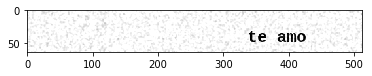

In [48]:
plt.imshow(swift_img, cmap='gray')

In [49]:
imgs = np.zeros((1, 512, 64, 1))
imgs[0, :, :, 0] = swift_img.T

In [50]:
output = cutted_model.predict(imgs.reshape((1, 512*64)))
print(decode_batch(output))

['te amo']
